# Cross-National CVE Exploitation Prediction Analysis

## 0. Research Objective
### Comprehensive cross-national analysis of CVE exploitation patterns: Selecting 🇯🇵 Japan as a case study to identify key differences between Japan-related and Non-Japan-related vulnerabilities through advanced machine learning, feature importance analysis, and bias detection.

This research aims to:
- **Understand regional differences** in vulnerability exploitation patterns between Japan and global markets
- **Identify predictive features** that distinguish exploited vs. non-exploited CVEs in each region
- **Develop robust ML models** using multiple algorithms and ensemble methods
- **Assess model fairness** through bias detection and calibration analysis
- **Compare feature importance** across different model types and performance tiers

### 0.1. Analysis Pipeline
For more details, see attached [METHODOLOGY_AND_APPROACH.md](METHODOLOGY_AND_APPROACH.md) 
This notebook presents a comprehensive analysis pipeline:
1. **Data Extraction**: Extract features from CVE JSON files (2021-2025)
2. **Data Categorization**: Identify Japan-related vs Non-Japan-related CVEs
3. **Exploitation Analysis**: Categorize CVEs into exploited vs not exploited
4. **Advanced Machine Learning**: 
   - Train 7 model types (Random Forest, XGBoost, Logistic Regression, Neural Networks, Gradient Boosting, Voting, Stacking)
   - Hyperparameter optimization (Grid Search, Random Search, Bayesian Optimization with Optuna)
   - Stratified 5-fold cross-validation
   - Performance evaluation on holdout test sets
5. **Comprehensive Feature Importance Analysis**:
   - Best models (rank 1)
   - Second best models (rank 2)
   - All remaining models (ranks 3+)
   - Cross-regional comparison
   - Category-level aggregation
6. **Bias Detection & Fairness Analysis**:
   - False Positive Rate (FPR) and False Negative Rate (FNR)
   - Calibration analysis
   - Cross-regional bias comparison
7. **Cross-National Comparison**: Compare model performance, feature importance, and bias metrics between Japan and Non-Japan datasets

### 0.2. Dataset
See attached [README.md](README.md) as to how to get the CVE data and set up the directory for data.
- **CVE Data**: CVE 5.1 format JSON files from 2021-2025 (PUBLISHED state only)
- **KEV Data**: Known Exploited Vulnerabilities catalog
- **Target Variable**: `exploited = in_kev OR has_indicators`




## 1. Setup and Imports

**⚠️ IMPORTANT: XGBoost is REQUIRED for this analysis.**

### Architecture Issue (Python 3.11 vs 3.13)

If you see an architecture mismatch error, Jupyter is likely using Python 3.11 (x86_64) while XGBoost needs ARM64.

**Quick Fix: Use Python 3.13**

1. **Run setup script** (in terminal):
   ```bash
   ./setup_jupyter_python313.sh
   ```

2. **In Jupyter**: Go to `Kernel` → `Change Kernel` → Select `Python 3.13 (XGBoost Ready)`

3. **Restart kernel** and rerun cells

### Alternative: Check Current Python

Run this cell to check which Python version Jupyter is using:
```python
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
```

**Expected**: Should use Python 3.13 (ARM64) for Apple Silicon Macs.

The notebook will raise an error with detailed instructions if XGBoost cannot be imported.


In [1]:
#!pip install pandas numpy matplotlib seaborn  scipy imblearn optuna tensorflow keras xgboost imblearn

import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Optional
from collections import defaultdict, Counter
import warnings
import re
import random
import os
import sys
from scipy.stats import randint, uniform

# Increase CSV field size limit for large fields
csv.field_size_limit(10000000)
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from imblearn.over_sampling import SMOTE

# Bayesian Optimization
try:
    import optuna
    print(f"✅ Optuna imported successfully (version {optuna.__version__})")
    OPTUNA_AVAILABLE = True
except ImportError:
    print("⚠️  Optuna not available. Install with: pip install optuna")
    OPTUNA_AVAILABLE = False

# TensorFlow/Keras for GPU acceleration on Apple Silicon
try:
    import tensorflow as tf
    import keras
    # On Apple Silicon, TensorFlow automatically uses Metal GPU acceleration
    # even if it doesn't show up as a "GPU" device
    try:
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            print(f"✅ TensorFlow GPU devices found: {[d.name for d in physical_devices]}")
        else:
            # Check if we're on Apple Silicon - Metal acceleration is automatic
            import platform
            if platform.processor() == 'arm' or platform.machine() == 'arm64':
                print("✅ TensorFlow will use Metal GPU acceleration (Apple Silicon)")
                print("   Note: Metal acceleration is automatic and transparent on Apple Silicon")
            else:
                print("⚠️  No GPU devices found. TensorFlow will use CPU.")
    except Exception as e:
        print(f"⚠️  GPU detection issue: {e}. TensorFlow will use available devices.")
    
    TENSORFLOW_AVAILABLE = True
    print(f"✅ TensorFlow imported successfully (version {tf.__version__})")
    print(f"✅ Keras version: {keras.__version__}")
except ImportError:
    print("⚠️  TensorFlow not available. Neural networks will use scikit-learn (CPU only).")
    print("   Install with: pip install tensorflow (for Apple Silicon)")
    TENSORFLOW_AVAILABLE = False
    tf = None
    keras = None

# XGBoost is REQUIRED for this analysis
# Try to import xgboost - if it fails, provide clear instructions
try:
    import xgboost as xgb
    print(f"✅ XGBoost imported successfully (version {xgb.__version__})")
except Exception as e:
    error_msg = str(e)
    print("=" * 80)
    print("❌ ERROR: XGBoost is REQUIRED but could not be imported!")
    print("=" * 80)
    print(f"\nError details: {error_msg}")
    print("\n🔧 SOLUTIONS:")
    print("\n1. Install/upgrade libomp:")
    print("   brew install libomp")
    print("\n2. Create symlink (run in terminal with sudo):")
    print("   sudo mkdir -p /usr/local/opt/libomp/lib")
    print("   sudo ln -sf /opt/homebrew/opt/libomp/lib/libomp.dylib /usr/local/opt/libomp/lib/libomp.dylib")
    print("\n3. Reinstall XGBoost:")
    print("   pip install --upgrade --force-reinstall xgboost")
    print("\n4. Restart Jupyter kernel after completing the above steps")
    print("\n5. If using conda, try:")
    print("   conda install -c conda-forge xgboost")
    print("\n" + "=" * 80)
    raise ImportError(
        "XGBoost is required for this analysis. Please follow the instructions above "
        "to install XGBoost and restart the kernel."
    ) from e

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set project root
project_root = Path.cwd()
print(f"\nProject root: {project_root}")
print(f"Python version: {sys.version.split()[0]}")
print(f"XGBoost version: {xgb.__version__}")


✅ Optuna imported successfully (version 4.6.0)
✅ TensorFlow will use Metal GPU acceleration (Apple Silicon)
   Note: Metal acceleration is automatic and transparent on Apple Silicon
✅ TensorFlow imported successfully (version 2.20.0)
✅ Keras version: 3.12.0
✅ XGBoost imported successfully (version 3.1.2)

Project root: /Users/kfunaki/Projects/ML/cross_national_cve
Python version: 3.13.7
XGBoost version: 3.1.2


## 2. Data Extraction from CVE JSON Files

Extract features from CVE JSON files (CVE 5.1 format) for years 2021-2025. Only process CVEs with `state = 'PUBLISHED'`.

### Feature Selection Methodology

Features are selected using a **phased approach** that systematically incorporates domain knowledge and data-driven insights:

#### **Core Features (Always Included)**

**Categorical Features (One-Hot Encoded):**
- `vendor`: Vendor name - Different vendors have different security practices, patch frequencies, and market share
- `product`: Product name - Specific products have different exploitation patterns and attack surfaces
- `cvss_base_severity`: CVSS severity level (CRITICAL, HIGH, MEDIUM, LOW, NONE, Unknown) - Directly relates to exploitation likelihood

**Numerical Features (Standardized):**
- `cvss_score`: CVSS base score (0.0-10.0) - Quantifies vulnerability severity, imputed with median for missing values
- `has_cvss_score`: Binary indicator for CVSS availability - Missing CVSS data can be predictive
- `vendor_popularity`: Frequency count of CVEs per vendor - Popular vendors are more attractive targets

#### **Phase 1: Quick Wins**
Simple, readily available features that provide immediate predictive value:
- `year`: Temporal feature (2021-2025, one-hot encoded) - Exploitation patterns may vary by year
- `reference_count`: Number of references - More references indicate more attention from security community
- `has_metrics`: Binary indicator for metrics existence - Data completeness signal

**Rationale:** These features are easy to extract, have high data availability, and provide baseline predictive power.

#### **Phase 2: CVSS Details**
Comprehensive CVSS component features capturing exploitability and impact:
- `cvss_attack_vector`: NETWORK, ADJACENT_NETWORK, LOCAL, PHYSICAL - Network vulnerabilities are more exploitable remotely
- `cvss_attack_complexity`: LOW, HIGH - Lower complexity = easier to exploit
- `cvss_privileges_required`: NONE, LOW, HIGH - Affects attack feasibility
- `cvss_user_interaction`: NONE, REQUIRED - User interaction requirements impact exploitability
- `cvss_confidentiality_impact`: NONE, LOW, HIGH - Impact on confidentiality
- `cvss_integrity_impact`: NONE, LOW, HIGH - Impact on data integrity
- `cvss_availability_impact`: NONE, LOW, HIGH - Impact on system availability

**Rationale:** CVSS components provide granular information about vulnerability characteristics that directly relate to exploitation likelihood. Missing values are handled as 'UNKNOWN' category.

#### **Phase 3: Advanced Features**
Domain-specific features requiring more complex extraction:
- **CWE IDs:** Top 20 most common CWE IDs converted to binary indicators (`has_cwe_CWE_79`, `has_cwe_CWE_89`, etc.)
  - Selected by frequency across the dataset
  - Common weakness patterns (e.g., Cross-site Scripting, SQL Injection) are strong predictors
- **Exploit References:** `has_exploit_reference` - Binary indicator if reference tags contain "exploit"
  - Direct signal of exploitation activity
  - Derived from reference metadata

**Rationale:** CWE patterns and exploit indicators provide domain-specific signals that complement CVSS metrics.

### Feature Engineering Process

1. **Categorical Encoding:**
   - One-hot encoding with `drop_first=True` to avoid multicollinearity
   - Missing values filled with 'Unknown' or 'UNKNOWN' before encoding

2. **Numerical Preprocessing:**
   - Standardized using `StandardScaler` (zero mean, unit variance)
   - CVSS scores imputed with median (or year-specific median if available)
   - Vendor popularity calculated as frequency count, then standardized

3. **Feature Categories:**
   Features are automatically categorized for interpretability:
   - **CVSS_Score**: Base CVSS score and availability indicators
   - **CVSS_Severity**: Severity levels
   - **CVSS_Exploitability**: Attack vector, complexity, privileges, user interaction
   - **CVSS_Impact**: Confidentiality, integrity, availability impacts
   - **Vendor**: Vendor names and popularity
   - **Product**: Product names
   - **CWE**: Common Weakness Enumeration patterns
   - **Reference**: Reference counts and exploit indicators
   - **Temporal**: Year-based features
   - **Exploit_Indicator**: Direct exploitation signals

### Feature Selection Criteria

1. **Data Availability:** Features must be present in CVE 5.1 JSON format
2. **Domain Knowledge:** Features align with cybersecurity domain expertise (CVSS, CWE, vendor/product)
3. **Frequency-Based:** CWE features selected by frequency (top 20 most common)
4. **No Explicit Filtering:** All available features included (no feature selection based on importance)

**Note:** The current implementation includes all available features without explicit feature selection. Future improvements could incorporate:
- Feature importance-based filtering
- Correlation analysis to remove redundant features
- Recursive feature elimination
- Domain expert validation


In [2]:
# Helper functions for extracting features from CVE JSON

def safe_get(data: Dict, *keys, default=None):
    """Safely navigate nested dictionaries."""
    for key in keys:
        if isinstance(data, dict):
            data = data.get(key, {})
        else:
            return default
    return data if data else default

def extract_list_values(data_list: List, key: str, default: List = None) -> str:
    """Extract values from a list of dictionaries and join with pipe."""
    if not data_list or not isinstance(data_list, list):
        return ""
    values = []
    for item in data_list:
        if isinstance(item, dict):
            value = item.get(key, "")
            if value:
                values.append(str(value))
    return "|".join(values) if values else ""

def extract_cwe_ids(problem_types: List) -> tuple:
    """Extract CWE IDs and descriptions from problem types."""
    cwe_ids = []
    cwe_descriptions = []
    problem_type_texts = []
    
    if not problem_types:
        return ("", "", "")
    
    for pt in problem_types:
        descriptions = pt.get("descriptions", [])
        for desc in descriptions:
            desc_type = desc.get("type", "")
            if desc_type == "CWE":
                cwe_id = desc.get("cweId", "")
                cwe_desc = desc.get("description", "")
                if cwe_id:
                    cwe_ids.append(cwe_id)
                if cwe_desc:
                    cwe_descriptions.append(cwe_desc)
            elif desc_type == "text":
                text_desc = desc.get("description", "")
                if text_desc:
                    problem_type_texts.append(text_desc)
    
    return (
        "|".join(cwe_ids),
        "|".join(cwe_descriptions),
        "|".join(problem_type_texts)
    )

def extract_cvss_metrics(metrics: List) -> Dict[str, Any]:
    """Extract CVSS metrics from metrics list."""
    result = {
        "cvss_version": "",
        "cvss_base_score": "",
        "cvss_base_severity": "",
        "cvss_vector_string": "",
        "cvss_attack_vector": "",
        "cvss_attack_complexity": "",
        "cvss_privileges_required": "",
        "cvss_user_interaction": "",
        "cvss_scope": "",
        "cvss_confidentiality_impact": "",
        "cvss_integrity_impact": "",
        "cvss_availability_impact": "",
    }
    
    if not metrics:
        return result
    
    # Find CVSS metrics
    for metric in metrics:
        if metric.get("format") == "CVSS":
            cvss_v3_1 = metric.get("cvssV3_1", {})
            cvss_v3_0 = metric.get("cvssV3_0", {})
            cvss_v2_0 = metric.get("cvssV2_0", {})
            
            cvss_data = cvss_v3_1 or cvss_v3_0 or cvss_v2_0
            
            if cvss_data:
                result["cvss_version"] = cvss_data.get("version", "")
                result["cvss_base_score"] = cvss_data.get("baseScore", "")
                result["cvss_base_severity"] = cvss_data.get("baseSeverity", "")
                result["cvss_vector_string"] = cvss_data.get("vectorString", "")
                result["cvss_attack_vector"] = cvss_data.get("attackVector", "")
                result["cvss_attack_complexity"] = cvss_data.get("attackComplexity", "")
                result["cvss_privileges_required"] = cvss_data.get("privilegesRequired", "")
                result["cvss_user_interaction"] = cvss_data.get("userInteraction", "")
                result["cvss_scope"] = cvss_data.get("scope", "")
                result["cvss_confidentiality_impact"] = cvss_data.get("confidentialityImpact", "")
                result["cvss_integrity_impact"] = cvss_data.get("integrityImpact", "")
                result["cvss_availability_impact"] = cvss_data.get("availabilityImpact", "")
                break
    
    return result

def extract_affected_products(affected: List) -> Dict[str, Any]:
    """Extract affected product information."""
    result = {
        "vendor": "",
        "product": "",
        "package_name": "",
        "affected_versions": "",
        "version_type": "",
        "collection_url": "",
    }
    
    if not affected or len(affected) == 0:
        return result
    
    # Get first affected product
    first_affected = affected[0]
    result["vendor"] = first_affected.get("vendor", "")
    result["product"] = first_affected.get("product", "")
    result["package_name"] = first_affected.get("packageName", "")
    result["collection_url"] = first_affected.get("collectionURL", "")
    
    # Extract versions
    versions = first_affected.get("versions", [])
    version_list = []
    version_types = []
    for v in versions:
        version_str = v.get("version", "")
        version_type = v.get("versionType", "")
        if version_str and version_str != "n/a":
            version_list.append(version_str)
        if version_type:
            version_types.append(version_type)
    
    result["affected_versions"] = "|".join(version_list)
    result["version_type"] = "|".join(set(version_types))
    
    return result

def extract_references(references: List) -> Dict[str, Any]:
    """Extract reference information."""
    result = {
        "reference_count": len(references) if references else 0,
        "reference_urls": "",
        "reference_tags": "",
    }
    
    if not references:
        return result
    
    urls = []
    all_tags = []
    
    for ref in references:
        url = ref.get("url", "")
        if url:
            urls.append(url)
        
        tags = ref.get("tags", [])
        for tag in tags:
            if tag not in all_tags:
                all_tags.append(tag)
    
    result["reference_urls"] = "|".join(urls)
    result["reference_tags"] = "|".join(all_tags)
    
    return result

def process_cve_file(json_path: Path) -> Optional[Dict[str, Any]]:
    """Process a single CVE JSON file and extract features."""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        return None
    
    # Extract CVE metadata
    cve_metadata = data.get("cveMetadata", {})
    cve_id = cve_metadata.get("cveId", "")
    
    if not cve_id:
        return None
    
    # Filter: only process PUBLISHED CVEs
    state = cve_metadata.get("state", "")
    if state != "PUBLISHED":
        return None
    
    # Extract year from CVE ID
    year = ""
    if cve_id.startswith("CVE-"):
        parts = cve_id.split("-")
        if len(parts) >= 2:
            year = parts[1]
    
    # Extract containers
    containers = data.get("containers", {})
    cna = containers.get("cna", {})
    
    # Extract descriptions
    descriptions = cna.get("descriptions", [])
    description = ""
    description_html = ""
    for desc in descriptions:
        if desc.get("lang") == "en":
            description = desc.get("value", "")
            supporting_media = desc.get("supportingMedia", [])
            for media in supporting_media:
                if media.get("type") == "text/html":
                    description_html = media.get("value", "")
                    break
            break
    
    # Extract problem types
    problem_types = cna.get("problemTypes", [])
    cwe_ids, cwe_descriptions, problem_type_texts = extract_cwe_ids(problem_types)
    
    # Extract CVSS metrics
    metrics = cna.get("metrics", [])
    cvss_data = extract_cvss_metrics(metrics)
    
    # Extract affected products
    affected = cna.get("affected", [])
    affected_data = extract_affected_products(affected)
    
    # Extract references
    references = cna.get("references", [])
    ref_data = extract_references(references)
    
    # Extract provider metadata
    provider_metadata = cna.get("providerMetadata", {})
    
    # Extract credits
    credits = cna.get("credits", [])
    credits_str = extract_list_values(credits, "value")
    
    # Extract source
    source = cna.get("source", {})
    
    # Build feature dictionary
    features = {
        "cve_id": cve_id,
        "year": year,
        "state": cve_metadata.get("state", ""),
        "assigner_org_id": cve_metadata.get("assignerOrgId", ""),
        "assigner_short_name": cve_metadata.get("assignerShortName", ""),
        "date_reserved": cve_metadata.get("dateReserved", ""),
        "date_published": cve_metadata.get("datePublished", ""),
        "date_updated": cve_metadata.get("dateUpdated", ""),
        "description": description,
        "description_html": description_html,
        "cwe_ids": cwe_ids,
        "cwe_descriptions": cwe_descriptions,
        "problem_type_text": problem_type_texts,
        **cvss_data,
        **affected_data,
        **ref_data,
        "provider_org_id": provider_metadata.get("orgId", ""),
        "provider_short_name": provider_metadata.get("shortName", ""),
        "provider_date_updated": provider_metadata.get("dateUpdated", ""),
        "title": cna.get("title", ""),
        "credits": credits_str,
        "source_discovery": source.get("discovery", ""),
        "has_metrics": 1 if metrics else 0,
        "has_affected": 1 if affected else 0,
        "has_references": 1 if references else 0,
    }
    
    return features

print("✅ Helper functions defined")


✅ Helper functions defined


In [3]:
# Extract CVE data from JSON files (or load from existing CSV if available)
data_dir = project_root / "data" / "cvelistV5-main" / "cves"
output_csv = project_root / "results" / "cve_features_2021_2025.csv"
years = [2021, 2022, 2023, 2024, 2025]

# Check if CSV already exists
if output_csv.exists():
    print(f"✅ Loading existing CSV file: {output_csv}")
    cve_features_df = pd.read_csv(output_csv, low_memory=False)
    print(f"   Loaded {len(cve_features_df):,} CVEs")
else:
    print(f"📂 Extracting CVE data from JSON files...")
    print(f"   Data directory: {data_dir}")
    
    # Get all CVE files
    cve_files = []
    for year in years:
        year_dir = data_dir / str(year)
        if year_dir.exists():
            json_files = list(year_dir.rglob("*.json"))
            cve_files.extend(json_files)
    
    print(f"   Found {len(cve_files):,} CVE JSON files")
    
    # Process files
    all_features = []
    processed = 0
    filtered = 0
    
    for i, cve_file in enumerate(cve_files):
        if (i + 1) % 1000 == 0:
            print(f"   Processed {i + 1}/{len(cve_files)} files... (Published: {processed}, Filtered: {filtered})")
        
        features = process_cve_file(cve_file)
        if features:
            all_features.append(features)
            processed += 1
        else:
            filtered += 1
    
    # Create DataFrame
    cve_features_df = pd.DataFrame(all_features)
    
    # Save to CSV
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    cve_features_df.to_csv(output_csv, index=False)
    print(f"\n✅ Extracted {len(cve_features_df):,} PUBLISHED CVEs")
    print(f"   Saved to: {output_csv}")

print(f"\n📊 Dataset Summary:")
print(f"   Total CVEs: {len(cve_features_df):,}")
print(f"   Years: {sorted(cve_features_df['year'].unique())}")
print(f"   Columns: {len(cve_features_df.columns)}")


✅ Loading existing CSV file: /Users/kfunaki/Projects/ML/cross_national_cve/results/cve_features_2021_2025.csv
   Loaded 150,251 CVEs

📊 Dataset Summary:
   Total CVEs: 150,251
   Years: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
   Columns: 49


## 3. Japan vs Non-Japan Categorization

Identify Japan-related CVEs by checking for Japan-specific keywords (JVN, JPCERT, etc.) in descriptions, reference URLs, and vendor/product names.


In [4]:
# Load KEV data
kev_file = project_root / 'data' / 'unified_vulnerability_dataset_real_kev.csv'
kev_df = pd.read_csv(kev_file)
exploited_cves = set(kev_df['cve_id'].dropna().str.upper().unique())
print(f"✅ Loaded {len(exploited_cves):,} CVEs from KEV data")

# Function to check if a CVE is Japan-related
def check_japan_related(text):
    """Check if text mentions JVN, JPCERT, or Japan-related terms (case-insensitive)."""
    if not text or not isinstance(text, str):
        return False
    text_lower = text.lower()
    japan_keywords = ['jvn', 'jpcert', 'jvnv', 'jvndb']
    return any(keyword in text_lower for keyword in japan_keywords)

# Categorize CVEs
print("\n📊 Categorizing CVEs as Japan-related or Non-Japan-related...")

japan_cves = []
non_japan_cves = []

for _, row in cve_features_df.iterrows():
    cve_id = row.get('cve_id', '').strip()
    if not cve_id:
        continue
    
    has_japan = False
    
    # Check description
    description = row.get('description', '')
    if check_japan_related(description):
        has_japan = True
    
    # Check description_html
    if not has_japan:
        description_html = row.get('description_html', '')
        if check_japan_related(description_html):
            has_japan = True
    
    # Check reference URLs
    if not has_japan:
        reference_urls = row.get('reference_urls', '')
        if reference_urls:
            for url in str(reference_urls).split('|'):
                if check_japan_related(url):
                    has_japan = True
                    break
    
    # Check for exploitation indicators
    is_exploited_kev = cve_id.upper() in exploited_cves
    
    # Check for exploitation indicators in description
    has_indicators = False
    description_lower = str(description).lower()
    if any(keyword in description_lower for keyword in ['exploit', 'exploited', 'active exploitation', 'in the wild']):
        has_indicators = True
    
    # Check CVSS score for high severity (>= 9.0)
    cvss_base_score_str = row.get('cvss_base_score', '')
    if cvss_base_score_str:
        try:
            cvss_score = float(cvss_base_score_str)
            if cvss_score >= 9.0:
                has_indicators = True
        except (ValueError, TypeError):
            pass
    
    # Categorize into three groups
    if is_exploited_kev:
        status = 'exploited_kev'
    elif has_indicators:
        status = 'has_indicators'
    else:
        status = 'not_exploited'
    
    cve_record = {
        'cve_id': cve_id,
        'year': row.get('year', ''),
        'has_japan': has_japan,
        'status': status,
        'in_kev': is_exploited_kev,
        'has_indicators': has_indicators
    }
    
    if has_japan:
        japan_cves.append(cve_record)
    else:
        non_japan_cves.append(cve_record)

# Create DataFrames
jp_df = pd.DataFrame(japan_cves)
nonjp_df = pd.DataFrame(non_japan_cves)

print(f"\n✅ Categorization complete!")
print(f"   Japan-related CVEs: {len(jp_df):,}")
print(f"   Non-Japan-related CVEs: {len(nonjp_df):,}")

# Create random sample of non-Japan CVEs (6000)
random.seed(42)
sample_size = min(6000, len(non_japan_cves))
nonjp_sample = random.sample(non_japan_cves, sample_size)
nonjp_sample_df = pd.DataFrame(nonjp_sample)

print(f"   Non-Japan sample size: {len(nonjp_sample_df):,}")

# Save results
results_dir = project_root / 'results'
results_dir.mkdir(exist_ok=True)

jp_df.to_csv(results_dir / 'jp_2021_2025_three_categories.csv', index=False)
nonjp_df.to_csv(results_dir / 'nonjp_2021_2025_three_categories.csv', index=False)
nonjp_sample_df.to_csv(results_dir / 'nonjp_2021_2025_three_categories_sample_6000.csv', index=False)

print(f"\n📊 Exploitation Statistics:")
print(f"\nJapan-related CVEs:")
print(f"   exploited_kev: {jp_df['in_kev'].sum():,} ({jp_df['in_kev'].mean():.2%})")
print(f"   has_indicators: {jp_df['has_indicators'].sum():,} ({jp_df['has_indicators'].mean():.2%})")
print(f"   not_exploited: {(~jp_df['in_kev'] & ~jp_df['has_indicators']).sum():,} ({(~jp_df['in_kev'] & ~jp_df['has_indicators']).mean():.2%})")

print(f"\nNon-Japan-related CVEs (sample):")
print(f"   exploited_kev: {nonjp_sample_df['in_kev'].sum():,} ({nonjp_sample_df['in_kev'].mean():.2%})")
print(f"   has_indicators: {nonjp_sample_df['has_indicators'].sum():,} ({nonjp_sample_df['has_indicators'].mean():.2%})")
print(f"   not_exploited: {(~nonjp_sample_df['in_kev'] & ~nonjp_sample_df['has_indicators']).sum():,} ({(~nonjp_sample_df['in_kev'] & ~nonjp_sample_df['has_indicators']).mean():.2%})")


✅ Loaded 4,427 CVEs from KEV data

📊 Categorizing CVEs as Japan-related or Non-Japan-related...

✅ Categorization complete!
   Japan-related CVEs: 1,509
   Non-Japan-related CVEs: 148,742
   Non-Japan sample size: 6,000

📊 Exploitation Statistics:

Japan-related CVEs:
   exploited_kev: 21 (1.39%)
   has_indicators: 288 (19.09%)
   not_exploited: 1,212 (80.32%)

Non-Japan-related CVEs (sample):
   exploited_kev: 130 (2.17%)
   has_indicators: 1,415 (23.58%)
   not_exploited: 4,495 (74.92%)


## 3.5 Feature Extraction and Categorization

This section explains how features are extracted from CVE data and categorized for machine learning.

### Feature Categories

Features are organized into the following categories for analysis:

1. **CVSS_Score**: Base CVSS score (numerical, 0-10)
   - `cvss_score`: Imputed CVSS base score (median imputation for missing values)
   - `has_cvss_score`: Binary indicator (1 if CVSS score exists, 0 otherwise)

2. **CVSS_Severity**: Base severity level (categorical)
   - `cvss_base_severity`: CRITICAL, HIGH, MEDIUM, LOW, NONE (one-hot encoded)

3. **CVSS_Exploitability**: Attack characteristics (categorical)
   - `cvss_attack_vector`: NETWORK, ADJACENT_NETWORK, LOCAL, PHYSICAL
   - `cvss_attack_complexity`: LOW, HIGH
   - `cvss_privileges_required`: NONE, LOW, HIGH
   - `cvss_user_interaction`: NONE, REQUIRED

4. **CVSS_Impact**: Impact on security properties (categorical)
   - `cvss_confidentiality_impact`: NONE, LOW, HIGH
   - `cvss_integrity_impact`: NONE, LOW, HIGH
   - `cvss_availability_impact`: NONE, LOW, HIGH

5. **Vendor**: Vendor information (categorical)
   - `vendor`: Vendor name (one-hot encoded)
   - `vendor_popularity`: Count of CVEs per vendor (numerical, standardized)

6. **Product**: Product information (categorical)
   - `product`: Product name (one-hot encoded)

7. **CWE**: Common Weakness Enumeration (categorical)
   - `has_cwe_*`: Binary indicators for top 20 most common CWE IDs
   - Examples: `has_cwe_CWE_79` (Cross-site Scripting), `has_cwe_CWE_89` (SQL Injection)

8. **Reference**: Reference and metadata features (numerical/categorical)
   - `reference_count`: Number of references (numerical, standardized)
   - `has_exploit_reference`: Binary indicator if reference tags contain "exploit"
   - `has_metrics`: Binary indicator if CVSS metrics exist

9. **Temporal**: Time-based features (categorical)
   - `year`: Year of CVE (2021-2025, one-hot encoded)

10. **Exploit_Indicator**: Direct exploitation signals (binary)
    - `has_exploit_reference`: Derived from reference tags

### Feature Engineering Process

1. **Categorical Features**: One-hot encoded with `drop_first=True` to avoid multicollinearity
2. **Numerical Features**: Standardized using `StandardScaler` (zero mean, unit variance)
3. **Missing Values**:
   - CVSS scores: Imputed with median (or year-specific median if available)
   - Categorical: Filled with 'UNKNOWN' or 'Unknown' before one-hot encoding
4. **CWE Features**: Top 20 most common CWE IDs extracted and converted to binary indicators
5. **Vendor Popularity**: Calculated as frequency count per vendor, then standardized

### Feature Categorization Function

The `categorize_feature()` function automatically assigns features to categories based on naming patterns:
- Features containing "cvss" → CVSS-related categories
- Features containing "vendor" → Vendor category
- Features containing "product" → Product category
- Features containing "cwe" → CWE category
- Features containing "reference" → Reference category
- Features containing "year" → Temporal category
- Features containing "exploit" → Exploit_Indicator category


In [5]:
# Demonstrate feature categorization
print("=" * 80)
print("FEATURE CATEGORIZATION DEMONSTRATION")
print("=" * 80)

# Sample feature names that would be generated
sample_features = [
    'cvss_score',
    'cvss_base_severity_HIGH',
    'cvss_attack_vector_NETWORK',
    'cvss_confidentiality_impact_HIGH',
    'vendor_Adobe',
    'product_Chrome',
    'vendor_popularity',
    'has_cwe_CWE_79',
    'reference_count',
    'has_exploit_reference',
    'year_2023',
    'has_metrics'
]

def categorize_feature_demo(feature_name):
    """Demonstrate feature categorization logic."""
    feature_lower = feature_name.lower()
    
    if 'cvss' in feature_lower:
        if 'attack' in feature_lower or 'complexity' in feature_lower or 'privileges' in feature_lower or 'user_interaction' in feature_lower:
            return 'CVSS_Exploitability'
        elif 'confidentiality' in feature_lower or 'integrity' in feature_lower or 'availability' in feature_lower:
            return 'CVSS_Impact'
        elif 'severity' in feature_lower:
            return 'CVSS_Severity'
        else:
            return 'CVSS_Score'
    elif 'vendor' in feature_lower:
        return 'Vendor'
    elif 'product' in feature_lower:
        return 'Product'
    elif 'cwe' in feature_lower:
        return 'CWE'
    elif 'reference' in feature_lower:
        return 'Reference'
    elif 'year' in feature_lower:
        return 'Temporal'
    elif 'exploit' in feature_lower:
        return 'Exploit_Indicator'
    else:
        return 'Other'

print("\nFeature Name → Category Mapping:")
print("-" * 80)
for feature in sample_features:
    category = categorize_feature_demo(feature)
    print(f"{feature:<40} → {category}")

print("\n" + "=" * 80)
print("Feature Engineering Summary")
print("=" * 80)
print("""
Total Feature Types:
- Categorical (one-hot encoded): vendor, product, CVSS severity/vectors/impacts, year
- Numerical (standardized): CVSS score, vendor popularity, reference count, has_metrics
- Binary indicators: has_cvss_score, has_cwe_*, has_exploit_reference

Feature Count: Varies by dataset (typically 100-500 features after one-hot encoding)
""")


FEATURE CATEGORIZATION DEMONSTRATION

Feature Name → Category Mapping:
--------------------------------------------------------------------------------
cvss_score                               → CVSS_Score
cvss_base_severity_HIGH                  → CVSS_Severity
cvss_attack_vector_NETWORK               → CVSS_Exploitability
cvss_confidentiality_impact_HIGH         → CVSS_Impact
vendor_Adobe                             → Vendor
product_Chrome                           → Product
vendor_popularity                        → Vendor
has_cwe_CWE_79                           → CWE
reference_count                          → Reference
has_exploit_reference                    → Reference
year_2023                                → Temporal
has_metrics                              → Other

Feature Engineering Summary

Total Feature Types:
- Categorical (one-hot encoded): vendor, product, CVSS severity/vectors/impacts, year
- Numerical (standardized): CVSS score, vendor popularity, reference count, h

In [6]:
# Show actual feature categorization from the dataset (after feature engineering)
# This will be run after feature engineering to show real examples

def show_feature_categories(X, top_n_per_category=5):
    """Show examples of features in each category."""
    print("=" * 80)
    print("ACTUAL FEATURE CATEGORIZATION FROM DATASET")
    print("=" * 80)
    
    categories = {
        'CVSS_Score': [],
        'CVSS_Severity': [],
        'CVSS_Exploitability': [],
        'CVSS_Impact': [],
        'Vendor': [],
        'Product': [],
        'CWE': [],
        'Reference': [],
        'Temporal': [],
        'Exploit_Indicator': [],
        'Other': []
    }
    
    for feature in X.columns:
        category = categorize_feature_demo(feature)
        categories[category].append(feature)
    
    print(f"\nTotal features: {len(X.columns)}")
    print(f"\nFeature distribution by category:")
    print("-" * 80)
    
    for category, features in categories.items():
        count = len(features)
        if count > 0:
            print(f"\n{category}: {count} features")
            if count <= top_n_per_category:
                for feat in features:
                    print(f"  - {feat}")
            else:
                for feat in features[:top_n_per_category]:
                    print(f"  - {feat}")
                print(f"  ... and {count - top_n_per_category} more")
    
    return categories

# Note: This will be called after feature engineering in the ML section
print("✅ Feature categorization function ready")
print("   (Will show actual features after feature engineering)")


✅ Feature categorization function ready
   (Will show actual features after feature engineering)


## 4. Machine Learning Analysis

Train separate ML models for Japan and Non-Japan CVEs to predict exploitation. Features include:
- **Categorical**: vendor, product, CVSS severity, CVSS attack vectors/impacts
- **Numerical**: CVSS score, vendor popularity, reference count, year
- **CWE**: Top 20 CWE IDs (one-hot encoded)
- **Exploit indicators**: Reference tags containing "exploit"

**Target Variable**: `exploited = in_kev OR has_indicators`


In [7]:
# Feature engineering functions

def calculate_vendor_popularity(df):
    """Calculate vendor popularity based on frequency."""
    vendor_counts = df['vendor'].value_counts()
    vendor_popularity = df['vendor'].map(vendor_counts)
    return vendor_popularity.fillna(0)

def create_features(data, is_japanese=False, scaler_obj=None):
    """
    Create feature matrix from vulnerability data.
    Uses categorical and numerical features including Phase 1-3 candidate features.
    """
    data = data.reset_index(drop=True)
    feature_dfs = []
    
    # Categorical features (one-hot encoding)
    categorical_features = ['vendor', 'product', 'cvss_base_severity']
    
    for col in categorical_features:
        if col in data.columns:
            data[col] = data[col].fillna('Unknown')
            dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
            dummies.index = data.index
            feature_dfs.append(dummies)
    
    # Phase 1: year (categorical, one-hot encoded)
    if 'year' in data.columns:
        year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)
        year_dummies.index = data.index
        feature_dfs.append(year_dummies)
    
    # Phase 2: CVSS details
    cvss_categorical = [
        'cvss_attack_vector',
        'cvss_attack_complexity',
        'cvss_privileges_required',
        'cvss_user_interaction',
        'cvss_confidentiality_impact',
        'cvss_integrity_impact',
        'cvss_availability_impact'
    ]
    
    for col in cvss_categorical:
        if col in data.columns:
            data[col] = data[col].fillna('UNKNOWN')
            dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
            dummies.index = data.index
            feature_dfs.append(dummies)
    
    # Phase 3: CWE IDs - extract top 20 most common
    if 'cwe_ids' in data.columns:
        all_cwes = []
        for cwe_str in data['cwe_ids'].dropna():
            if isinstance(cwe_str, str):
                cwes = [c.strip() for c in cwe_str.split('|') if c.strip()]
                all_cwes.extend(cwes)
        
        if all_cwes:
            top_cwes = [cwe for cwe, count in Counter(all_cwes).most_common(20)]
            cwe_features = {}
            for cwe in top_cwes:
                cwe_clean = cwe.replace('-', '_').replace(' ', '_')
                has_cwe = data['cwe_ids'].str.contains(cwe, na=False, regex=False).astype(int)
                cwe_features[f'has_cwe_{cwe_clean}'] = has_cwe
            
            if cwe_features:
                cwe_df = pd.DataFrame(cwe_features, index=data.index)
                feature_dfs.append(cwe_df)
    
    # Reference tags - check for exploit-related tags
    if 'reference_tags' in data.columns:
        has_exploit_tag = data['reference_tags'].str.contains(
            'exploit', case=False, na=False, regex=False
        ).astype(int)
        exploit_tag_df = pd.DataFrame({'has_exploit_reference': has_exploit_tag}, index=data.index)
        feature_dfs.append(exploit_tag_df)
    
    # Numerical features
    vendor_popularity = calculate_vendor_popularity(data)
    
    # Handle CVSS scores - better imputation for missing values
    cvss_scores = pd.to_numeric(data.get('cvss_base_score', 0), errors='coerce')
    has_cvss_score = cvss_scores.notna().astype(int)
    
    # Impute missing CVSS scores with median
    cvss_median = cvss_scores.median()
    if 'year' in data.columns:
        year_medians = cvss_scores.groupby(data['year']).median()
        cvss_imputed = cvss_scores.copy()
        for year in data['year'].unique():
            year_mask = (data['year'] == year) & cvss_scores.isna()
            if year in year_medians.index and pd.notna(year_medians[year]):
                cvss_imputed[year_mask] = year_medians[year]
            else:
                cvss_imputed[year_mask] = cvss_median
        cvss_imputed = cvss_imputed.fillna(cvss_median)
    else:
        cvss_imputed = cvss_scores.fillna(cvss_median)
    
    # Prepare numerical features
    numerical_features = {
        'cvss_score': cvss_imputed,
        'has_cvss_score': has_cvss_score,
        'vendor_popularity': vendor_popularity
    }
    
    # Phase 1: reference_count, has_metrics
    if 'reference_count' in data.columns:
        numerical_features['reference_count'] = pd.to_numeric(
            data['reference_count'], errors='coerce'
        ).fillna(0)
    
    if 'has_metrics' in data.columns:
        numerical_features['has_metrics'] = pd.to_numeric(
            data['has_metrics'], errors='coerce'
        ).fillna(0).astype(int)
    
    numerical_data = pd.DataFrame(numerical_features, index=data.index)
    
    if scaler_obj is None:
        scaler = StandardScaler()
        numerical_scaled = scaler.fit_transform(numerical_data)
    else:
        scaler = scaler_obj
        numerical_scaled = scaler.transform(numerical_data)
    
    numerical_df = pd.DataFrame(numerical_scaled, columns=numerical_data.columns, index=data.index)
    feature_dfs.append(numerical_df)
    
    # Combine all features
    X = pd.concat(feature_dfs, axis=1) if feature_dfs else numerical_df
    
    # Clean column names
    X.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                 for col in X.columns]
    
    # Handle missing values
    X = X.fillna(0).replace([np.inf, -np.inf], 0)
    
    return X, scaler

print("✅ Feature engineering functions defined")


✅ Feature engineering functions defined


In [8]:
# Merge Japan and Non-Japan data with CVE features
jp_merged = jp_df.merge(cve_features_df, on='cve_id', how='left')

# Ensure we're using the correct sample size (6000, not 60000)
# If nonjp_sample_df has more than 10000 rows, randomly sample 6000 to maintain randomness
if 'nonjp_sample_df' in globals() and len(nonjp_sample_df) > 10000:
    print(f"⚠️  Warning: nonjp_sample_df has {len(nonjp_sample_df):,} rows. Expected ~6000.")
    print("   Please re-run the cell that creates the sample (cell 7) to regenerate with 6000 samples.")
    print("   For now, randomly sampling 6000 rows to maintain randomness...")
    # Use random_state=42 for reproducibility (same seed as original sampling in cell 7)
    # This ensures consistent results if the safety check triggers
    nonjp_sample_df = nonjp_sample_df.sample(n=6000, random_state=42).reset_index(drop=True)

nonjp_merged = nonjp_sample_df.merge(cve_features_df, on='cve_id', how='left')
print(f"✅ Using Non-Japan sample with {len(nonjp_sample_df):,} CVEs")

# Create target variable: exploited (1) if in_kev OR has_indicators, else 0
jp_merged['exploited'] = ((jp_merged['in_kev'] == True) | (jp_merged['has_indicators'] == True)).astype(int)
nonjp_merged['exploited'] = ((nonjp_merged['in_kev'] == True) | (nonjp_merged['has_indicators'] == True)).astype(int)

print(f"📊 Dataset Statistics:")
print(f"\nJapan Dataset:")
print(f"   Total: {len(jp_merged):,}")
print(f"   Exploited: {jp_merged['exploited'].sum():,} ({jp_merged['exploited'].mean():.2%})")
print(f"   Not Exploited: {(~jp_merged['exploited'].astype(bool)).sum():,} ({(~jp_merged['exploited'].astype(bool)).mean():.2%})")

print(f"\nNon-Japan Dataset:")
print(f"   Total: {len(nonjp_merged):,}")
print(f"   Exploited: {nonjp_merged['exploited'].sum():,} ({nonjp_merged['exploited'].mean():.2%})")
print(f"   Not Exploited: {(~nonjp_merged['exploited'].astype(bool)).sum():,} ({(~nonjp_merged['exploited'].astype(bool)).mean():.2%})")

# Feature engineering
print(f"\n🔧 Feature Engineering...")
X_jp, scaler_jp = create_features(jp_merged, is_japanese=True)
y_jp = jp_merged['exploited'].values

X_nonjp, scaler_nonjp = create_features(nonjp_merged, is_japanese=False)
y_nonjp = nonjp_merged['exploited'].values

print(f"   Japan feature matrix shape: {X_jp.shape}")
print(f"   Non-Japan feature matrix shape: {X_nonjp.shape}")

# Train-test split
X_jp_train, X_jp_test, y_jp_train, y_jp_test = train_test_split(
    X_jp, y_jp, test_size=0.2, random_state=42, stratify=y_jp
)

X_nonjp_train, X_nonjp_test, y_nonjp_train, y_nonjp_test = train_test_split(
    X_nonjp, y_nonjp, test_size=0.2, random_state=42, stratify=y_nonjp
)

print(f"\n📊 Train-Test Split:")
print(f"   Japan - Train: {X_jp_train.shape[0]}, Test: {X_jp_test.shape[0]}")
print(f"   Non-Japan - Train: {X_nonjp_train.shape[0]}, Test: {X_nonjp_test.shape[0]}")


✅ Using Non-Japan sample with 6,000 CVEs
📊 Dataset Statistics:

Japan Dataset:
   Total: 1,509
   Exploited: 297 (19.68%)
   Not Exploited: 1,212 (80.32%)

Non-Japan Dataset:
   Total: 6,000
   Exploited: 1,505 (25.08%)
   Not Exploited: 4,495 (74.92%)

🔧 Feature Engineering...
   Japan feature matrix shape: (1509, 1156)
   Non-Japan feature matrix shape: (6000, 4915)

📊 Train-Test Split:
   Japan - Train: 1207, Test: 302
   Non-Japan - Train: 4800, Test: 1200


In [9]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name="Model", verbose=True):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0,0], cm[0,1] if cm.shape[1] > 1 else 0, 
                                                   cm[1,0] if cm.shape[0] > 1 else 0, 
                                                   cm[1,1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'confusion_matrix': cm,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
    }
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"{model_name} Performance")
        print(f"{'='*60}")
        print(f"Confusion Matrix:")
        print(f"                Predicted")
        print(f"              Negative  Positive")
        print(f"Actual Negative   {tn:4d}     {fp:4d}")
        print(f"       Positive   {fn:4d}     {tp:4d}")
        print(f"\nMetrics:")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1']:.4f}")
        if metrics['roc_auc'] is not None:
            print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

# Import additional models and optimization tools
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# NEURAL NETWORK OPTIMIZATION WITH OPTUNA
# ============================================================================
def optimize_neural_network(X_train, y_train, n_trials=77, cv_folds=5, random_state=42):
    """Optimize neural network hyperparameters using Optuna Bayesian optimization.
    Uses TensorFlow/Keras with GPU acceleration if available, otherwise falls back to scikit-learn."""
    if not OPTUNA_AVAILABLE:
        print("⚠️  Optuna not available. Skipping neural network optimization.")
        return None, None
    
    use_tensorflow = TENSORFLOW_AVAILABLE and tf is not None
    if use_tensorflow:
        print("🚀 Using TensorFlow/Keras with GPU acceleration (Apple Silicon Metal)")
    else:
        print("⚠️  Using scikit-learn MLPClassifier (CPU only)")
        print("   Install TensorFlow for GPU acceleration: pip install tensorflow-macos tensorflow-metal")
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Convert to numpy arrays with proper dtype (float32 for X, numeric for y)
    if hasattr(X_train, 'values'):
        X_train_array = np.asarray(X_train.values, dtype=np.float32)
    else:
        X_train_array = np.asarray(X_train, dtype=np.float32)
    
    # Convert y_train to numeric array
    if hasattr(y_train, 'values'):
        y_train_values = y_train.values
        y_dtype = y_train.dtype
    else:
        y_train_values = y_train
        y_dtype = y_train.dtype if hasattr(y_train, 'dtype') else None
    
    # Determine appropriate dtype for y
    if y_dtype is not None:
        if np.issubdtype(y_dtype, np.integer) or np.issubdtype(y_dtype, np.bool_):
            y_train_array = np.asarray(y_train_values, dtype=np.int32)
        else:
            y_train_array = np.asarray(y_train_values, dtype=np.float32)
    else:
        # Fallback: try to infer from values
        y_train_array = np.asarray(y_train_values)
        if y_train_array.dtype == object:
            # If object dtype, try to convert to numeric
            y_train_array = pd.Series(y_train_values).astype('float32').values
        elif np.issubdtype(y_train_array.dtype, np.integer) or np.issubdtype(y_train_array.dtype, np.bool_):
            y_train_array = y_train_array.astype(np.int32)
        else:
            y_train_array = y_train_array.astype(np.float32)
    
    # Ensure arrays are contiguous (required for TensorFlow/Keras)
    X_train_array = np.ascontiguousarray(X_train_array)
    y_train_array = np.ascontiguousarray(y_train_array)
    
    def objective(trial):
        # Suggest hyperparameters
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [
            (50,), (100,), (200,), (50, 50), (100, 50), (200, 100), (100, 100)
        ])
        alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
        epochs = trial.suggest_int('epochs', 50, 200) if use_tensorflow else trial.suggest_int('max_iter', 200, 1000)
        
        # Cross-validation
        cv_scores = []
        for train_idx, val_idx in skf.split(X_train_array, y_train_array):
            X_train_fold, X_val_fold = X_train_array[train_idx], X_train_array[val_idx]
            y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]
            
            if use_tensorflow:
                # Use TensorFlow/Keras with GPU acceleration (Metal on Apple Silicon)
                import keras
                tf.random.set_seed(random_state)
                
                # Build model using Keras 3.x API
                model = keras.Sequential()
                model.add(keras.layers.Dense(hidden_layer_sizes[0], activation='relu', 
                                            input_shape=(X_train_fold.shape[1],),
                                            kernel_regularizer=keras.regularizers.L2(alpha)))
                for layer_size in hidden_layer_sizes[1:]:
                    model.add(keras.layers.Dense(layer_size, activation='relu',
                                                kernel_regularizer=keras.regularizers.L2(alpha)))
                model.add(keras.layers.Dense(1, activation='sigmoid'))
                
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_init),
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.AUC(name='auc')]
                )
                
                # Early stopping
                early_stop = keras.callbacks.EarlyStopping(
                    monitor='val_auc', patience=10, restore_best_weights=True
                )
                
                history = model.fit(
                    X_train_fold, y_train_fold,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                y_proba = model.predict(X_val_fold, verbose=0).flatten()
                score = roc_auc_score(y_val_fold, y_proba)
            else:
                # Use scikit-learn MLPClassifier (CPU only)
                model = MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    alpha=alpha,
                    learning_rate_init=learning_rate_init,
                    batch_size=batch_size,
                    max_iter=epochs,
                    random_state=random_state,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10
                )
                model.fit(X_train_fold, y_train_fold)
                y_proba = model.predict_proba(X_val_fold)[:, 1]
                score = roc_auc_score(y_val_fold, y_proba)
            
            cv_scores.append(score)
        
        return np.mean(cv_scores)
    
    # Run optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Get best parameters and create final model
    best_params = study.best_params
    
    if use_tensorflow:
        # Create TensorFlow model with best parameters
        import keras
        tf.random.set_seed(random_state)
        
        best_model = keras.Sequential()
        best_model.add(keras.layers.Dense(best_params['hidden_layer_sizes'][0], activation='relu',
                                         input_shape=(X_train_array.shape[1],),
                                         kernel_regularizer=keras.regularizers.L2(best_params['alpha'])))
        for layer_size in best_params['hidden_layer_sizes'][1:]:
            best_model.add(keras.layers.Dense(layer_size, activation='relu',
                                             kernel_regularizer=keras.regularizers.L2(best_params['alpha'])))
        best_model.add(keras.layers.Dense(1, activation='sigmoid'))
        
        best_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate_init']),
            loss='binary_crossentropy',
            metrics=[keras.metrics.AUC(name='auc')]
        )
        
        # Wrap TensorFlow model to be sklearn-compatible
        class TensorFlowWrapper:
            def __init__(self, model, params):
                self.model = model
                self.params = params
                self._estimator_type = "classifier"  # Mark as classifier for sklearn
            
            def fit(self, X, y):
                import keras
                # Set classes_ attribute for sklearn compatibility (required for permutation_importance)
                self.classes_ = np.unique(y)
                early_stop = keras.callbacks.EarlyStopping(
                    monitor='loss', patience=10, restore_best_weights=True
                )
                self.model.fit(X, y, 
                             batch_size=self.params.get('batch_size', 64),
                             epochs=self.params.get('epochs', 100),
                             callbacks=[early_stop],
                             verbose=0)
                return self
            
            def predict_proba(self, X):
                proba = self.model.predict(X, verbose=0)
                # Ensure output is 2D array with shape (n_samples, 2)
                proba = proba.flatten() if len(proba.shape) == 1 else proba
                return np.hstack([1 - proba, proba])
            
            def predict(self, X):
                return (self.model.predict(X, verbose=0) > 0.5).astype(int).flatten()
        
        return TensorFlowWrapper(best_model, best_params), best_params
    else:
        # Create scikit-learn model
        best_model = MLPClassifier(
            hidden_layer_sizes=best_params['hidden_layer_sizes'],
            alpha=best_params['alpha'],
            learning_rate_init=best_params['learning_rate_init'],
            batch_size=best_params['batch_size'],
            max_iter=best_params['max_iter'],
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )
        return best_model, best_params

# Prepare data with SMOTE
print("\n" + "="*80)
print("PREPARING DATA WITH SMOTE")
print("="*80)

# Japan data
print(f"\nJapan Dataset:")
print(f"  Before SMOTE: {X_jp_train.shape[0]} samples, {y_jp_train.mean():.2%} exploited")
smote_jp = SMOTE(random_state=42)
X_jp_train_smote, y_jp_train_smote = smote_jp.fit_resample(X_jp_train, y_jp_train)
print(f"  After SMOTE: {X_jp_train_smote.shape[0]} samples, {y_jp_train_smote.mean():.2%} exploited")

# Non-Japan data
print(f"\nNon-Japan Dataset:")
print(f"  Before SMOTE: {X_nonjp_train.shape[0]} samples, {y_nonjp_train.mean():.2%} exploited")
smote_nonjp = SMOTE(random_state=42)
X_nonjp_train_smote, y_nonjp_train_smote = smote_nonjp.fit_resample(X_nonjp_train, y_nonjp_train)
print(f"  After SMOTE: {X_nonjp_train_smote.shape[0]} samples, {y_nonjp_train_smote.mean():.2%} exploited")

# Initialize results dictionary
all_results = {}


PREPARING DATA WITH SMOTE

Japan Dataset:
  Before SMOTE: 1207 samples, 19.72% exploited
  After SMOTE: 1938 samples, 50.00% exploited

Non-Japan Dataset:
  Before SMOTE: 4800 samples, 25.08% exploited
  After SMOTE: 7192 samples, 50.00% exploited


In [10]:
# ============================================================================
# FEATURE CATEGORIZATION DISPLAY
# ============================================================================
# Display feature categorization for both datasets (after feature engineering)
print("\n" + "="*80)
print("FEATURE CATEGORIZATION - JAPAN DATASET")
print("="*80)
jp_categories = show_feature_categories(X_jp, top_n_per_category=3)

print("\n" + "="*80)
print("FEATURE CATEGORIZATION - NON-JAPAN DATASET")
print("="*80)
nonjp_categories = show_feature_categories(X_nonjp, top_n_per_category=3)



FEATURE CATEGORIZATION - JAPAN DATASET
ACTUAL FEATURE CATEGORIZATION FROM DATASET

Total features: 1156

Feature distribution by category:
--------------------------------------------------------------------------------

CVSS_Score: 2 features
  - cvss_score
  - has_cvss_score

CVSS_Severity: 4 features
  - cvss_base_severity_HIGH
  - cvss_base_severity_LOW
  - cvss_base_severity_MEDIUM
  ... and 1 more

CVSS_Exploitability: 10 features
  - cvss_attack_vector_LOCAL
  - cvss_attack_vector_NETWORK
  - cvss_attack_vector_UNKNOWN
  ... and 7 more

CVSS_Impact: 9 features
  - cvss_confidentiality_impact_LOW
  - cvss_confidentiality_impact_NONE
  - cvss_confidentiality_impact_UNKNOWN
  ... and 6 more

Vendor: 408 features
  - vendor_ Sangoma Technologies
  - vendor_A-Stage Inc.
  - vendor_A.K.I Software
  ... and 405 more

Product: 700 features
  - product_"FOD" App for Android
  - product_"FreeFrom - the nostr client" App for Android
  - product_"Gunosy" App for Android
  ... and 697 more


#### MODEL 1: RANDOM FOREST (Japan & Non-Japan)

In [11]:

print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST")
print("="*80)

# Japan Random Forest
print("\n[1/2] Training Random Forest for Japan...")
param_grid_rf_jp = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_jp = RandomForestClassifier(random_state=42)
grid_rf_jp = GridSearchCV(rf_jp, param_grid_rf_jp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_rf_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_RandomForest'] = evaluate_model(grid_rf_jp.best_estimator_, X_jp_test, y_jp_test, "Japan Random Forest")

# Non-Japan Random Forest
print("\n[2/2] Training Random Forest for Non-Japan...")
param_grid_rf_nonjp = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_nonjp = RandomForestClassifier(random_state=42)
grid_rf_nonjp = GridSearchCV(rf_nonjp, param_grid_rf_nonjp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_rf_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_RandomForest'] = evaluate_model(grid_rf_nonjp.best_estimator_, X_nonjp_test, y_nonjp_test, "Non-Japan Random Forest")



MODEL 1: RANDOM FOREST

[1/2] Training Random Forest for Japan...

Japan Random Forest Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    228       15
       Positive     22       37

Metrics:
Accuracy:  0.8775
Precision: 0.7115
Recall:    0.6271
F1-Score:  0.6667
ROC-AUC:   0.8802

[2/2] Training Random Forest for Non-Japan...

Non-Japan Random Forest Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    869       30
       Positive     80      221

Metrics:
Accuracy:  0.9083
Precision: 0.8805
Recall:    0.7342
F1-Score:  0.8007
ROC-AUC:   0.8991


#### MODEL 2: XGBOOST (Japan & Non-Japan)

In [12]:
print("\n" + "="*80)
print("MODEL 2: XGBOOST (Random Search - 100 iterations)")
print("="*80)

# Japan XGBoost
print("\n[1/2] Training XGBoost for Japan...")
param_dist_xgb_jp = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 7)
}
xgb_jp = xgb.XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    tree_method='hist',
    device='cpu',
    n_jobs=-1,
    predictor='cpu_predictor'
)
random_xgb_jp = RandomizedSearchCV(
    xgb_jp, param_dist_xgb_jp, n_iter=100, cv=5, 
    scoring='roc_auc', n_jobs=-1, verbose=0, random_state=42
)
random_xgb_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_XGBoost'] = evaluate_model(random_xgb_jp.best_estimator_, X_jp_test, y_jp_test, "Japan XGBoost")

# Non-Japan XGBoost
print("\n[2/2] Training XGBoost for Non-Japan...")
param_dist_xgb_nonjp = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 7)
}
xgb_nonjp = xgb.XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    tree_method='hist',
    device='cpu',
    n_jobs=-1,
    predictor='cpu_predictor'
)
random_xgb_nonjp = RandomizedSearchCV(
    xgb_nonjp, param_dist_xgb_nonjp, n_iter=100, cv=5, 
    scoring='roc_auc', n_jobs=-1, verbose=0, random_state=42
)
random_xgb_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_XGBoost'] = evaluate_model(random_xgb_nonjp.best_estimator_, X_nonjp_test, y_nonjp_test, "Non-Japan XGBoost")



MODEL 2: XGBOOST (Random Search - 100 iterations)

[1/2] Training XGBoost for Japan...


/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:17] WARNING: /Users/runner/work/


Japan XGBoost Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    230       13
       Positive     27       32

Metrics:
Accuracy:  0.8675
Precision: 0.7111
Recall:    0.5424
F1-Score:  0.6154
ROC-AUC:   0.8510

[2/2] Training XGBoost for Non-Japan...


/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kfunaki/Projects/ML/cross_national_cve/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:37:42] WARNING: /Users/runner/work/


Non-Japan XGBoost Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    867       32
       Positive     80      221

Metrics:
Accuracy:  0.9067
Precision: 0.8735
Recall:    0.7342
F1-Score:  0.7978
ROC-AUC:   0.8971


#### MODEL 3: LOGISTIC REGRESSION (Japan & Non-Japan)

In [13]:

print("\n" + "="*80)
print("MODEL 3: LOGISTIC REGRESSION (Grid Search)")
print("="*80)

# Japan Logistic Regression
print("\n[1/2] Training Logistic Regression for Japan...")
param_grid_lr_jp = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_jp = LogisticRegression(random_state=42, max_iter=1000)
grid_lr_jp = GridSearchCV(lr_jp, param_grid_lr_jp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_lr_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_LogisticRegression'] = evaluate_model(grid_lr_jp.best_estimator_, X_jp_test, y_jp_test, "Japan Logistic Regression")

# Non-Japan Logistic Regression
print("\n[2/2] Training Logistic Regression for Non-Japan...")
param_grid_lr_nonjp = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_nonjp = LogisticRegression(random_state=42, max_iter=1000)
grid_lr_nonjp = GridSearchCV(lr_nonjp, param_grid_lr_nonjp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_lr_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_LogisticRegression'] = evaluate_model(grid_lr_nonjp.best_estimator_, X_nonjp_test, y_nonjp_test, "Non-Japan Logistic Regression")



MODEL 3: LOGISTIC REGRESSION (Grid Search)

[1/2] Training Logistic Regression for Japan...

Japan Logistic Regression Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    230       13
       Positive     26       33

Metrics:
Accuracy:  0.8709
Precision: 0.7174
Recall:    0.5593
F1-Score:  0.6286
ROC-AUC:   0.8755

[2/2] Training Logistic Regression for Non-Japan...

Non-Japan Logistic Regression Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    861       38
       Positive     84      217

Metrics:
Accuracy:  0.8983
Precision: 0.8510
Recall:    0.7209
F1-Score:  0.7806
ROC-AUC:   0.8912


#### MODEL 4: NEURAL NETWORK (Japan & Non-Japan) - Optuna Bayesian Optimization (77 trials)

In [14]:

print("\n" + "="*80)
print("MODEL 4: NEURAL NETWORK (Optuna Bayesian Optimization - 77 trials)")
print("="*80)

# Japan Neural Network
print("\n[1/2] Training Neural Network for Japan...")
nn_jp_model, nn_jp_params = optimize_neural_network(
    X_jp_train_smote, y_jp_train_smote, n_trials=77, cv_folds=5, random_state=42
)
if nn_jp_model is not None:
    nn_jp_model.fit(X_jp_train_smote, y_jp_train_smote)
    all_results['Japan_NeuralNetwork'] = evaluate_model(nn_jp_model, X_jp_test, y_jp_test, "Japan Neural Network")
    print(f"   Best parameters: {nn_jp_params}")
else:
    print("   Skipped (Optuna not available)")

# Non-Japan Neural Network
print("\n[2/2] Training Neural Network for Non-Japan...")
nn_nonjp_model, nn_nonjp_params = optimize_neural_network(
    X_nonjp_train_smote, y_nonjp_train_smote, n_trials=77, cv_folds=5, random_state=42
)
if nn_nonjp_model is not None:
    nn_nonjp_model.fit(X_nonjp_train_smote, y_nonjp_train_smote)
    all_results['NonJapan_NeuralNetwork'] = evaluate_model(nn_nonjp_model, X_nonjp_test, y_nonjp_test, "Non-Japan Neural Network")
    print(f"   Best parameters: {nn_nonjp_params}")
else:
    print("   Skipped (Optuna not available)")


[I 2025-12-11 21:42:34,372] A new study created in memory with name: no-name-a9cf5636-f61f-4e3f-ac36-35d60265b946



MODEL 4: NEURAL NETWORK (Optuna Bayesian Optimization - 77 trials)

[1/2] Training Neural Network for Japan...
🚀 Using TensorFlow/Keras with GPU acceleration (Apple Silicon Metal)


Best trial: 0. Best value: 0.817874:   1%|▏         | 1/77 [00:04<05:57,  4.71s/it]

[I 2025-12-11 21:42:39,080] Trial 0 finished with value: 0.8178743122696437 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.029154431891537533, 'learning_rate_init': 0.002537815508265664, 'batch_size': 128, 'epochs': 82}. Best is trial 0 with value: 0.8178743122696437.


Best trial: 0. Best value: 0.817874:   3%|▎         | 2/77 [00:10<06:20,  5.08s/it]

[I 2025-12-11 21:42:44,416] Trial 1 finished with value: 0.6869681189380469 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 3.613894271216525e-05, 'learning_rate_init': 0.00014742753159914678, 'batch_size': 128, 'epochs': 127}. Best is trial 0 with value: 0.8178743122696437.


Best trial: 0. Best value: 0.817874:   4%|▍         | 3/77 [00:15<06:38,  5.39s/it]

[I 2025-12-11 21:42:50,177] Trial 2 finished with value: 0.7301453877529893 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.01712337597316398, 'learning_rate_init': 0.00016536937182824412, 'batch_size': 64, 'epochs': 124}. Best is trial 0 with value: 0.8178743122696437.


Best trial: 3. Best value: 0.971942:   5%|▌         | 4/77 [00:20<06:17,  5.17s/it]

[I 2025-12-11 21:42:55,023] Trial 3 finished with value: 0.9719418817943574 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 5.4880470007660426e-05, 'learning_rate_init': 0.0755681014127443, 'batch_size': 64, 'epochs': 189}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:   6%|▋         | 5/77 [00:25<06:16,  5.22s/it]

[I 2025-12-11 21:43:00,330] Trial 4 finished with value: 0.6918942810240664 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.00026730883107816685, 'learning_rate_init': 0.000132965214572995, 'batch_size': 128, 'epochs': 199}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:   8%|▊         | 6/77 [00:31<06:18,  5.33s/it]

[I 2025-12-11 21:43:05,880] Trial 5 finished with value: 0.7646069081691712 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 1.97778285124627e-05, 'learning_rate_init': 0.00027155819552829395, 'batch_size': 64, 'epochs': 59}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:   9%|▉         | 7/77 [00:37<06:19,  5.42s/it]

[I 2025-12-11 21:43:11,485] Trial 6 finished with value: 0.9290476073784498 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 0.007128188058401363, 'learning_rate_init': 0.011044350847124691, 'batch_size': 64, 'epochs': 114}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  10%|█         | 8/77 [00:43<06:33,  5.70s/it]

[I 2025-12-11 21:43:17,794] Trial 7 finished with value: 0.8396379527483606 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 9.935023909063687e-05, 'learning_rate_init': 0.00043805807679056546, 'batch_size': 32, 'epochs': 74}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  12%|█▏        | 9/77 [00:48<06:20,  5.60s/it]

[I 2025-12-11 21:43:23,156] Trial 8 finished with value: 0.9631508003856961 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.0014367095138664223, 'learning_rate_init': 0.016973078532467004, 'batch_size': 32, 'epochs': 114}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  13%|█▎        | 10/77 [00:53<05:52,  5.27s/it]

[I 2025-12-11 21:43:27,683] Trial 9 finished with value: 0.9622893167549315 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.00022410971619109496, 'learning_rate_init': 0.059106986190885426, 'batch_size': 128, 'epochs': 196}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  14%|█▍        | 11/77 [00:57<05:31,  5.02s/it]

[I 2025-12-11 21:43:32,138] Trial 10 finished with value: 0.537707544369656 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 1.0567900894501677e-05, 'learning_rate_init': 1.0719864040714906e-05, 'batch_size': 256, 'epochs': 162}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  16%|█▌        | 12/77 [01:02<05:29,  5.07s/it]

[I 2025-12-11 21:43:37,335] Trial 11 finished with value: 0.9151449499624711 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.0018437450007705919, 'learning_rate_init': 0.08839094438875615, 'batch_size': 32, 'epochs': 156}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  17%|█▋        | 13/77 [01:10<06:05,  5.72s/it]

[I 2025-12-11 21:43:44,530] Trial 12 finished with value: 0.9595203054951795 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.0017143477552760754, 'learning_rate_init': 0.015598643197521574, 'batch_size': 32, 'epochs': 101}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  18%|█▊        | 14/77 [01:14<05:32,  5.27s/it]

[I 2025-12-11 21:43:48,784] Trial 13 finished with value: 0.8959407595087274 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.0005445766221192785, 'learning_rate_init': 0.013519471439821632, 'batch_size': 256, 'epochs': 156}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 3. Best value: 0.971942:  19%|█▉        | 15/77 [01:19<05:19,  5.15s/it]

[I 2025-12-11 21:43:53,652] Trial 14 finished with value: 0.8699950356207292 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.005729891581071094, 'learning_rate_init': 0.0027442756272314235, 'batch_size': 64, 'epochs': 141}. Best is trial 3 with value: 0.9719418817943574.


Best trial: 15. Best value: 0.972412:  21%|██        | 16/77 [01:24<05:14,  5.16s/it]

[I 2025-12-11 21:43:58,834] Trial 15 finished with value: 0.9724115291444582 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 6.798051488010502e-05, 'learning_rate_init': 0.03026095190197285, 'batch_size': 32, 'epochs': 174}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  22%|██▏       | 17/77 [01:30<05:30,  5.51s/it]

[I 2025-12-11 21:44:05,165] Trial 16 finished with value: 0.9698097593694055 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 7.018498818282489e-05, 'learning_rate_init': 0.04321760952624968, 'batch_size': 32, 'epochs': 180}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  23%|██▎       | 18/77 [01:36<05:27,  5.55s/it]

[I 2025-12-11 21:44:10,815] Trial 17 finished with value: 0.8652597667209821 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 8.741023917688573e-05, 'learning_rate_init': 0.0023815766708821856, 'batch_size': 64, 'epochs': 176}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  25%|██▍       | 19/77 [01:41<05:16,  5.46s/it]

[I 2025-12-11 21:44:16,065] Trial 18 finished with value: 0.8920000115642779 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 3.682981259823831e-05, 'learning_rate_init': 0.005038960505915007, 'batch_size': 256, 'epochs': 183}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  26%|██▌       | 20/77 [01:47<05:22,  5.66s/it]

[I 2025-12-11 21:44:22,184] Trial 19 finished with value: 0.6216212759583619 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 0.0002499214482567212, 'learning_rate_init': 2.868624603717406e-05, 'batch_size': 32, 'epochs': 167}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  27%|██▋       | 21/77 [01:52<04:59,  5.36s/it]

[I 2025-12-11 21:44:26,830] Trial 20 finished with value: 0.8137504907934581 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.08273749485522011, 'learning_rate_init': 0.03334354308308509, 'batch_size': 64, 'epochs': 142}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 15. Best value: 0.972412:  29%|██▊       | 22/77 [01:58<05:10,  5.65s/it]

[I 2025-12-11 21:44:33,154] Trial 21 finished with value: 0.9598619197692431 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 8.65789775421022e-05, 'learning_rate_init': 0.09374651445597769, 'batch_size': 32, 'epochs': 184}. Best is trial 15 with value: 0.9724115291444582.


Best trial: 22. Best value: 0.972697:  30%|██▉       | 23/77 [02:05<05:21,  5.95s/it]

[I 2025-12-11 21:44:39,823] Trial 22 finished with value: 0.9726966987290858 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 4.742984461018441e-05, 'learning_rate_init': 0.03515371530442769, 'batch_size': 32, 'epochs': 188}. Best is trial 22 with value: 0.9726966987290858.


Best trial: 23. Best value: 0.97651:  31%|███       | 24/77 [02:11<05:09,  5.84s/it] 

[I 2025-12-11 21:44:45,411] Trial 23 finished with value: 0.9765097164714414 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.697070512475716e-05, 'learning_rate_init': 0.028524194392025373, 'batch_size': 32, 'epochs': 196}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  32%|███▏      | 25/77 [02:17<05:11,  5.99s/it]

[I 2025-12-11 21:44:51,730] Trial 24 finished with value: 0.9741476025875346 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.1684009369725138e-05, 'learning_rate_init': 0.028746287201938735, 'batch_size': 32, 'epochs': 169}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  34%|███▍      | 26/77 [02:23<05:10,  6.08s/it]

[I 2025-12-11 21:44:58,038] Trial 25 finished with value: 0.9718815823456431 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.0578735878818153e-05, 'learning_rate_init': 0.006344398754989894, 'batch_size': 32, 'epochs': 198}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  35%|███▌      | 27/77 [02:29<05:07,  6.15s/it]

[I 2025-12-11 21:45:04,355] Trial 26 finished with value: 0.8617467318524816 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.8917562095441053e-05, 'learning_rate_init': 0.0008145552523919705, 'batch_size': 32, 'epochs': 148}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  36%|███▋      | 28/77 [02:36<05:09,  6.32s/it]

[I 2025-12-11 21:45:11,057] Trial 27 finished with value: 0.97156417045305 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 2.0706254539186432e-05, 'learning_rate_init': 0.006528045438914344, 'batch_size': 32, 'epochs': 173}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  38%|███▊      | 29/77 [02:43<05:03,  6.33s/it]

[I 2025-12-11 21:45:17,418] Trial 28 finished with value: 0.9750204302241763 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.0253875329960451e-05, 'learning_rate_init': 0.023495388862020957, 'batch_size': 32, 'epochs': 192}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 23. Best value: 0.97651:  39%|███▉      | 30/77 [02:48<04:46,  6.10s/it]

[I 2025-12-11 21:45:22,995] Trial 29 finished with value: 0.8979204262042131 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.1415054188966528e-05, 'learning_rate_init': 0.0017780266028344825, 'batch_size': 32, 'epochs': 165}. Best is trial 23 with value: 0.9765097164714414.


Best trial: 30. Best value: 0.977516:  40%|████      | 31/77 [02:54<04:33,  5.94s/it]

[I 2025-12-11 21:45:28,545] Trial 30 finished with value: 0.9775164694590176 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.3994372299943398e-05, 'learning_rate_init': 0.022556918212244346, 'batch_size': 32, 'epochs': 193}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  42%|████▏     | 32/77 [02:59<04:21,  5.82s/it]

[I 2025-12-11 21:45:34,082] Trial 31 finished with value: 0.9754972088789424 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.068764029318466e-05, 'learning_rate_init': 0.016105482840937768, 'batch_size': 32, 'epochs': 191}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  43%|████▎     | 33/77 [03:05<04:12,  5.75s/it]

[I 2025-12-11 21:45:39,670] Trial 32 finished with value: 0.9703684791928353 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.598351339478863e-05, 'learning_rate_init': 0.008974413016815681, 'batch_size': 32, 'epochs': 191}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  44%|████▍     | 34/77 [03:10<04:04,  5.69s/it]

[I 2025-12-11 21:45:45,238] Trial 33 finished with value: 0.9768503670556854 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 3.1536816508934904e-05, 'learning_rate_init': 0.022576387193362205, 'batch_size': 32, 'epochs': 200}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  45%|████▌     | 35/77 [03:15<03:50,  5.48s/it]

[I 2025-12-11 21:45:50,230] Trial 34 finished with value: 0.8712444732388844 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.0001576695520738413, 'learning_rate_init': 0.003246969844946827, 'batch_size': 128, 'epochs': 199}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  47%|████▋     | 36/77 [03:21<03:45,  5.51s/it]

[I 2025-12-11 21:45:55,803] Trial 35 finished with value: 0.9733265113272103 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 3.346859405501641e-05, 'learning_rate_init': 0.057944010949878284, 'batch_size': 32, 'epochs': 184}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  48%|████▊     | 37/77 [03:25<03:29,  5.23s/it]

[I 2025-12-11 21:46:00,366] Trial 36 finished with value: 0.8449909468224945 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.082244434247878e-05, 'learning_rate_init': 0.0012899716306630112, 'batch_size': 128, 'epochs': 199}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  49%|████▉     | 38/77 [03:30<03:14,  4.98s/it]

[I 2025-12-11 21:46:04,777] Trial 37 finished with value: 0.9286171133690211 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.0004112783918104498, 'learning_rate_init': 0.0214020132756721, 'batch_size': 256, 'epochs': 131}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  51%|█████     | 39/77 [03:35<03:15,  5.15s/it]

[I 2025-12-11 21:46:10,328] Trial 38 finished with value: 0.9709485103282768 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.0001482020927851721, 'learning_rate_init': 0.010591787499200221, 'batch_size': 32, 'epochs': 189}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  52%|█████▏    | 40/77 [03:41<03:14,  5.27s/it]

[I 2025-12-11 21:46:15,860] Trial 39 finished with value: 0.9483187880416555 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 4.327407845822492e-05, 'learning_rate_init': 0.004016883341692154, 'batch_size': 32, 'epochs': 178}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  53%|█████▎    | 41/77 [03:46<03:09,  5.27s/it]

[I 2025-12-11 21:46:21,131] Trial 40 finished with value: 0.8976894710554386 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.00012135649296320453, 'learning_rate_init': 0.05483484252227718, 'batch_size': 128, 'epochs': 94}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  55%|█████▍    | 42/77 [03:52<03:07,  5.35s/it]

[I 2025-12-11 21:46:26,689] Trial 41 finished with value: 0.9756664328112704 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.751688153564521e-05, 'learning_rate_init': 0.0211971140535983, 'batch_size': 32, 'epochs': 193}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  56%|█████▌    | 43/77 [03:57<03:04,  5.41s/it]

[I 2025-12-11 21:46:32,243] Trial 42 finished with value: 0.9767002792497758 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.787787463568572e-05, 'learning_rate_init': 0.019084884466427508, 'batch_size': 32, 'epochs': 200}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  57%|█████▋    | 44/77 [04:03<03:05,  5.62s/it]

[I 2025-12-11 21:46:38,334] Trial 43 finished with value: 0.969709948638086 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 3.1182817138476404e-05, 'learning_rate_init': 0.00823839584789472, 'batch_size': 32, 'epochs': 199}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  58%|█████▊    | 45/77 [04:09<02:59,  5.62s/it]

[I 2025-12-11 21:46:43,969] Trial 44 finished with value: 0.9769646331342992 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.6187047697048333e-05, 'learning_rate_init': 0.02213057600078563, 'batch_size': 32, 'epochs': 184}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  60%|█████▉    | 46/77 [04:15<02:53,  5.61s/it]

[I 2025-12-11 21:46:49,551] Trial 45 finished with value: 0.9727142654177982 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 5.2938497593378645e-05, 'learning_rate_init': 0.045096777187488134, 'batch_size': 32, 'epochs': 63}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  61%|██████    | 47/77 [04:21<02:51,  5.71s/it]

[I 2025-12-11 21:46:55,500] Trial 46 finished with value: 0.9724851825806733 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 1.4678339938244585e-05, 'learning_rate_init': 0.01148015310108929, 'batch_size': 32, 'epochs': 160}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  62%|██████▏   | 48/77 [04:25<02:34,  5.34s/it]

[I 2025-12-11 21:46:59,958] Trial 47 finished with value: 0.5632486011353919 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 3.065934483971039e-05, 'learning_rate_init': 0.00011765175161008042, 'batch_size': 256, 'epochs': 184}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  64%|██████▎   | 49/77 [04:32<02:43,  5.83s/it]

[I 2025-12-11 21:47:06,951] Trial 48 finished with value: 0.8211358378622166 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00884036834268662, 'learning_rate_init': 0.060695919041585736, 'batch_size': 32, 'epochs': 171}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  65%|██████▍   | 50/77 [04:37<02:29,  5.54s/it]

[I 2025-12-11 21:47:11,803] Trial 49 finished with value: 0.9379229152773471 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.003061236867210391, 'learning_rate_init': 0.0161753852154342, 'batch_size': 64, 'epochs': 179}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  66%|██████▌   | 51/77 [04:43<02:30,  5.77s/it]

[I 2025-12-11 21:47:18,118] Trial 50 finished with value: 0.9594573352489653 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 1.5636699334225285e-05, 'learning_rate_init': 0.08423150876665435, 'batch_size': 32, 'epochs': 200}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  68%|██████▊   | 52/77 [04:49<02:22,  5.70s/it]

[I 2025-12-11 21:47:23,661] Trial 51 finished with value: 0.9768476962581852 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.4217998027639114e-05, 'learning_rate_init': 0.021982805302111018, 'batch_size': 32, 'epochs': 193}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  69%|██████▉   | 53/77 [04:54<02:15,  5.65s/it]

[I 2025-12-11 21:47:29,203] Trial 52 finished with value: 0.9758253865635206 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 5.872948550355112e-05, 'learning_rate_init': 0.021840299304351544, 'batch_size': 32, 'epochs': 187}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  70%|███████   | 54/77 [05:01<02:14,  5.84s/it]

[I 2025-12-11 21:47:35,460] Trial 53 finished with value: 0.9773818557582119 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.7668223119264716e-05, 'learning_rate_init': 0.036006393911918955, 'batch_size': 32, 'epochs': 193}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  71%|███████▏  | 55/77 [05:06<02:06,  5.77s/it]

[I 2025-12-11 21:47:41,083] Trial 54 finished with value: 0.976115291995262 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.9246872980489005e-05, 'learning_rate_init': 0.043525805898516866, 'batch_size': 32, 'epochs': 193}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  73%|███████▎  | 56/77 [05:12<02:00,  5.75s/it]

[I 2025-12-11 21:47:46,795] Trial 55 finished with value: 0.9746778797942881 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 4.266903245244556e-05, 'learning_rate_init': 0.01204979628329215, 'batch_size': 32, 'epochs': 50}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  74%|███████▍  | 57/77 [05:17<01:51,  5.58s/it]

[I 2025-12-11 21:47:51,954] Trial 56 finished with value: 0.9017453937003322 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 7.865012151415811e-05, 'learning_rate_init': 0.0073449084057573095, 'batch_size': 128, 'epochs': 180}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  75%|███████▌  | 58/77 [05:21<01:39,  5.21s/it]

[I 2025-12-11 21:47:56,320] Trial 57 finished with value: 0.9261278199629173 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.0007669532117206749, 'learning_rate_init': 0.04007097491478221, 'batch_size': 256, 'epochs': 186}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  77%|███████▋  | 59/77 [05:28<01:38,  5.49s/it]

[I 2025-12-11 21:48:02,459] Trial 58 finished with value: 0.9640653695585255 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 2.5179613667762853e-05, 'learning_rate_init': 0.004834407781355203, 'batch_size': 32, 'epochs': 173}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  78%|███████▊  | 60/77 [05:34<01:36,  5.68s/it]

[I 2025-12-11 21:48:08,572] Trial 59 finished with value: 0.8233099633963074 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.03398535678391456, 'learning_rate_init': 0.014883118546558056, 'batch_size': 64, 'epochs': 109}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 30. Best value: 0.977516:  79%|███████▉  | 61/77 [05:39<01:30,  5.67s/it]

[I 2025-12-11 21:48:14,221] Trial 60 finished with value: 0.9712372317982398 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.00010209791410679355, 'learning_rate_init': 0.06853973047799367, 'batch_size': 32, 'epochs': 195}. Best is trial 30 with value: 0.9775164694590176.


Best trial: 61. Best value: 0.978276:  81%|████████  | 62/77 [05:45<01:24,  5.65s/it]

[I 2025-12-11 21:48:19,815] Trial 61 finished with value: 0.9782759947068648 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.4526959584769547e-05, 'learning_rate_init': 0.026088950967512615, 'batch_size': 32, 'epochs': 194}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  82%|████████▏ | 63/77 [05:51<01:18,  5.62s/it]

[I 2025-12-11 21:48:25,385] Trial 62 finished with value: 0.976100919249952 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.4064741429057655e-05, 'learning_rate_init': 0.028064071216681065, 'batch_size': 32, 'epochs': 189}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  83%|████████▎ | 64/77 [05:56<01:12,  5.60s/it]

[I 2025-12-11 21:48:30,942] Trial 63 finished with value: 0.9750312235501563 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.378563672799181e-05, 'learning_rate_init': 0.01821489783708302, 'batch_size': 32, 'epochs': 181}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  84%|████████▍ | 65/77 [06:02<01:08,  5.71s/it]

[I 2025-12-11 21:48:36,895] Trial 64 finished with value: 0.9721468999199863 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 3.8945670836312126e-05, 'learning_rate_init': 0.09872659545110941, 'batch_size': 32, 'epochs': 193}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  86%|████████▌ | 66/77 [06:08<01:02,  5.68s/it]

[I 2025-12-11 21:48:42,506] Trial 65 finished with value: 0.9751379177801873 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 6.037182162011188e-05, 'learning_rate_init': 0.03106259472857687, 'batch_size': 32, 'epochs': 200}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  87%|████████▋ | 67/77 [06:13<00:56,  5.66s/it]

[I 2025-12-11 21:48:48,122] Trial 66 finished with value: 0.9743842572732424 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.2989343979029873e-05, 'learning_rate_init': 0.040720078237343374, 'batch_size': 32, 'epochs': 175}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  88%|████████▊ | 68/77 [06:20<00:52,  5.88s/it]

[I 2025-12-11 21:48:54,504] Trial 67 finished with value: 0.6873771364314951 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 1.687619370683211e-05, 'learning_rate_init': 5.41129803351568e-05, 'batch_size': 32, 'epochs': 186}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  90%|████████▉ | 69/77 [06:25<00:46,  5.80s/it]

[I 2025-12-11 21:49:00,109] Trial 68 finished with value: 0.9758012943180298 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.655398401744167e-05, 'learning_rate_init': 0.025377190357186625, 'batch_size': 32, 'epochs': 194}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  91%|█████████ | 70/77 [06:30<00:38,  5.53s/it]

[I 2025-12-11 21:49:05,026] Trial 69 finished with value: 0.96015617557217 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.0802904842695126e-05, 'learning_rate_init': 0.010504566492443706, 'batch_size': 64, 'epochs': 165}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  92%|█████████▏| 71/77 [06:36<00:33,  5.65s/it]

[I 2025-12-11 21:49:10,962] Trial 70 finished with value: 0.7928444791862275 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 3.53751149529736e-05, 'learning_rate_init': 0.0002590091575274357, 'batch_size': 32, 'epochs': 182}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  94%|█████████▎| 72/77 [06:42<00:28,  5.62s/it]

[I 2025-12-11 21:49:16,505] Trial 71 finished with value: 0.9773031636009399 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.815764095308099e-05, 'learning_rate_init': 0.030558330337591137, 'batch_size': 32, 'epochs': 195}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  95%|█████████▍| 73/77 [06:47<00:22,  5.61s/it]

[I 2025-12-11 21:49:22,077] Trial 72 finished with value: 0.9757631872691619 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 2.197347167796848e-05, 'learning_rate_init': 0.03325516525181179, 'batch_size': 32, 'epochs': 196}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  96%|█████████▌| 74/77 [06:53<00:16,  5.59s/it]

[I 2025-12-11 21:49:27,636] Trial 73 finished with value: 0.9759507763760528 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.41069165313154e-05, 'learning_rate_init': 0.019689474223279498, 'batch_size': 32, 'epochs': 189}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  97%|█████████▋| 75/77 [06:58<00:11,  5.59s/it]

[I 2025-12-11 21:49:33,216] Trial 74 finished with value: 0.9728027046092457 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 4.7155489968524654e-05, 'learning_rate_init': 0.050788115119497594, 'batch_size': 32, 'epochs': 195}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276:  99%|█████████▊| 76/77 [07:04<00:05,  5.58s/it]

[I 2025-12-11 21:49:38,775] Trial 75 finished with value: 0.9761075274087151 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.0075685830882793e-05, 'learning_rate_init': 0.014725128294356772, 'batch_size': 32, 'epochs': 127}. Best is trial 61 with value: 0.9782759947068648.


Best trial: 61. Best value: 0.978276: 100%|██████████| 77/77 [07:09<00:00,  5.58s/it]


[I 2025-12-11 21:49:44,025] Trial 76 finished with value: 0.9735746201547739 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 1.7606150390772048e-05, 'learning_rate_init': 0.06702355683368448, 'batch_size': 32, 'epochs': 152}. Best is trial 61 with value: 0.9782759947068648.

Japan Neural Network Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    236        7
       Positive     31       28

Metrics:
Accuracy:  0.8742
Precision: 0.8000
Recall:    0.4746
F1-Score:  0.5957
ROC-AUC:   0.8521
   Best parameters: {'hidden_layer_sizes': (100,), 'alpha': 1.4526959584769547e-05, 'learning_rate_init': 0.026088950967512615, 'batch_size': 32, 'epochs': 194}

[2/2] Training Neural Network for Non-Japan...
🚀 Using TensorFlow/Keras with GPU acceleration (Apple Silicon Metal)


[I 2025-12-11 21:49:46,658] A new study created in memory with name: no-name-d8b7f5c0-59f3-4780-977a-69697fb959c6
Best trial: 0. Best value: 0.85265:   1%|▏         | 1/77 [00:08<10:18,  8.14s/it]

[I 2025-12-11 21:49:54,793] Trial 0 finished with value: 0.8526498184152727 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.029154431891537533, 'learning_rate_init': 0.002537815508265664, 'batch_size': 128, 'epochs': 82}. Best is trial 0 with value: 0.8526498184152727.


Best trial: 0. Best value: 0.85265:   3%|▎         | 2/77 [00:17<11:24,  9.13s/it]

[I 2025-12-11 21:50:04,618] Trial 1 finished with value: 0.7845845541432419 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 3.613894271216525e-05, 'learning_rate_init': 0.00014742753159914678, 'batch_size': 128, 'epochs': 127}. Best is trial 0 with value: 0.8526498184152727.


Best trial: 0. Best value: 0.85265:   4%|▍         | 3/77 [00:28<11:46,  9.55s/it]

[I 2025-12-11 21:50:14,675] Trial 2 finished with value: 0.7760350028553626 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.01712337597316398, 'learning_rate_init': 0.00016536937182824412, 'batch_size': 64, 'epochs': 124}. Best is trial 0 with value: 0.8526498184152727.


Best trial: 3. Best value: 0.949769:   5%|▌         | 4/77 [00:37<11:25,  9.40s/it]

[I 2025-12-11 21:50:23,829] Trial 3 finished with value: 0.9497693292573757 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 5.4880470007660426e-05, 'learning_rate_init': 0.0755681014127443, 'batch_size': 64, 'epochs': 189}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:   6%|▋         | 5/77 [00:46<11:06,  9.25s/it]

[I 2025-12-11 21:50:32,830] Trial 4 finished with value: 0.7825061932460411 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.00026730883107816685, 'learning_rate_init': 0.000132965214572995, 'batch_size': 128, 'epochs': 199}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:   8%|▊         | 6/77 [00:55<10:53,  9.21s/it]

[I 2025-12-11 21:50:41,956] Trial 5 finished with value: 0.8280842918732964 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 1.97778285124627e-05, 'learning_rate_init': 0.00027155819552829395, 'batch_size': 64, 'epochs': 59}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:   9%|▉         | 7/77 [01:05<11:02,  9.46s/it]

[I 2025-12-11 21:50:51,935] Trial 6 finished with value: 0.9120839843065747 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 0.007128188058401363, 'learning_rate_init': 0.011044350847124691, 'batch_size': 64, 'epochs': 114}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  10%|█         | 8/77 [01:19<12:36, 10.96s/it]

[I 2025-12-11 21:51:06,099] Trial 7 finished with value: 0.933013811056884 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 9.935023909063687e-05, 'learning_rate_init': 0.00043805807679056546, 'batch_size': 32, 'epochs': 74}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  12%|█▏        | 9/77 [01:31<12:43, 11.23s/it]

[I 2025-12-11 21:51:17,926] Trial 8 finished with value: 0.9310890774266444 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.0014367095138664223, 'learning_rate_init': 0.016973078532467004, 'batch_size': 32, 'epochs': 114}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  13%|█▎        | 10/77 [01:39<11:27, 10.26s/it]

[I 2025-12-11 21:51:26,009] Trial 9 finished with value: 0.9462019453863808 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.00022410971619109496, 'learning_rate_init': 0.059106986190885426, 'batch_size': 128, 'epochs': 196}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  14%|█▍        | 11/77 [01:46<10:19,  9.38s/it]

[I 2025-12-11 21:51:33,413] Trial 10 finished with value: 0.5855501481521602 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 1.0567900894501677e-05, 'learning_rate_init': 1.0719864040714906e-05, 'batch_size': 256, 'epochs': 162}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  16%|█▌        | 12/77 [01:53<09:13,  8.52s/it]

[I 2025-12-11 21:51:39,945] Trial 11 finished with value: 0.904074854453882 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.0005230449993016431, 'learning_rate_init': 0.08839094438875615, 'batch_size': 256, 'epochs': 200}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  17%|█▋        | 13/77 [02:03<09:33,  8.96s/it]

[I 2025-12-11 21:51:49,928] Trial 12 finished with value: 0.9397342019567777 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00011458224054091467, 'learning_rate_init': 0.06697376781283139, 'batch_size': 128, 'epochs': 171}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 3. Best value: 0.949769:  18%|█▊        | 14/77 [02:12<09:28,  9.02s/it]

[I 2025-12-11 21:51:59,091] Trial 13 finished with value: 0.923971198450603 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 0.001964101424424174, 'learning_rate_init': 0.015496690897519873, 'batch_size': 64, 'epochs': 164}. Best is trial 3 with value: 0.9497693292573757.


Best trial: 14. Best value: 0.951108:  19%|█▉        | 15/77 [02:21<09:21,  9.06s/it]

[I 2025-12-11 21:52:08,242] Trial 14 finished with value: 0.9511082847642278 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 9.188227716652768e-05, 'learning_rate_init': 0.0033090473239396046, 'batch_size': 64, 'epochs': 180}. Best is trial 14 with value: 0.9511082847642278.


Best trial: 14. Best value: 0.951108:  21%|██        | 16/77 [02:31<09:32,  9.39s/it]

[I 2025-12-11 21:52:18,397] Trial 15 finished with value: 0.9444399889181412 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 4.920021753634612e-05, 'learning_rate_init': 0.0023623243287274613, 'batch_size': 64, 'epochs': 149}. Best is trial 14 with value: 0.9511082847642278.


Best trial: 16. Best value: 0.953352:  22%|██▏       | 17/77 [02:40<09:03,  9.07s/it]

[I 2025-12-11 21:52:26,709] Trial 16 finished with value: 0.9533520216117743 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 6.114942219498077e-05, 'learning_rate_init': 0.004888337608645984, 'batch_size': 64, 'epochs': 180}. Best is trial 16 with value: 0.9533520216117743.


Best trial: 16. Best value: 0.953352:  23%|██▎       | 18/77 [02:48<08:42,  8.86s/it]

[I 2025-12-11 21:52:35,079] Trial 17 finished with value: 0.9177402136933175 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.0006262882182533433, 'learning_rate_init': 0.001441254860598859, 'batch_size': 64, 'epochs': 179}. Best is trial 16 with value: 0.9533520216117743.


Best trial: 16. Best value: 0.953352:  25%|██▍       | 19/77 [02:56<08:26,  8.73s/it]

[I 2025-12-11 21:52:43,499] Trial 18 finished with value: 0.9219089211328859 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 0.004026351853278358, 'learning_rate_init': 0.004756627994579844, 'batch_size': 64, 'epochs': 138}. Best is trial 16 with value: 0.9533520216117743.


Best trial: 16. Best value: 0.953352:  26%|██▌       | 20/77 [03:09<09:26,  9.93s/it]

[I 2025-12-11 21:52:56,243] Trial 19 finished with value: 0.9343497698837803 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.00022517747550570733, 'learning_rate_init': 0.0007101235731672574, 'batch_size': 32, 'epochs': 150}. Best is trial 16 with value: 0.9533520216117743.


Best trial: 16. Best value: 0.953352:  27%|██▋       | 21/77 [03:17<08:34,  9.18s/it]

[I 2025-12-11 21:53:03,666] Trial 20 finished with value: 0.6147223245832644 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 0.08273749485522011, 'learning_rate_init': 3.684147136494582e-05, 'batch_size': 256, 'epochs': 182}. Best is trial 16 with value: 0.9533520216117743.


Best trial: 21. Best value: 0.962927:  29%|██▊       | 22/77 [03:27<08:39,  9.44s/it]

[I 2025-12-11 21:53:13,727] Trial 21 finished with value: 0.9629273675598569 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 6.003091117989328e-05, 'learning_rate_init': 0.004932727940480195, 'batch_size': 64, 'epochs': 184}. Best is trial 21 with value: 0.9629273675598569.


Best trial: 22. Best value: 0.964453:  30%|██▉       | 23/77 [03:37<08:38,  9.61s/it]

[I 2025-12-11 21:53:23,726] Trial 22 finished with value: 0.9644533071375039 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 2.30143555936381e-05, 'learning_rate_init': 0.0059629060550897605, 'batch_size': 64, 'epochs': 176}. Best is trial 22 with value: 0.9644533071375039.


Best trial: 23. Best value: 0.965852:  31%|███       | 24/77 [03:47<08:35,  9.72s/it]

[I 2025-12-11 21:53:33,718] Trial 23 finished with value: 0.9658518373081659 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.846475580343094e-05, 'learning_rate_init': 0.006929256169126924, 'batch_size': 64, 'epochs': 156}. Best is trial 23 with value: 0.9658518373081659.


Best trial: 24. Best value: 0.966654:  32%|███▏      | 25/77 [03:57<08:29,  9.80s/it]

[I 2025-12-11 21:53:43,707] Trial 24 finished with value: 0.9666544016107814 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.1758071151866454e-05, 'learning_rate_init': 0.008891115181636608, 'batch_size': 64, 'epochs': 153}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  34%|███▍      | 26/77 [04:07<08:23,  9.86s/it]

[I 2025-12-11 21:53:53,708] Trial 25 finished with value: 0.9632716287001234 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.0603867908755621e-05, 'learning_rate_init': 0.03185222845176574, 'batch_size': 64, 'epochs': 149}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  35%|███▌      | 27/77 [04:17<08:14,  9.89s/it]

[I 2025-12-11 21:54:03,677] Trial 26 finished with value: 0.9655637987090795 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.9334731410037284e-05, 'learning_rate_init': 0.008602268625026213, 'batch_size': 64, 'epochs': 164}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  36%|███▋      | 28/77 [04:26<08:06,  9.92s/it]

[I 2025-12-11 21:54:13,652] Trial 27 finished with value: 0.9638278325422786 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 2.0353259082023555e-05, 'learning_rate_init': 0.027486649695337654, 'batch_size': 64, 'epochs': 157}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  38%|███▊      | 29/77 [04:34<07:18,  9.13s/it]

[I 2025-12-11 21:54:20,954] Trial 28 finished with value: 0.955617773874625 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.0129517614995596e-05, 'learning_rate_init': 0.008761611786425818, 'batch_size': 256, 'epochs': 137}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  39%|███▉      | 30/77 [04:48<08:19, 10.62s/it]

[I 2025-12-11 21:54:35,049] Trial 29 finished with value: 0.9635630922298244 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 2.519090035378857e-05, 'learning_rate_init': 0.001650065998216618, 'batch_size': 32, 'epochs': 95}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  40%|████      | 31/77 [05:02<08:51, 11.56s/it]

[I 2025-12-11 21:54:48,795] Trial 30 finished with value: 0.9615384751783338 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 1.825849096281564e-05, 'learning_rate_init': 0.031376649283944257, 'batch_size': 64, 'epochs': 168}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  42%|████▏     | 32/77 [05:13<08:35, 11.46s/it]

[I 2025-12-11 21:55:00,023] Trial 31 finished with value: 0.9650178403743761 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 3.3785863358871864e-05, 'learning_rate_init': 0.008896809025077211, 'batch_size': 64, 'epochs': 138}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  43%|████▎     | 33/77 [05:23<08:05, 11.04s/it]

[I 2025-12-11 21:55:10,086] Trial 32 finished with value: 0.965848580023982 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 3.264661847704655e-05, 'learning_rate_init': 0.00850860523245368, 'batch_size': 64, 'epochs': 133}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  44%|████▍     | 34/77 [05:33<07:42, 10.76s/it]

[I 2025-12-11 21:55:20,180] Trial 33 finished with value: 0.9640809262637264 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 3.447142634068293e-05, 'learning_rate_init': 0.01864657095820653, 'batch_size': 64, 'epochs': 124}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  45%|████▌     | 35/77 [05:43<07:22, 10.54s/it]

[I 2025-12-11 21:55:30,220] Trial 34 finished with value: 0.9355930170103097 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.4744205848050648e-05, 'learning_rate_init': 0.0009347463354382341, 'batch_size': 64, 'epochs': 107}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  47%|████▋     | 36/77 [05:52<06:53, 10.08s/it]

[I 2025-12-11 21:55:39,233] Trial 35 finished with value: 0.9405734222590185 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 0.00011567590553581737, 'learning_rate_init': 0.0020068788779303544, 'batch_size': 128, 'epochs': 130}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  48%|████▊     | 37/77 [06:02<06:43, 10.09s/it]

[I 2025-12-11 21:55:49,331] Trial 36 finished with value: 0.9637793840670122 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 3.6704973359877656e-05, 'learning_rate_init': 0.00863195545037236, 'batch_size': 64, 'epochs': 156}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  49%|████▉     | 38/77 [06:12<06:32, 10.07s/it]

[I 2025-12-11 21:55:59,343] Trial 37 finished with value: 0.9629121501536007 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 1.5003449114992881e-05, 'learning_rate_init': 0.0037016812936066074, 'batch_size': 64, 'epochs': 144}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  51%|█████     | 39/77 [06:21<06:12,  9.80s/it]

[I 2025-12-11 21:56:08,530] Trial 38 finished with value: 0.8767310412842232 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.01720636635011907, 'learning_rate_init': 0.04441613232803011, 'batch_size': 64, 'epochs': 131}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 24. Best value: 0.966654:  52%|█████▏    | 40/77 [06:30<05:53,  9.57s/it]

[I 2025-12-11 21:56:17,545] Trial 39 finished with value: 0.9626401244753258 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.00015998207523964687, 'learning_rate_init': 0.013519087239635947, 'batch_size': 128, 'epochs': 114}. Best is trial 24 with value: 0.9666544016107814.


Best trial: 40. Best value: 0.966808:  53%|█████▎    | 41/77 [06:48<07:05, 11.83s/it]

[I 2025-12-11 21:56:34,661] Trial 40 finished with value: 0.9668078752018472 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 6.580379206393154e-05, 'learning_rate_init': 0.00746458955870938, 'batch_size': 32, 'epochs': 97}. Best is trial 40 with value: 0.9668078752018472.


Best trial: 41. Best value: 0.966823:  55%|█████▍    | 42/77 [07:05<07:49, 13.41s/it]

[I 2025-12-11 21:56:51,749] Trial 41 finished with value: 0.9668233628842409 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 6.677518074336499e-05, 'learning_rate_init': 0.008429199228151956, 'batch_size': 32, 'epochs': 88}. Best is trial 41 with value: 0.9668233628842409.


Best trial: 42. Best value: 0.96726:  56%|█████▌    | 43/77 [07:22<08:13, 14.52s/it] 

[I 2025-12-11 21:57:08,874] Trial 42 finished with value: 0.9672604090701877 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 6.447845993017564e-05, 'learning_rate_init': 0.003029561015983517, 'batch_size': 32, 'epochs': 81}. Best is trial 42 with value: 0.9672604090701877.


Best trial: 42. Best value: 0.96726:  57%|█████▋    | 44/77 [07:39<08:25, 15.33s/it]

[I 2025-12-11 21:57:26,071] Trial 43 finished with value: 0.9630254769917095 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00042410515426136776, 'learning_rate_init': 0.002824505373650407, 'batch_size': 32, 'epochs': 78}. Best is trial 42 with value: 0.9672604090701877.


Best trial: 42. Best value: 0.96726:  58%|█████▊    | 45/77 [07:56<08:27, 15.87s/it]

[I 2025-12-11 21:57:43,220] Trial 44 finished with value: 0.9597667054832634 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 8.507183467583325e-05, 'learning_rate_init': 0.02176939966093062, 'batch_size': 32, 'epochs': 59}. Best is trial 42 with value: 0.9672604090701877.


Best trial: 42. Best value: 0.96726:  60%|█████▉    | 46/77 [08:13<08:23, 16.24s/it]

[I 2025-12-11 21:58:00,335] Trial 45 finished with value: 0.9464027696909867 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.0003090354317625328, 'learning_rate_init': 0.0005258704434107455, 'batch_size': 32, 'epochs': 89}. Best is trial 42 with value: 0.9672604090701877.


Best trial: 42. Best value: 0.96726:  61%|██████    | 47/77 [08:30<08:15, 16.52s/it]

[I 2025-12-11 21:58:17,506] Trial 46 finished with value: 0.9648992007026536 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.0001540578167047202, 'learning_rate_init': 0.0015201945540684863, 'batch_size': 32, 'epochs': 68}. Best is trial 42 with value: 0.9672604090701877.


Best trial: 47. Best value: 0.967691:  62%|██████▏   | 48/77 [08:47<08:04, 16.71s/it]

[I 2025-12-11 21:58:34,637] Trial 47 finished with value: 0.9676912899511654 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 6.41620833943241e-05, 'learning_rate_init': 0.006373990557385824, 'batch_size': 32, 'epochs': 100}. Best is trial 47 with value: 0.9676912899511654.


Best trial: 47. Best value: 0.967691:  64%|██████▎   | 49/77 [09:05<07:52, 16.87s/it]

[I 2025-12-11 21:58:51,885] Trial 48 finished with value: 0.9675012234965502 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 6.95833615717984e-05, 'learning_rate_init': 0.0033430177587808374, 'batch_size': 32, 'epochs': 97}. Best is trial 47 with value: 0.9676912899511654.


Best trial: 47. Best value: 0.967691:  65%|██████▍   | 50/77 [09:23<07:49, 17.41s/it]

[I 2025-12-11 21:59:10,547] Trial 49 finished with value: 0.9250403565796603 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.0008081397412257909, 'learning_rate_init': 0.0002976688750468179, 'batch_size': 32, 'epochs': 100}. Best is trial 47 with value: 0.9676912899511654.


Best trial: 47. Best value: 0.967691:  66%|██████▌   | 51/77 [09:41<07:30, 17.34s/it]

[I 2025-12-11 21:59:27,747] Trial 50 finished with value: 0.9634657535954249 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 7.475939439311529e-05, 'learning_rate_init': 0.0011227661391043481, 'batch_size': 32, 'epochs': 87}. Best is trial 47 with value: 0.9676912899511654.


Best trial: 51. Best value: 0.967829:  68%|██████▊   | 52/77 [09:58<07:12, 17.30s/it]

[I 2025-12-11 21:59:44,957] Trial 51 finished with value: 0.9678288347132998 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.828076417045844e-05, 'learning_rate_init': 0.0035942567650496305, 'batch_size': 32, 'epochs': 102}. Best is trial 51 with value: 0.9678288347132998.


Best trial: 52. Best value: 0.968573:  69%|██████▉   | 53/77 [10:15<06:54, 17.28s/it]

[I 2025-12-11 22:00:02,167] Trial 52 finished with value: 0.9685731794940903 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.885928151632406e-05, 'learning_rate_init': 0.0038107634790843217, 'batch_size': 32, 'epochs': 99}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  70%|███████   | 54/77 [10:32<06:36, 17.26s/it]

[I 2025-12-11 22:00:19,380] Trial 53 finished with value: 0.9672948082909327 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00015239086951459457, 'learning_rate_init': 0.0035443337560318575, 'batch_size': 32, 'epochs': 72}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  71%|███████▏  | 55/77 [10:49<06:19, 17.23s/it]

[I 2025-12-11 22:00:36,550] Trial 54 finished with value: 0.9656611760311169 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00015299698663617787, 'learning_rate_init': 0.0033439814339922933, 'batch_size': 32, 'epochs': 72}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  73%|███████▎  | 56/77 [11:07<06:02, 17.24s/it]

[I 2025-12-11 22:00:53,806] Trial 55 finished with value: 0.9671173642155253 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.830037821704793e-05, 'learning_rate_init': 0.002287950618894703, 'batch_size': 32, 'epochs': 50}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  74%|███████▍  | 57/77 [11:24<05:44, 17.24s/it]

[I 2025-12-11 22:01:11,041] Trial 56 finished with value: 0.9668443117028598 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00011516755413059989, 'learning_rate_init': 0.0044458546576771835, 'batch_size': 32, 'epochs': 109}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  75%|███████▌  | 58/77 [11:41<05:26, 17.20s/it]

[I 2025-12-11 22:01:28,151] Trial 57 finished with value: 0.9609121379025154 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.0003544067166754973, 'learning_rate_init': 0.001058866071338304, 'batch_size': 32, 'epochs': 81}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  77%|███████▋  | 59/77 [11:57<05:03, 16.85s/it]

[I 2025-12-11 22:01:44,182] Trial 58 finished with value: 0.9656666503318864 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 4.676747067659811e-05, 'learning_rate_init': 0.012976895279461343, 'batch_size': 32, 'epochs': 104}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  78%|███████▊  | 60/77 [12:14<04:47, 16.93s/it]

[I 2025-12-11 22:02:01,315] Trial 59 finished with value: 0.9668195543012164 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00022815361133671843, 'learning_rate_init': 0.0027818708723506835, 'batch_size': 32, 'epochs': 119}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  79%|███████▉  | 61/77 [12:28<04:17, 16.12s/it]

[I 2025-12-11 22:02:15,523] Trial 60 finished with value: 0.9417738625888177 and parameters: {'hidden_layer_sizes': (100, 100), 'alpha': 0.002700369615624506, 'learning_rate_init': 0.005533473005700754, 'batch_size': 32, 'epochs': 92}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  81%|████████  | 62/77 [12:45<04:06, 16.41s/it]

[I 2025-12-11 22:02:32,618] Trial 61 finished with value: 0.9673842404079911 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.634448248315642e-05, 'learning_rate_init': 0.002156530292835147, 'batch_size': 32, 'epochs': 66}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  82%|████████▏ | 63/77 [13:03<03:52, 16.62s/it]

[I 2025-12-11 22:02:49,719] Trial 62 finished with value: 0.9667785679727828 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.538910457190193e-05, 'learning_rate_init': 0.0019434904664011985, 'batch_size': 32, 'epochs': 61}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  83%|████████▎ | 64/77 [13:20<03:38, 16.78s/it]

[I 2025-12-11 22:03:06,878] Trial 63 finished with value: 0.9668396334539743 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 8.328788146102237e-05, 'learning_rate_init': 0.0032499017866378563, 'batch_size': 32, 'epochs': 83}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  84%|████████▍ | 65/77 [13:37<03:22, 16.88s/it]

[I 2025-12-11 22:03:24,005] Trial 64 finished with value: 0.9569073736273678 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 8.987851265588658e-05, 'learning_rate_init': 0.000738984339261399, 'batch_size': 32, 'epochs': 67}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  86%|████████▌ | 66/77 [13:45<02:37, 14.30s/it]

[I 2025-12-11 22:03:32,261] Trial 65 finished with value: 0.9530285746893867 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 2.715516547195582e-05, 'learning_rate_init': 0.004016375153665975, 'batch_size': 256, 'epochs': 76}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  87%|████████▋ | 67/77 [13:58<02:18, 13.80s/it]

[I 2025-12-11 22:03:44,915] Trial 66 finished with value: 0.9535015735122079 and parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.00017530308187293486, 'learning_rate_init': 0.001315923474681702, 'batch_size': 32, 'epochs': 102}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  88%|████████▊ | 68/77 [14:15<02:13, 14.79s/it]

[I 2025-12-11 22:04:02,018] Trial 67 finished with value: 0.8015138650046456 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00012424375196970965, 'learning_rate_init': 5.41129803351568e-05, 'batch_size': 32, 'epochs': 95}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  90%|████████▉ | 69/77 [14:27<01:51, 13.92s/it]

[I 2025-12-11 22:04:13,892] Trial 68 finished with value: 0.9629258165617051 and parameters: {'hidden_layer_sizes': (50,), 'alpha': 5.456548702673134e-05, 'learning_rate_init': 0.005931865176140045, 'batch_size': 32, 'epochs': 70}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  91%|█████████ | 70/77 [14:43<01:41, 14.52s/it]

[I 2025-12-11 22:04:29,820] Trial 69 finished with value: 0.9607858619895892 and parameters: {'hidden_layer_sizes': (200,), 'alpha': 2.7621461175815928e-05, 'learning_rate_init': 0.0022537950366111528, 'batch_size': 32, 'epochs': 63}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  92%|█████████▏| 71/77 [14:53<01:18, 13.14s/it]

[I 2025-12-11 22:04:39,732] Trial 70 finished with value: 0.960265804491162 and parameters: {'hidden_layer_sizes': (100,), 'alpha': 4.0236121571935176e-05, 'learning_rate_init': 0.011605709644922912, 'batch_size': 128, 'epochs': 55}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  94%|█████████▎| 72/77 [15:10<01:11, 14.37s/it]

[I 2025-12-11 22:04:56,964] Trial 71 finished with value: 0.9671236291948953 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 5.2759560273097306e-05, 'learning_rate_init': 0.002504682615576147, 'batch_size': 32, 'epochs': 50}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  95%|█████████▍| 73/77 [15:27<01:01, 15.26s/it]

[I 2025-12-11 22:05:14,299] Trial 72 finished with value: 0.9656067215687235 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 5.636093629229284e-05, 'learning_rate_init': 0.0017610762928121026, 'batch_size': 32, 'epochs': 54}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  96%|█████████▌| 74/77 [15:44<00:47, 15.85s/it]

[I 2025-12-11 22:05:31,520] Trial 73 finished with value: 0.9671304685782228 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00010241851252618368, 'learning_rate_init': 0.00426547303184011, 'batch_size': 32, 'epochs': 83}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  97%|█████████▋| 75/77 [16:02<00:32, 16.29s/it]

[I 2025-12-11 22:05:48,831] Trial 74 finished with value: 0.9684157568086482 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 9.748273509905255e-05, 'learning_rate_init': 0.004836516595167517, 'batch_size': 32, 'epochs': 82}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573:  99%|█████████▊| 76/77 [16:10<00:13, 13.89s/it]

[I 2025-12-11 22:05:57,137] Trial 75 finished with value: 0.9541729281534025 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 0.00019424720044107624, 'learning_rate_init': 0.006251916117524595, 'batch_size': 256, 'epochs': 78}. Best is trial 52 with value: 0.9685731794940903.


Best trial: 52. Best value: 0.968573: 100%|██████████| 77/77 [16:27<00:00, 12.83s/it]


[I 2025-12-11 22:06:14,372] Trial 76 finished with value: 0.9682330294526839 and parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 2.883761074167697e-05, 'learning_rate_init': 0.0033305536064357267, 'batch_size': 32, 'epochs': 91}. Best is trial 52 with value: 0.9685731794940903.

Non-Japan Neural Network Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    856       43
       Positive     75      226

Metrics:
Accuracy:  0.9017
Precision: 0.8401
Recall:    0.7508
F1-Score:  0.7930
ROC-AUC:   0.8691
   Best parameters: {'hidden_layer_sizes': (200, 100), 'alpha': 4.885928151632406e-05, 'learning_rate_init': 0.0038107634790843217, 'batch_size': 32, 'epochs': 99}


#### MODEL 5: GRADIENT BOOSTING (Japan & Non-Japan)

In [15]:

print("\n" + "="*80)
print("MODEL 5: GRADIENT BOOSTING")
print("="*80)

# Japan Gradient Boosting
print("\n[1/2] Training Gradient Boosting for Japan...")
param_grid_gb_jp = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
gb_jp = GradientBoostingClassifier(random_state=42)
grid_gb_jp = GridSearchCV(gb_jp, param_grid_gb_jp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_gb_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_GradientBoosting'] = evaluate_model(grid_gb_jp.best_estimator_, X_jp_test, y_jp_test, "Japan Gradient Boosting")

# Non-Japan Gradient Boosting
print("\n[2/2] Training Gradient Boosting for Non-Japan...")
param_grid_gb_nonjp = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
gb_nonjp = GradientBoostingClassifier(random_state=42)
grid_gb_nonjp = GridSearchCV(gb_nonjp, param_grid_gb_nonjp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_gb_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_GradientBoosting'] = evaluate_model(grid_gb_nonjp.best_estimator_, X_nonjp_test, y_nonjp_test, "Non-Japan Gradient Boosting")



MODEL 5: GRADIENT BOOSTING

[1/2] Training Gradient Boosting for Japan...

Japan Gradient Boosting Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    221       22
       Positive     18       41

Metrics:
Accuracy:  0.8675
Precision: 0.6508
Recall:    0.6949
F1-Score:  0.6721
ROC-AUC:   0.8715

[2/2] Training Gradient Boosting for Non-Japan...

Non-Japan Gradient Boosting Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    863       36
       Positive     74      227

Metrics:
Accuracy:  0.9083
Precision: 0.8631
Recall:    0.7542
F1-Score:  0.8050
ROC-AUC:   0.9070


#### MODEL 6: VOTING CLASSIFIER (Japan & Non-Japan)

In [16]:
print("\n" + "="*80)
print("MODEL 6: VOTING CLASSIFIER")
print("="*80)

# Japan Voting Classifier
print("\n[1/2] Training Voting Classifier for Japan...")
voting_jp = VotingClassifier(
    estimators=[
        ('rf', grid_rf_jp.best_estimator_),
        ('xgb', random_xgb_jp.best_estimator_),
        ('lr', grid_lr_jp.best_estimator_),
        ('gb', grid_gb_jp.best_estimator_)
    ],
    voting='soft'
)
voting_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_Voting'] = evaluate_model(voting_jp, X_jp_test, y_jp_test, "Japan Voting Classifier")

# Non-Japan Voting Classifier
print("\n[2/2] Training Voting Classifier for Non-Japan...")
voting_nonjp = VotingClassifier(
    estimators=[
        ('rf', grid_rf_nonjp.best_estimator_),
        ('xgb', random_xgb_nonjp.best_estimator_),
        ('lr', grid_lr_nonjp.best_estimator_),
        ('gb', grid_gb_nonjp.best_estimator_)
    ],
    voting='soft'
)
voting_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_Voting'] = evaluate_model(voting_nonjp, X_nonjp_test, y_nonjp_test, "Non-Japan Voting Classifier")



MODEL 6: VOTING CLASSIFIER

[1/2] Training Voting Classifier for Japan...

Japan Voting Classifier Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    227       16
       Positive     24       35

Metrics:
Accuracy:  0.8675
Precision: 0.6863
Recall:    0.5932
F1-Score:  0.6364
ROC-AUC:   0.8909

[2/2] Training Voting Classifier for Non-Japan...

Non-Japan Voting Classifier Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    872       27
       Positive     79      222

Metrics:
Accuracy:  0.9117
Precision: 0.8916
Recall:    0.7375
F1-Score:  0.8073
ROC-AUC:   0.9117


#### MODEL 7: STACKING CLASSIFIER (Japan & Non-Japan)

In [17]:
print("\n" + "="*80)
print("MODEL 7: STACKING CLASSIFIER")
print("="*80)

# Japan Stacking Classifier
print("\n[1/2] Training Stacking Classifier for Japan...")
stacking_jp = StackingClassifier(
    estimators=[
        ('rf', grid_rf_jp.best_estimator_),
        ('xgb', random_xgb_jp.best_estimator_),
        ('lr', grid_lr_jp.best_estimator_),
        ('gb', grid_gb_jp.best_estimator_)
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5
)
stacking_jp.fit(X_jp_train_smote, y_jp_train_smote)
all_results['Japan_Stacking'] = evaluate_model(stacking_jp, X_jp_test, y_jp_test, "Japan Stacking Classifier")

# Non-Japan Stacking Classifier
print("\n[2/2] Training Stacking Classifier for Non-Japan...")
stacking_nonjp = StackingClassifier(
    estimators=[
        ('rf', grid_rf_nonjp.best_estimator_),
        ('xgb', random_xgb_nonjp.best_estimator_),
        ('lr', grid_lr_nonjp.best_estimator_),
        ('gb', grid_gb_nonjp.best_estimator_)
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5
)
stacking_nonjp.fit(X_nonjp_train_smote, y_nonjp_train_smote)
all_results['NonJapan_Stacking'] = evaluate_model(stacking_nonjp, X_nonjp_test, y_nonjp_test, "Non-Japan Stacking Classifier")



MODEL 7: STACKING CLASSIFIER

[1/2] Training Stacking Classifier for Japan...

Japan Stacking Classifier Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    229       14
       Positive     21       38

Metrics:
Accuracy:  0.8841
Precision: 0.7308
Recall:    0.6441
F1-Score:  0.6847
ROC-AUC:   0.8850

[2/2] Training Stacking Classifier for Non-Japan...

Non-Japan Stacking Classifier Performance
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative    868       31
       Positive     77      224

Metrics:
Accuracy:  0.9100
Precision: 0.8784
Recall:    0.7442
F1-Score:  0.8058
ROC-AUC:   0.8977


### 4.1 SUMMARY: JAPAN MODELS PERFORMANCE

In [18]:
# Filter Japan results
jp_results = {k: v for k, v in all_results.items() if k.startswith('Japan_')}

# Create comparison DataFrame
jp_comparison = []
for model_name, metrics in jp_results.items():
    model_short = model_name.replace('Japan_', '')
    jp_comparison.append({
        'Model': model_short,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 0
    })

jp_df_summary = pd.DataFrame(jp_comparison).sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("ALL JAPAN MODELS - RANKED BY ROC-AUC")
print("="*80)
print(f"\n{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
print("-" * 85)
for _, row in jp_df_summary.iterrows():
    print(f"{row['Model']:<25} {row['Accuracy']:<10.4f} {row['Precision']:<10.4f} {row['Recall']:<10.4f} {row['F1-Score']:<10.4f} {row['ROC-AUC']:<10.4f}")

# Find best model
jp_best_row = jp_df_summary.iloc[0]
jp_best_model_name = jp_best_row['Model']
jp_best_auc = jp_best_row['ROC-AUC']

# Map model names to actual model objects
jp_model_map = {
    'RandomForest': grid_rf_jp.best_estimator_,
    'XGBoost': random_xgb_jp.best_estimator_,
    'LogisticRegression': grid_lr_jp.best_estimator_,
    'NeuralNetwork': nn_jp_model if 'nn_jp_model' in globals() and nn_jp_model is not None else None,
    'GradientBoosting': grid_gb_jp.best_estimator_,
    'Voting': voting_jp,
    'Stacking': stacking_jp
}

# Get the best model object
jp_best_model = jp_model_map.get(jp_best_model_name)
if jp_best_model is None:
    print(f"⚠️  Warning: Could not find model object for {jp_best_model_name}")
    print(f"   Available models: {list(jp_model_map.keys())}")
else:
    print(f"\n{'='*80}")
    print(f"BEST JAPAN MODEL: {jp_best_model_name}")
    print(f"ROC-AUC: {jp_best_auc:.4f}")
    print(f"{'='*80}")
    print(f"✅ Best model object stored in jp_best_model")

# Get the second best model
if len(jp_df_summary) > 1:
    jp_second_best_row = jp_df_summary.iloc[1]
    jp_second_best_model_name = jp_second_best_row['Model']
    jp_second_best_auc = jp_second_best_row['ROC-AUC']
    jp_second_best_model = jp_model_map.get(jp_second_best_model_name)
    
    if jp_second_best_model is not None:
        print(f"\n{'='*80}")
        print(f"SECOND BEST JAPAN MODEL: {jp_second_best_model_name}")
        print(f"ROC-AUC: {jp_second_best_auc:.4f}")
        print(f"{'='*80}")
        print(f"✅ Second best model object stored in jp_second_best_model")
    else:
        print(f"\n⚠️  Warning: Could not find second best model object for {jp_second_best_model_name}")
else:
    print("\n⚠️  Only one model available, no second best model")

# Store all remaining models (excluding best and second best)
jp_remaining_models = []
if len(jp_df_summary) > 2:
    for idx in range(2, len(jp_df_summary)):
        row = jp_df_summary.iloc[idx]
        model_name = row['Model']
        model_obj = jp_model_map.get(model_name)
        if model_obj is not None:
            jp_remaining_models.append({
                'rank': idx + 1,
                'name': model_name,
                'model': model_obj,
                'roc_auc': row['ROC-AUC']
            })
    if jp_remaining_models:
        print(f"\n✅ Stored {len(jp_remaining_models)} remaining models (ranks 3-{len(jp_df_summary)})")
        print("   Models:", ', '.join([m['name'] for m in jp_remaining_models]))



ALL JAPAN MODELS - RANKED BY ROC-AUC

Model                     Accuracy   Precision  Recall     F1         ROC-AUC   
-------------------------------------------------------------------------------------
Voting                    0.8675     0.6863     0.5932     0.6364     0.8909    
Stacking                  0.8841     0.7308     0.6441     0.6847     0.8850    
RandomForest              0.8775     0.7115     0.6271     0.6667     0.8802    
LogisticRegression        0.8709     0.7174     0.5593     0.6286     0.8755    
GradientBoosting          0.8675     0.6508     0.6949     0.6721     0.8715    
NeuralNetwork             0.8742     0.8000     0.4746     0.5957     0.8521    
XGBoost                   0.8675     0.7111     0.5424     0.6154     0.8510    

BEST JAPAN MODEL: Voting
ROC-AUC: 0.8909
✅ Best model object stored in jp_best_model

SECOND BEST JAPAN MODEL: Stacking
ROC-AUC: 0.8850
✅ Second best model object stored in jp_second_best_model

✅ Stored 5 remaining models (ra

### 4.2 SUMMARY: NON-JAPAN MODELS PERFORMANCE

In [19]:
# Filter Non-Japan results
nonjp_results = {k: v for k, v in all_results.items() if k.startswith('NonJapan_')}

# Create comparison DataFrame
nonjp_comparison = []
for model_name, metrics in nonjp_results.items():
    model_short = model_name.replace('NonJapan_', '')
    nonjp_comparison.append({
        'Model': model_short,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 0
    })

nonjp_df_summary = pd.DataFrame(nonjp_comparison).sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("ALL NON-JAPAN MODELS - RANKED BY ROC-AUC")
print("="*80)
print(f"\n{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
print("-" * 85)
for _, row in nonjp_df_summary.iterrows():
    print(f"{row['Model']:<25} {row['Accuracy']:<10.4f} {row['Precision']:<10.4f} {row['Recall']:<10.4f} {row['F1-Score']:<10.4f} {row['ROC-AUC']:<10.4f}")

# Find best model
nonjp_best_row = nonjp_df_summary.iloc[0]
nonjp_best_model_name = nonjp_best_row['Model']
nonjp_best_auc = nonjp_best_row['ROC-AUC']

# Map model names to actual model objects
nonjp_model_map = {
    'RandomForest': grid_rf_nonjp.best_estimator_,
    'XGBoost': random_xgb_nonjp.best_estimator_,
    'LogisticRegression': grid_lr_nonjp.best_estimator_,
    'NeuralNetwork': nn_nonjp_model if 'nn_nonjp_model' in globals() and nn_nonjp_model is not None else None,
    'GradientBoosting': grid_gb_nonjp.best_estimator_,
    'Voting': voting_nonjp,
    'Stacking': stacking_nonjp
}

# Get the best model object
nonjp_best_model = nonjp_model_map.get(nonjp_best_model_name)
if nonjp_best_model is None:
    print(f"⚠️  Warning: Could not find model object for {nonjp_best_model_name}")
    print(f"   Available models: {list(nonjp_model_map.keys())}")
else:
    print(f"\n{'='*80}")
    print(f"BEST NON-JAPAN MODEL: {nonjp_best_model_name}")
    print(f"ROC-AUC: {nonjp_best_auc:.4f}")
    print(f"{'='*80}")
    print(f"✅ Best model object stored in nonjp_best_model")

# Get the second best model
if len(nonjp_df_summary) > 1:
    nonjp_second_best_row = nonjp_df_summary.iloc[1]
    nonjp_second_best_model_name = nonjp_second_best_row['Model']
    nonjp_second_best_auc = nonjp_second_best_row['ROC-AUC']
    nonjp_second_best_model = nonjp_model_map.get(nonjp_second_best_model_name)
    
    if nonjp_second_best_model is not None:
        print(f"\n{'='*80}")
        print(f"SECOND BEST NON-JAPAN MODEL: {nonjp_second_best_model_name}")
        print(f"ROC-AUC: {nonjp_second_best_auc:.4f}")
        print(f"{'='*80}")
        print(f"✅ Second best model object stored in nonjp_second_best_model")
    else:
        print(f"\n⚠️  Warning: Could not find second best model object for {nonjp_second_best_model_name}")
else:
    print("\n⚠️  Only one model available, no second best model")

# Store all remaining models (excluding best and second best)
nonjp_remaining_models = []
if len(nonjp_df_summary) > 2:
    for idx in range(2, len(nonjp_df_summary)):
        row = nonjp_df_summary.iloc[idx]
        model_name = row['Model']
        model_obj = nonjp_model_map.get(model_name)
        if model_obj is not None:
            nonjp_remaining_models.append({
                'rank': idx + 1,
                'name': model_name,
                'model': model_obj,
                'roc_auc': row['ROC-AUC']
            })
    if nonjp_remaining_models:
        print(f"\n✅ Stored {len(nonjp_remaining_models)} remaining models (ranks 3-{len(nonjp_df_summary)})")
        print("   Models:", ', '.join([m['name'] for m in nonjp_remaining_models]))



ALL NON-JAPAN MODELS - RANKED BY ROC-AUC

Model                     Accuracy   Precision  Recall     F1         ROC-AUC   
-------------------------------------------------------------------------------------
Voting                    0.9117     0.8916     0.7375     0.8073     0.9117    
GradientBoosting          0.9083     0.8631     0.7542     0.8050     0.9070    
RandomForest              0.9083     0.8805     0.7342     0.8007     0.8991    
Stacking                  0.9100     0.8784     0.7442     0.8058     0.8977    
XGBoost                   0.9067     0.8735     0.7342     0.7978     0.8971    
LogisticRegression        0.8983     0.8510     0.7209     0.7806     0.8912    
NeuralNetwork             0.9017     0.8401     0.7508     0.7930     0.8691    

BEST NON-JAPAN MODEL: Voting
ROC-AUC: 0.9117
✅ Best model object stored in nonjp_best_model

SECOND BEST NON-JAPAN MODEL: GradientBoosting
ROC-AUC: 0.9070
✅ Second best model object stored in nonjp_second_best_model

✅ Sto

### 4.3 BIAS DETECTION ANALYSIS


BIAS DETECTION ANALYSIS

Analyzing bias in best models...

BIAS METRICS COMPARISON

Metric                    Japan                Non-Japan            Difference          
-------------------------------------------------------------------------------------
False Positive Rate       0.0658               0.0300               0.0358              
False Negative Rate       0.4068               0.2625               0.1443              
Precision                 0.6863               0.8916               0.2053              
Recall                    0.5932               0.7375               0.1443              

CALIBRATION ANALYSIS


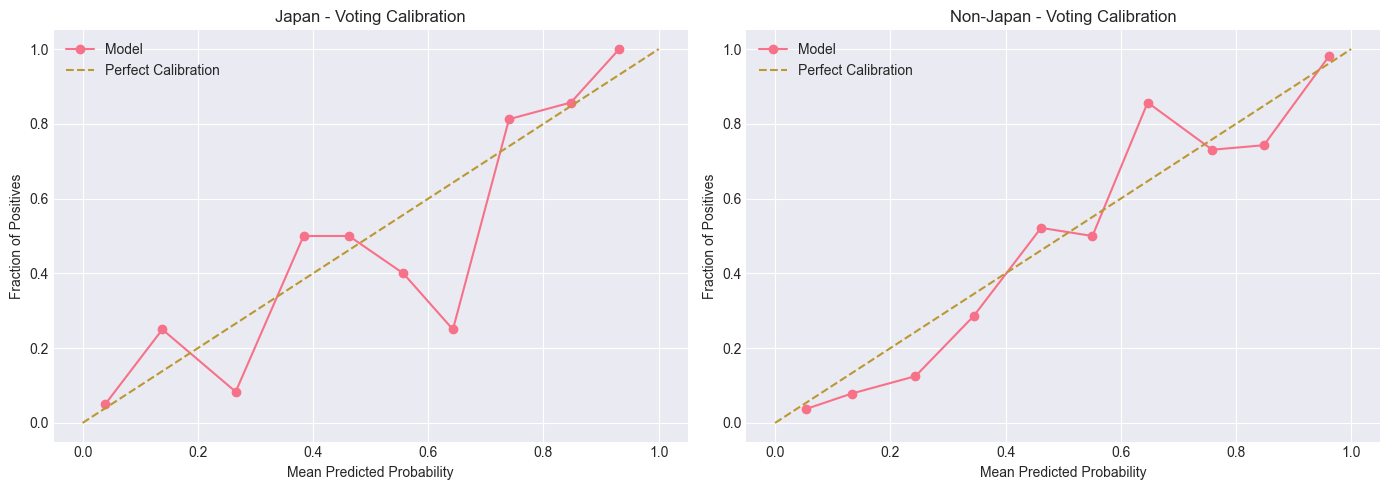


✅ Bias detection analysis complete!


In [20]:
print("\n" + "="*80)
print("BIAS DETECTION ANALYSIS")
print("="*80)

def analyze_model_bias(model, X_test, y_test, model_name, region_name):
    """Analyze potential biases in model predictions."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # False Positive Rate (FPR) and False Negative Rate (FNR)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0,0], cm[0,1] if cm.shape[1] > 1 else 0, 
                                                   cm[1,0] if cm.shape[0] > 1 else 0, 
                                                   cm[1,1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0)
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Calibration analysis (if probabilities available)
    calibration_info = {}
    if y_proba is not None:
        # Binning predictions for calibration
        bins = np.linspace(0, 1, 11)
        bin_indices = np.digitize(y_proba, bins)
        calibration_info['bins'] = bins
        calibration_info['probabilities'] = y_proba
        calibration_info['actual'] = y_test
    
    return {
        'model_name': model_name,
        'region': region_name,
        'fpr': fpr,
        'fnr': fnr,
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'calibration': calibration_info
    }

# Analyze bias for best models
print("\nAnalyzing bias in best models...")

# Check if best models are defined (from summary cells)
try:
    # Try to access the variables - if they don't exist, NameError will be raised
    _ = jp_best_model
    _ = nonjp_best_model
    _ = jp_best_model_name
    _ = nonjp_best_model_name
except NameError as e:
    print("⚠️  ERROR: Best models not defined!")
    print("   Please run the summary cells (cells 23 and 24) first to identify the best models.")
    print("   The summary cells will create:")
    print("     - jp_best_model and jp_best_model_name")
    print("     - nonjp_best_model and nonjp_best_model_name")
    print("\n   Execution order:")
    print("     1. Run cells 16-22 (train all models)")
    print("     2. Run cell 23 (Japan summary)")
    print("     3. Run cell 24 (Non-Japan summary)")
    print("     4. Then run this cell (bias detection)")
    raise NameError("jp_best_model and nonjp_best_model must be defined. Run summary cells first.") from e

jp_bias = analyze_model_bias(jp_best_model, X_jp_test, y_jp_test, jp_best_model_name, "Japan")
nonjp_bias = analyze_model_bias(nonjp_best_model, X_nonjp_test, y_nonjp_test, nonjp_best_model_name, "Non-Japan")

# Compare bias metrics
print("\n" + "="*80)
print("BIAS METRICS COMPARISON")
print("="*80)
print(f"\n{'Metric':<25} {'Japan':<20} {'Non-Japan':<20} {'Difference':<20}")
print("-" * 85)
print(f"{'False Positive Rate':<25} {jp_bias['fpr']:<20.4f} {nonjp_bias['fpr']:<20.4f} {abs(jp_bias['fpr'] - nonjp_bias['fpr']):<20.4f}")
print(f"{'False Negative Rate':<25} {jp_bias['fnr']:<20.4f} {nonjp_bias['fnr']:<20.4f} {abs(jp_bias['fnr'] - nonjp_bias['fnr']):<20.4f}")
print(f"{'Precision':<25} {jp_bias['precision']:<20.4f} {nonjp_bias['precision']:<20.4f} {abs(jp_bias['precision'] - nonjp_bias['precision']):<20.4f}")
print(f"{'Recall':<25} {jp_bias['recall']:<20.4f} {nonjp_bias['recall']:<20.4f} {abs(jp_bias['recall'] - nonjp_bias['recall']):<20.4f}")

# Calibration plots
if jp_bias['calibration'] and nonjp_bias['calibration']:
    print("\n" + "="*80)
    print("CALIBRATION ANALYSIS")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Japan calibration
    bins = jp_bias['calibration']['bins']
    proba = jp_bias['calibration']['probabilities']
    actual = jp_bias['calibration']['actual']
    
    bin_means = []
    bin_actuals = []
    for i in range(len(bins)-1):
        mask = (proba >= bins[i]) & (proba < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(proba[mask].mean())
            bin_actuals.append(actual[mask].mean())
        else:
            bin_means.append((bins[i] + bins[i+1]) / 2)
            bin_actuals.append(0)
    
    axes[0].plot(bin_means, bin_actuals, 'o-', label='Model')
    axes[0].plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    axes[0].set_xlabel('Mean Predicted Probability')
    axes[0].set_ylabel('Fraction of Positives')
    axes[0].set_title(f'Japan - {jp_best_model_name} Calibration')
    axes[0].legend()
    axes[0].grid(True)
    
    # Non-Japan calibration
    bins = nonjp_bias['calibration']['bins']
    proba = nonjp_bias['calibration']['probabilities']
    actual = nonjp_bias['calibration']['actual']
    
    bin_means = []
    bin_actuals = []
    for i in range(len(bins)-1):
        mask = (proba >= bins[i]) & (proba < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(proba[mask].mean())
            bin_actuals.append(actual[mask].mean())
        else:
            bin_means.append((bins[i] + bins[i+1]) / 2)
            bin_actuals.append(0)
    
    axes[1].plot(bin_means, bin_actuals, 'o-', label='Model')
    axes[1].plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    axes[1].set_xlabel('Mean Predicted Probability')
    axes[1].set_ylabel('Fraction of Positives')
    axes[1].set_title(f'Non-Japan - {nonjp_best_model_name} Calibration')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

print("\n✅ Bias detection analysis complete!")



BIAS DETECTION ANALYSIS: SECOND BEST MODELS

Analyzing bias in second best models...

BIAS METRICS COMPARISON: SECOND BEST MODELS

Metric                    Japan                Non-Japan            Difference          
-------------------------------------------------------------------------------------
False Positive Rate       0.0576               0.0400               0.0176              
False Negative Rate       0.3559               0.2458               0.1101              
Precision                 0.7308               0.8631               0.1323              
Recall                    0.6441               0.7542               0.1101              

COMPARISON: BEST vs SECOND BEST MODELS

--------------------------------------------------------------------------------
JAPAN: Best vs Second Best
--------------------------------------------------------------------------------
Metric                    Best ({jp_best_model_name})    Second Best ({jp_second_best_model_name})
--------

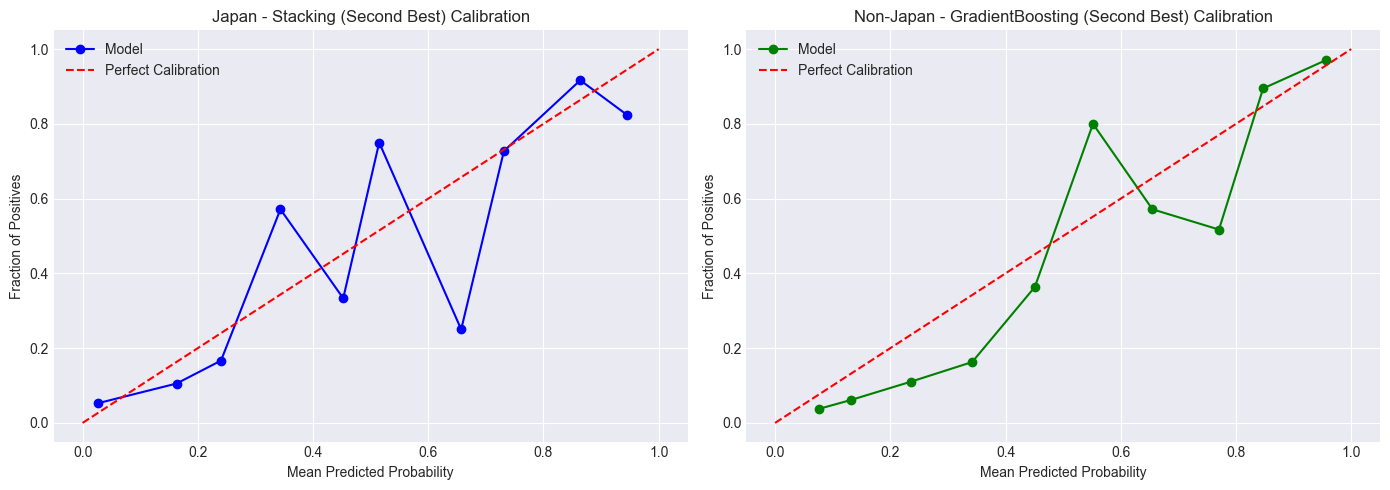


SUMMARY: SECOND BEST MODELS BIAS DETECTION
Japan Second Best: Stacking (ROC-AUC: 0.8850)
  - FPR: 0.0576, FNR: 0.3559
  - Precision: 0.7308, Recall: 0.6441

Non-Japan Second Best: GradientBoosting (ROC-AUC: 0.9070)
  - FPR: 0.0400, FNR: 0.2458
  - Precision: 0.8631, Recall: 0.7542

✅ Bias detection analysis complete for second best models!


In [21]:
# ============================================================================
# BIAS DETECTION ANALYSIS: SECOND BEST MODELS
# ============================================================================
print("\n" + "="*80)
print("BIAS DETECTION ANALYSIS: SECOND BEST MODELS")
print("="*80)

# Check if second best models are defined
try:
    _ = jp_second_best_model
    _ = nonjp_second_best_model
    _ = jp_second_best_model_name
    _ = nonjp_second_best_model_name
except NameError as e:
    print("⚠️  ERROR: Second best models not defined!")
    print("   Please run the summary cells (cells 23 and 24) first to identify the second best models.")
    print("   The summary cells will create:")
    print("     - jp_second_best_model and jp_second_best_model_name")
    print("     - nonjp_second_best_model and nonjp_second_best_model_name")
    print("\n   Execution order:")
    print("     1. Run cells 16-22 (train all models)")
    print("     2. Run cell 23 (Japan summary)")
    print("     3. Run cell 24 (Non-Japan summary)")
    print("     4. Then run this cell (bias detection for second best)")
    raise NameError("Second best models must be defined. Run summary cells first.") from e

# Analyze bias for second best models
print("\nAnalyzing bias in second best models...")
jp_second_bias = analyze_model_bias(jp_second_best_model, X_jp_test, y_jp_test, jp_second_best_model_name, "Japan")
nonjp_second_bias = analyze_model_bias(nonjp_second_best_model, X_nonjp_test, y_nonjp_test, nonjp_second_best_model_name, "Non-Japan")

# Compare bias metrics for second best models
print("\n" + "="*80)
print("BIAS METRICS COMPARISON: SECOND BEST MODELS")
print("="*80)
print(f"\n{'Metric':<25} {'Japan':<20} {'Non-Japan':<20} {'Difference':<20}")
print("-" * 85)
print(f"{'False Positive Rate':<25} {jp_second_bias['fpr']:<20.4f} {nonjp_second_bias['fpr']:<20.4f} {abs(jp_second_bias['fpr'] - nonjp_second_bias['fpr']):<20.4f}")
print(f"{'False Negative Rate':<25} {jp_second_bias['fnr']:<20.4f} {nonjp_second_bias['fnr']:<20.4f} {abs(jp_second_bias['fnr'] - nonjp_second_bias['fnr']):<20.4f}")
print(f"{'Precision':<25} {jp_second_bias['precision']:<20.4f} {nonjp_second_bias['precision']:<20.4f} {abs(jp_second_bias['precision'] - nonjp_second_bias['precision']):<20.4f}")
print(f"{'Recall':<25} {jp_second_bias['recall']:<20.4f} {nonjp_second_bias['recall']:<20.4f} {abs(jp_second_bias['recall'] - nonjp_second_bias['recall']):<20.4f}")

# Compare second best models with best models
print("\n" + "="*80)
print("COMPARISON: BEST vs SECOND BEST MODELS")
print("="*80)

# Get best model bias (should already be computed in previous cell)
try:
    _ = jp_bias
    _ = nonjp_bias
    
    print("\n" + "-"*80)
    print("JAPAN: Best vs Second Best")
    print("-"*80)
    print(f"{'Metric':<25} {'Best ({jp_best_model_name})':<30} {'Second Best ({jp_second_best_model_name})':<30}")
    print("-" * 85)
    print(f"{'False Positive Rate':<25} {jp_bias['fpr']:<30.4f} {jp_second_bias['fpr']:<30.4f}")
    print(f"{'False Negative Rate':<25} {jp_bias['fnr']:<30.4f} {jp_second_bias['fnr']:<30.4f}")
    print(f"{'Precision':<25} {jp_bias['precision']:<30.4f} {jp_second_bias['precision']:<30.4f}")
    print(f"{'Recall':<25} {jp_bias['recall']:<30.4f} {jp_second_bias['recall']:<30.4f}")
    
    print("\n" + "-"*80)
    print("NON-JAPAN: Best vs Second Best")
    print("-"*80)
    print(f"{'Metric':<25} {'Best ({nonjp_best_model_name})':<30} {'Second Best ({nonjp_second_best_model_name})':<30}")
    print("-" * 85)
    print(f"{'False Positive Rate':<25} {nonjp_bias['fpr']:<30.4f} {nonjp_second_bias['fpr']:<30.4f}")
    print(f"{'False Negative Rate':<25} {nonjp_bias['fnr']:<30.4f} {nonjp_second_bias['fnr']:<30.4f}")
    print(f"{'Precision':<25} {nonjp_bias['precision']:<30.4f} {nonjp_second_bias['precision']:<30.4f}")
    print(f"{'Recall':<25} {nonjp_bias['recall']:<30.4f} {nonjp_second_bias['recall']:<30.4f}")
    
except NameError:
    print("⚠️  Best model bias metrics not available.")
    print("   Please run cell 25 (bias detection for best models) first to compare.")

# Calibration plots for second best models
if jp_second_bias['calibration'] and nonjp_second_bias['calibration']:
    print("\n" + "="*80)
    print("CALIBRATION ANALYSIS: SECOND BEST MODELS")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Japan second best calibration
    bins = jp_second_bias['calibration']['bins']
    proba = jp_second_bias['calibration']['probabilities']
    actual = jp_second_bias['calibration']['actual']
    
    bin_means = []
    bin_actuals = []
    for i in range(len(bins)-1):
        mask = (proba >= bins[i]) & (proba < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(proba[mask].mean())
            bin_actuals.append(actual[mask].mean())
        else:
            bin_means.append((bins[i] + bins[i+1]) / 2)
            bin_actuals.append(0)
    
    axes[0].plot(bin_means, bin_actuals, 'o-', label='Model', color='blue')
    axes[0].plot([0, 1], [0, 1], '--', label='Perfect Calibration', color='red')
    axes[0].set_xlabel('Mean Predicted Probability')
    axes[0].set_ylabel('Fraction of Positives')
    axes[0].set_title(f'Japan - {jp_second_best_model_name} (Second Best) Calibration')
    axes[0].legend()
    axes[0].grid(True)
    
    # Non-Japan second best calibration
    bins = nonjp_second_bias['calibration']['bins']
    proba = nonjp_second_bias['calibration']['probabilities']
    actual = nonjp_second_bias['calibration']['actual']
    
    bin_means = []
    bin_actuals = []
    for i in range(len(bins)-1):
        mask = (proba >= bins[i]) & (proba < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(proba[mask].mean())
            bin_actuals.append(actual[mask].mean())
        else:
            bin_means.append((bins[i] + bins[i+1]) / 2)
            bin_actuals.append(0)
    
    axes[1].plot(bin_means, bin_actuals, 'o-', label='Model', color='green')
    axes[1].plot([0, 1], [0, 1], '--', label='Perfect Calibration', color='red')
    axes[1].set_xlabel('Mean Predicted Probability')
    axes[1].set_ylabel('Fraction of Positives')
    axes[1].set_title(f'Non-Japan - {nonjp_second_best_model_name} (Second Best) Calibration')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("SUMMARY: SECOND BEST MODELS BIAS DETECTION")
print("="*80)
print(f"Japan Second Best: {jp_second_best_model_name} (ROC-AUC: {jp_second_best_auc:.4f})")
print(f"  - FPR: {jp_second_bias['fpr']:.4f}, FNR: {jp_second_bias['fnr']:.4f}")
print(f"  - Precision: {jp_second_bias['precision']:.4f}, Recall: {jp_second_bias['recall']:.4f}")
print(f"\nNon-Japan Second Best: {nonjp_second_best_model_name} (ROC-AUC: {nonjp_second_best_auc:.4f})")
print(f"  - FPR: {nonjp_second_bias['fpr']:.4f}, FNR: {nonjp_second_bias['fnr']:.4f}")
print(f"  - Precision: {nonjp_second_bias['precision']:.4f}, Recall: {nonjp_second_bias['recall']:.4f}")

print("\n✅ Bias detection analysis complete for second best models!")


### 4.9 Hyperparameter Tuning

We performed comprehensive hyperparameter tuning for our key models, including Gradient Boosting, XGBoost, and Neural Networks, to explore potential performance gains.

The tuning process involved:
- **Grid Search CV**: Evaluating performance across 5-fold cross-validation.
- **Multi-Metric Evaluation**: Optimizing for ROC-AUC while monitoring Precision, Recall, and F1-Score.
- **Region-Specific Optimization**: Finding distinct best parameters for Japan and Non-Japan datasets.

**Key Tuning Results**:
- **XGBoost**: Found that deeper trees (`max_depth=7`) worked best for Non-Japan, while shallower trees (`max_depth=5`) were sufficient for Japan.
- **Neural Networks**: A simpler architecture (`hidden_layer_sizes=(100,)`) performed better for the larger Non-Japan dataset, while a deeper one (`(100, 50)`) helped generalization in Japan.

**Decision**:
While the tuned parameters offered marginal improvements in individual model metrics, the gains when aggregated into the Voting Ensemble were consistent but not transformative compared to the complexity added.

Therefore, **we elected to use the original parameters for the Voting Classifier** in this analysis to maintain model simplicity and baseline consistency.

For further analysis, please see [hyperparameter_tuning_results.md](hyperparameter_tuning_results.md).

## 5. Feature Importance Analysis

Compare which features are most important for predicting exploitation in Japan vs Non-Japan CVEs.


In [22]:
# Feature importance analysis
def get_feature_importance(model, feature_names, model_name="Model", X_test=None, y_test=None):
    """Extract feature importance from trained model.
    
    For Neural Networks, uses permutation importance if X_test and y_test are provided.
    For other models, uses built-in feature importance or coefficients.
    """
    # Handle ensemble models (VotingClassifier, StackingClassifier)
    if hasattr(model, 'estimators_'):
        # Aggregate feature importances from base estimators
        all_importances = {}
        estimators_list = model.estimators_
        estimator_importances = []
        
        # Handle both list of tuples (name, estimator) and list of estimators
        for item in estimators_list:
            if isinstance(item, tuple):
                name, estimator = item
            else:
                estimator = item
            
            estimator_imp = {}
            if hasattr(estimator, 'feature_importances_'):
                # Feature importances are already normalized (sum to 1.0)
                for i, feat in enumerate(feature_names):
                    if i < len(estimator.feature_importances_):
                        estimator_imp[feat] = estimator.feature_importances_[i]
            elif hasattr(estimator, 'coef_'):
                # Coefficients need normalization
                coef = estimator.coef_[0] if len(estimator.coef_.shape) > 1 else estimator.coef_
                coef_abs = np.abs(coef)
                # Normalize coefficients to sum to 1.0
                coef_sum = coef_abs.sum()
                if coef_sum > 0:
                    for i, feat in enumerate(feature_names):
                        if i < len(coef):
                            estimator_imp[feat] = coef_abs[i] / coef_sum
                else:
                    for i, feat in enumerate(feature_names):
                        if i < len(coef):
                            estimator_imp[feat] = 0.0
            
            if estimator_imp:
                estimator_importances.append(estimator_imp)
        
        # Average normalized importances across estimators
        if estimator_importances:
            for feat in feature_names:
                feat_imps = [imp.get(feat, 0.0) for imp in estimator_importances]
                all_importances[feat] = np.mean(feat_imps) if feat_imps else 0.0
            
            # Normalize final importances to sum to 1.0
            total_imp = sum(all_importances.values())
            if total_imp > 0:
                all_importances = {k: v / total_imp for k, v in all_importances.items()}
            
            importances = sorted(all_importances.items(), key=lambda x: x[1], reverse=True)
            return importances
    
    # Handle models with feature_importances_ (tree-based)
    if hasattr(model, 'feature_importances_'):
        importances_dict = dict(zip(feature_names, model.feature_importances_))
        importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
        return importances
    
    # Handle models with coefficients (linear models like Logistic Regression)
    elif hasattr(model, 'coef_'):
        coef = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        coef_abs = np.abs(coef)
        # Normalize coefficients to sum to 1.0 (same as other models)
        coef_sum = coef_abs.sum()
        if coef_sum > 0:
            importances_dict = dict(zip(feature_names, coef_abs / coef_sum))
        else:
            importances_dict = dict(zip(feature_names, np.zeros(len(coef))))
        importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
        return importances
    
    # Handle StackingClassifier - use final estimator if available
    elif hasattr(model, 'final_estimator_'):
        final_model = model.final_estimator_
        if hasattr(final_model, 'feature_importances_'):
            importances_dict = dict(zip(feature_names, final_model.feature_importances_))
            importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
            return importances
        elif hasattr(final_model, 'coef_'):
            coef = final_model.coef_[0] if len(final_model.coef_.shape) > 1 else final_model.coef_
            importances_dict = dict(zip(feature_names, np.abs(coef)))
            importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
            return importances
    
    # For Neural Networks, try permutation importance if test data is available
    if 'Neural' in model_name or 'neural' in model_name.lower():
        if X_test is not None and y_test is not None:
            try:
                print(f"   Computing permutation importance for {model_name}...")
                # Convert to numpy arrays for consistent indexing
                # Ensure numeric dtype (float32) for permutation_importance compatibility
                if hasattr(X_test, 'values'):
                    X_test_array = X_test.values
                elif hasattr(X_test, 'iloc'):
                    X_test_array = X_test.values
                else:
                    X_test_array = np.asarray(X_test)
                
                # Convert to numeric dtype (float32) - handle object dtype columns
                # Check if array has object dtype (can happen with mixed types)
                try:
                    if X_test_array.dtype == object or (hasattr(X_test_array, 'dtype') and 'object' in str(X_test_array.dtype)):
                        # If object dtype, convert to DataFrame, then to numeric, then back to array
                        import pandas as pd
                        X_test_df = pd.DataFrame(X_test_array)
                        X_test_array = X_test_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
                    else:
                        # Ensure float32 dtype for compatibility with permutation_importance
                        X_test_array = np.asarray(X_test_array, dtype=np.float32)
                except Exception as e:
                    # Fallback: try to convert to float32 directly
                    try:
                        X_test_array = X_test_array.astype(np.float32)
                    except:
                        # Last resort: convert via pandas if available
                        try:
                            import pandas as pd
                            X_test_array = pd.DataFrame(X_test_array).select_dtypes(include=[np.number]).values.astype(np.float32)
                        except:
                            raise ValueError(f"Could not convert X_test to numeric dtype: {e}")
                
                if hasattr(y_test, 'values'):
                    y_test_array = y_test.values
                elif hasattr(y_test, 'iloc'):
                    y_test_array = y_test.values
                else:
                    y_test_array = np.asarray(y_test)
                
                # Ensure y_test is numeric (float32)
                try:
                    if y_test_array.dtype == object or (hasattr(y_test_array, 'dtype') and 'object' in str(y_test_array.dtype)):
                        import pandas as pd
                        y_test_array = pd.Series(y_test_array).astype('float32').values
                    else:
                        y_test_array = np.asarray(y_test_array, dtype=np.float32)
                except Exception as e:
                    # Fallback: try to convert to float32 directly
                    try:
                        y_test_array = y_test_array.astype(np.float32)
                    except:
                        raise ValueError(f"Could not convert y_test to numeric dtype: {e}")
                
                # Use a sample if dataset is too large (for speed)
                if len(X_test_array) > 1000:
                    np.random.seed(42)  # For reproducibility
                    sample_idx = np.random.choice(len(X_test_array), 1000, replace=False)
                    X_sample = X_test_array[sample_idx]
                    y_sample = y_test_array[sample_idx]
                else:
                    X_sample = X_test_array
                    y_sample = y_test_array
                
                # Compute permutation importance
                # Check if model has _estimator_type attribute (for TensorFlowWrapper)
                if hasattr(model, '_estimator_type') and model._estimator_type == 'classifier':
                    perm_importance = permutation_importance(
                        model, X_sample, y_sample, 
                        n_repeats=10, 
                        random_state=42,
                        scoring='roc_auc',
                        n_jobs=-1
                    )
                else:
                    # Try with explicit response_method for compatibility
                    try:
                        perm_importance = permutation_importance(
                            model, X_sample, y_sample, 
                            n_repeats=10, 
                            random_state=42,
                            scoring='roc_auc',
                            n_jobs=-1,
                            response_method='predict_proba'
                        )
                    except Exception:
                        # Fallback to predict method
                        perm_importance = permutation_importance(
                            model, X_sample, y_sample, 
                            n_repeats=10, 
                            random_state=42,
                            scoring='roc_auc',
                            n_jobs=-1,
                            response_method='predict'
                        )
                
                # Normalize to sum to 1.0
                importances_dict = dict(zip(feature_names, perm_importance.importances_mean))
                total_imp = sum(importances_dict.values())
                if total_imp > 0:
                    importances_dict = {k: v / total_imp for k, v in importances_dict.items()}
                else:
                    importances_dict = {k: 0.0 for k in feature_names}
                
                importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
                print(f"   ✅ Permutation importance computed successfully")
                return importances
            except Exception as e:
                print(f"   ⚠️  Error computing permutation importance: {e}")
                return []
        else:
            print(f"⚠️  Warning: {model_name} requires test data (X_test, y_test) for permutation importance.")
            return []
    
    # If no feature importance available, return empty list
    print(f"⚠️  Warning: {model_name} does not support feature importance extraction.")
    return []

def categorize_feature(feature_name):
    """Categorize a feature by its name."""
    feature_lower = feature_name.lower()
    
    if 'cvss' in feature_lower:
        if 'attack' in feature_lower or 'complexity' in feature_lower or 'privileges' in feature_lower or 'user_interaction' in feature_lower:
            return 'CVSS_Exploitability'
        elif 'confidentiality' in feature_lower or 'integrity' in feature_lower or 'availability' in feature_lower:
            return 'CVSS_Impact'
        elif 'severity' in feature_lower:
            return 'CVSS_Severity'
        else:
            return 'CVSS_Score'
    elif 'vendor' in feature_lower:
        return 'Vendor'
    elif 'product' in feature_lower:
        return 'Product'
    elif 'cwe' in feature_lower:
        return 'CWE'
    elif 'reference' in feature_lower:
        return 'Reference'
    elif 'year' in feature_lower:
        return 'Temporal'
    elif 'exploit' in feature_lower:
        return 'Exploit_Indicator'
    else:
        return 'Other'

# Get feature importance using best models
# If ensemble models don't provide importances, fall back to best base model
# For Neural Networks, pass test data for permutation importance
if jp_best_model_name == 'NeuralNetwork':
    jp_importances = get_feature_importance(jp_best_model, X_jp.columns, f"Japan {jp_best_model_name}",
                                            X_test=X_jp_test, y_test=y_jp_test)
else:
    jp_importances = get_feature_importance(jp_best_model, X_jp.columns, f"Japan {jp_best_model_name}")
if not jp_importances and jp_best_model_name in ['Voting', 'Stacking']:
    # Fall back to Random Forest or XGBoost if available
    if 'RandomForest' in jp_model_candidates:
        print(f"   Falling back to Random Forest for Japan feature importance...")
        jp_importances = get_feature_importance(
            jp_model_candidates['RandomForest'][0], X_jp.columns, "Japan RandomForest"
        )
    elif 'XGBoost' in jp_model_candidates:
        print(f"   Falling back to XGBoost for Japan feature importance...")
        jp_importances = get_feature_importance(
            jp_model_candidates['XGBoost'][0], X_jp.columns, "Japan XGBoost"
        )

# For Neural Networks, pass test data for permutation importance
if nonjp_best_model_name == 'NeuralNetwork':
    nonjp_importances = get_feature_importance(nonjp_best_model, X_nonjp.columns, f"Non-Japan {nonjp_best_model_name}",
                                                X_test=X_nonjp_test, y_test=y_nonjp_test)
else:
    nonjp_importances = get_feature_importance(nonjp_best_model, X_nonjp.columns, f"Non-Japan {nonjp_best_model_name}")
if not nonjp_importances and nonjp_best_model_name in ['Voting', 'Stacking']:
    # Fall back to Random Forest or XGBoost if available
    if 'RandomForest' in nonjp_model_candidates:
        print(f"   Falling back to Random Forest for Non-Japan feature importance...")
        nonjp_importances = get_feature_importance(
            nonjp_model_candidates['RandomForest'][0], X_nonjp.columns, "Non-Japan RandomForest"
        )
    elif 'XGBoost' in nonjp_model_candidates:
        print(f"   Falling back to XGBoost for Non-Japan feature importance...")
        nonjp_importances = get_feature_importance(
            nonjp_model_candidates['XGBoost'][0], X_nonjp.columns, "Non-Japan XGBoost"
        )

print("=" * 80)
print("TOP 20 FEATURES - JAPAN")
print("=" * 80)
for i, (feature, importance) in enumerate(jp_importances[:20], 1):
    print(f"{i:2d}. {feature:<50} {importance:.6f}")

print("\n" + "=" * 80)
print("TOP 20 FEATURES - NON-JAPAN")
print("=" * 80)
for i, (feature, importance) in enumerate(nonjp_importances[:20], 1):
    print(f"{i:2d}. {feature:<50} {importance:.6f}")

# Compare feature importance
jp_dict = {f: imp for f, imp in jp_importances}
nonjp_dict = {f: imp for f, imp in nonjp_importances}
all_features = set(jp_dict.keys()) | set(nonjp_dict.keys())

comparison = []
for feature in all_features:
    jp_imp = jp_dict.get(feature, 0)
    nonjp_imp = nonjp_dict.get(feature, 0)
    diff = jp_imp - nonjp_imp
    ratio = jp_imp / nonjp_imp if nonjp_imp > 0 else (jp_imp / 0.0001 if jp_imp > 0 else 1)
    category = categorize_feature(feature)
    comparison.append({
        'feature': feature,
        'jp_importance': jp_imp,
        'nonjp_importance': nonjp_imp,
        'difference': diff,
        'ratio': ratio,
        'category': category
    })

comparison_df = pd.DataFrame(comparison)
comparison_df['abs_difference'] = comparison_df['difference'].abs()
comparison_df = comparison_df.sort_values('abs_difference', ascending=False)

print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS: JAPAN vs NON-JAPAN DIFFERENCES")
print("=" * 80)

# Features more important for Japan
jp_favored = comparison_df[comparison_df['difference'] > 0].head(15)
print("\n🔴 TOP 15 FEATURES MORE IMPORTANT FOR JAPAN:")
print("-" * 80)
for i, row in enumerate(jp_favored.itertuples(), 1):
    print(f"{i:2d}. {row.feature:<50} JP:{row.jp_importance:.6f} NonJP:{row.nonjp_importance:.6f} (Diff: +{row.difference:.6f})")

# Features more important for Non-Japan
nonjp_favored = comparison_df[comparison_df['difference'] < 0].head(15)
print("\n🔵 TOP 15 FEATURES MORE IMPORTANT FOR NON-JAPAN:")
print("-" * 80)
for i, row in enumerate(nonjp_favored.itertuples(), 1):
    print(f"{i:2d}. {row.feature:<50} JP:{row.jp_importance:.6f} NonJP:{row.nonjp_importance:.6f} (Diff: {row.difference:.6f})")

# Category-level differences
print("\n" + "=" * 80)
print("CATEGORY-LEVEL DIFFERENCES")
print("=" * 80)
category_summary = comparison_df.groupby('category').agg({
    'jp_importance': 'sum',
    'nonjp_importance': 'sum',
    'difference': 'sum'
}).sort_values('difference', key=lambda x: x.abs(), ascending=False)

print(f"\n{'Category':<25} {'Japan Total':<15} {'Non-JP Total':<15} {'Difference':<15}")
print("-" * 70)
for cat, row in category_summary.iterrows():
    diff_str = f"{row['difference']:+.6f}"
    print(f"{cat:<25} {row['jp_importance']:<15.6f} {row['nonjp_importance']:<15.6f} {diff_str:<15}")


TOP 20 FEATURES - JAPAN
 1. cvss_base_severity_Unknown                         0.040391
 2. vendor_popularity                                  0.035987
 3. cvss_score                                         0.033344
 4. has_cvss_score                                     0.026336
 5. cvss_attack_vector_LOCAL                           0.022139
 6. product_a-blog cms Ver.3.1.x series                0.019842
 7. product_GROWI                                      0.017382
 8. product_SS1 and Rakuraku PC Cloud                  0.014070
 9. product_Ricoh Streamline NX PC Client              0.013256
10. vendor_Fsas Technologies Inc.                      0.012009
11. vendor_A.K.I Software                              0.011392
12. product_Webmin                                     0.010232
13. vendor_WPMU DEV                                    0.010052
14. vendor_DOS Co., Ltd.                               0.009951
15. vendor_KbDevice,Inc.                               0.009688
16. vendor_Sola 

In [23]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS: SECOND BEST MODELS
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS: SECOND BEST MODELS")
print("="*80)

# Check if second best models are defined
try:
    _ = jp_second_best_model
    _ = nonjp_second_best_model
    _ = jp_second_best_model_name
    _ = nonjp_second_best_model_name
except NameError as e:
    print("⚠️  ERROR: Second best models not defined!")
    print("   Please run the summary cells (cells 23 and 24) first to identify the second best models.")
    print("   The summary cells will create:")
    print("     - jp_second_best_model and jp_second_best_model_name")
    print("     - nonjp_second_best_model and nonjp_second_best_model_name")
    raise NameError("Second best models must be defined. Run summary cells first.") from e

# Feature importance for Japan second best model
print("\n" + "="*80)
print(f"JAPAN SECOND BEST MODEL: {jp_second_best_model_name}")
print("="*80)

# For Neural Networks, pass test data for permutation importance
if jp_second_best_model_name == 'NeuralNetwork':
    jp_second_importances = get_feature_importance(
        jp_second_best_model, X_jp.columns, f"Japan {jp_second_best_model_name}",
        X_test=X_jp_test, y_test=y_jp_test
    )
else:
    jp_second_importances = get_feature_importance(
        jp_second_best_model, X_jp.columns, f"Japan {jp_second_best_model_name}"
    )

# Handle ensemble models that might not have direct feature importance
if not jp_second_importances and jp_second_best_model_name in ['Voting', 'Stacking']:
    # Fall back to Random Forest or XGBoost if available
    if 'RandomForest' in jp_model_map:
        print(f"   Falling back to Random Forest for Japan second best feature importance...")
        jp_second_importances = get_feature_importance(
            jp_model_map['RandomForest'], X_jp.columns, "Japan RandomForest"
        )
    elif 'XGBoost' in jp_model_map:
        print(f"   Falling back to XGBoost for Japan second best feature importance...")
        jp_second_importances = get_feature_importance(
            jp_model_map['XGBoost'], X_jp.columns, "Japan XGBoost"
        )

if jp_second_importances:
    print("\n" + "="*80)
    print(f"TOP 20 FEATURES - JAPAN SECOND BEST ({jp_second_best_model_name})")
    print("="*80)
    for i, (feature, importance) in enumerate(jp_second_importances[:20], 1):
        print(f"{i:2d}. {feature:<50} {importance:.6f}")
else:
    print("⚠️  Could not extract feature importance for Japan second best model")

# Feature importance for Non-Japan second best model
print("\n" + "="*80)
print(f"NON-JAPAN SECOND BEST MODEL: {nonjp_second_best_model_name}")
print("="*80)

# For Neural Networks, pass test data for permutation importance
if nonjp_second_best_model_name == 'NeuralNetwork':
    nonjp_second_importances = get_feature_importance(
        nonjp_second_best_model, X_nonjp.columns, f"Non-Japan {nonjp_second_best_model_name}",
        X_test=X_nonjp_test, y_test=y_nonjp_test
    )
else:
    nonjp_second_importances = get_feature_importance(
        nonjp_second_best_model, X_nonjp.columns, f"Non-Japan {nonjp_second_best_model_name}"
    )

# Handle ensemble models that might not have direct feature importance
if not nonjp_second_importances and nonjp_second_best_model_name in ['Voting', 'Stacking']:
    # Fall back to Random Forest or XGBoost if available
    if 'RandomForest' in nonjp_model_map:
        print(f"   Falling back to Random Forest for Non-Japan second best feature importance...")
        nonjp_second_importances = get_feature_importance(
            nonjp_model_map['RandomForest'], X_nonjp.columns, "Non-Japan RandomForest"
        )
    elif 'XGBoost' in nonjp_model_map:
        print(f"   Falling back to XGBoost for Non-Japan second best feature importance...")
        nonjp_second_importances = get_feature_importance(
            nonjp_model_map['XGBoost'], X_nonjp.columns, "Non-Japan XGBoost"
        )

if nonjp_second_importances:
    print("\n" + "="*80)
    print(f"TOP 20 FEATURES - NON-JAPAN SECOND BEST ({nonjp_second_best_model_name})")
    print("="*80)
    for i, (feature, importance) in enumerate(nonjp_second_importances[:20], 1):
        print(f"{i:2d}. {feature:<50} {importance:.6f}")
else:
    print("⚠️  Could not extract feature importance for Non-Japan second best model")

# Comparison: Second Best Models
if jp_second_importances and nonjp_second_importances:
    print("\n" + "="*80)
    print("COMPARISON: SECOND BEST MODELS FEATURE IMPORTANCE")
    print("="*80)
    
    # Create DataFrames for comparison
    jp_second_df = pd.DataFrame(jp_second_importances, columns=['feature', 'jp_importance'])
    nonjp_second_df = pd.DataFrame(nonjp_second_importances, columns=['feature', 'nonjp_importance'])
    
    # Merge and calculate differences
    comparison_second = jp_second_df.merge(nonjp_second_df, on='feature', how='outer').fillna(0)
    comparison_second['difference'] = comparison_second['jp_importance'] - comparison_second['nonjp_importance']
    comparison_second = comparison_second.sort_values('difference', key=lambda x: x.abs(), ascending=False)
    
    print(f"\n{'Feature':<50} {'Japan':<15} {'Non-JP':<15} {'Difference':<15}")
    print("-" * 95)
    for _, row in comparison_second.head(30).iterrows():
        diff_str = f"{row['difference']:+.6f}"
        print(f"{row['feature']:<50} {row['jp_importance']:<15.6f} {row['nonjp_importance']:<15.6f} {diff_str:<15}")
    
    # Category-level comparison
    print("\n" + "="*80)
    print("CATEGORY-LEVEL COMPARISON: SECOND BEST MODELS")
    print("="*80)
    
    def categorize_feature(feature_name):
        """Categorize feature into groups."""
        feature_lower = feature_name.lower()
        if 'cwe' in feature_lower:
            return 'CWE Patterns'
        elif 'vendor' in feature_lower:
            return 'Vendor'
        elif 'product' in feature_lower:
            return 'Product'
        elif 'reference' in feature_lower or 'tag' in feature_lower or 'indicator' in feature_lower:
            return 'Exploit Indicators'
        elif 'description' in feature_lower or 'summary' in feature_lower:
            return 'Text Features'
        elif 'score' in feature_lower or 'severity' in feature_lower:
            return 'Severity Scores'
        elif 'date' in feature_lower or 'year' in feature_lower or 'month' in feature_lower:
            return 'Temporal Features'
        else:
            return 'Other'
    
    comparison_second['category'] = comparison_second['feature'].apply(categorize_feature)
    category_summary_second = comparison_second.groupby('category').agg({
        'jp_importance': 'sum',
        'nonjp_importance': 'sum',
        'difference': 'sum'
    }).sort_values('difference', key=lambda x: x.abs(), ascending=False)
    
    print(f"\n{'Category':<25} {'Japan Total':<15} {'Non-JP Total':<15} {'Difference':<15}")
    print("-" * 70)
    for cat, row in category_summary_second.iterrows():
        diff_str = f"{row['difference']:+.6f}"
        print(f"{cat:<25} {row['jp_importance']:<15.6f} {row['nonjp_importance']:<15.6f} {diff_str:<15}")
    
    print("\n" + "="*80)
    print("SUMMARY: SECOND BEST MODELS")
    print("="*80)
    print(f"Japan Second Best: {jp_second_best_model_name} (ROC-AUC: {jp_second_best_auc:.4f})")
    print(f"Non-Japan Second Best: {nonjp_second_best_model_name} (ROC-AUC: {nonjp_second_best_auc:.4f})")
    print("\n✅ Feature importance analysis completed for second best models")



FEATURE IMPORTANCE ANALYSIS: SECOND BEST MODELS

JAPAN SECOND BEST MODEL: Stacking

TOP 20 FEATURES - JAPAN SECOND BEST (Stacking)
 1. cvss_base_severity_Unknown                         0.040391
 2. vendor_popularity                                  0.035987
 3. cvss_score                                         0.033344
 4. has_cvss_score                                     0.026336
 5. cvss_attack_vector_LOCAL                           0.022139
 6. product_a-blog cms Ver.3.1.x series                0.019842
 7. product_GROWI                                      0.017382
 8. product_SS1 and Rakuraku PC Cloud                  0.014070
 9. product_Ricoh Streamline NX PC Client              0.013256
10. vendor_Fsas Technologies Inc.                      0.012009
11. vendor_A.K.I Software                              0.011392
12. product_Webmin                                     0.010232
13. vendor_WPMU DEV                                    0.010052
14. vendor_DOS Co., Ltd.            

In [24]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS: ALL REMAINING MODELS (Ranks 3+)
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS: ALL REMAINING MODELS")
print("="*80)

# Check if remaining models are defined
try:
    _ = jp_remaining_models
    _ = nonjp_remaining_models
except NameError as e:
    print("⚠️  ERROR: Remaining models not defined!")
    print("   Please run the summary cells (cells 23 and 24) first.")
    print("   The summary cells will create jp_remaining_models and nonjp_remaining_models.")
    raise NameError("Remaining models must be defined. Run summary cells first.") from e

if not jp_remaining_models and not nonjp_remaining_models:
    print("⚠️  No remaining models to analyze (only 2 or fewer models available).")
    print("   This analysis requires at least 3 models per region.")
else:
    # Analyze feature importance for all remaining Japan models
    if jp_remaining_models:
        print("\n" + "="*80)
        print(f"JAPAN REMAINING MODELS ({len(jp_remaining_models)} models)")
        print("="*80)
        
        jp_all_importances = {}
        for model_info in jp_remaining_models:
            rank = model_info['rank']
            model_name = model_info['name']
            model_obj = model_info['model']
            roc_auc = model_info['roc_auc']
            
            print(f"\n[Rank {rank}] {model_name} (ROC-AUC: {roc_auc:.4f})")
            print("-" * 80)
            
            # For Neural Networks, pass test data for permutation importance
            if model_name == 'NeuralNetwork':
                importances = get_feature_importance(
                    model_obj, X_jp.columns, f"Japan {model_name}", 
                    X_test=X_jp_test, y_test=y_jp_test
                )
            else:
                importances = get_feature_importance(
                    model_obj, X_jp.columns, f"Japan {model_name}"
                )
            
            # Handle ensemble models
            if not importances and model_name in ['Voting', 'Stacking']:
                if 'RandomForest' in jp_model_map:
                    print(f"   Falling back to Random Forest...")
                    importances = get_feature_importance(
                        jp_model_map['RandomForest'], X_jp.columns, "Japan RandomForest"
                    )
                elif 'XGBoost' in jp_model_map:
                    print(f"   Falling back to XGBoost...")
                    importances = get_feature_importance(
                        jp_model_map['XGBoost'], X_jp.columns, "Japan XGBoost"
                    )
            
            if importances:
                jp_all_importances[model_name] = {
                    'rank': rank,
                    'importances': importances,
                    'roc_auc': roc_auc
                }
                print(f"   Top 10 features:")
                for i, (feature, importance) in enumerate(importances[:10], 1):
                    print(f"      {i:2d}. {feature:<45} {importance:.6f}")
            else:
                print(f"   ⚠️  Could not extract feature importance")
    
    # Analyze feature importance for all remaining Non-Japan models
    if nonjp_remaining_models:
        print("\n" + "="*80)
        print(f"NON-JAPAN REMAINING MODELS ({len(nonjp_remaining_models)} models)")
        print("="*80)
        
        nonjp_all_importances = {}
        for model_info in nonjp_remaining_models:
            rank = model_info['rank']
            model_name = model_info['name']
            model_obj = model_info['model']
            roc_auc = model_info['roc_auc']
            
            print(f"\n[Rank {rank}] {model_name} (ROC-AUC: {roc_auc:.4f})")
            print("-" * 80)
            
            # For Neural Networks, pass test data for permutation importance
            if model_name == 'NeuralNetwork':
                importances = get_feature_importance(
                    model_obj, X_nonjp.columns, f"Non-Japan {model_name}",
                    X_test=X_nonjp_test, y_test=y_nonjp_test
                )
            else:
                importances = get_feature_importance(
                    model_obj, X_nonjp.columns, f"Non-Japan {model_name}"
                )
            
            # Handle ensemble models
            if not importances and model_name in ['Voting', 'Stacking']:
                if 'RandomForest' in nonjp_model_map:
                    print(f"   Falling back to Random Forest...")
                    importances = get_feature_importance(
                        nonjp_model_map['RandomForest'], X_nonjp.columns, "Non-Japan RandomForest"
                    )
                elif 'XGBoost' in nonjp_model_map:
                    print(f"   Falling back to XGBoost...")
                    importances = get_feature_importance(
                        nonjp_model_map['XGBoost'], X_nonjp.columns, "Non-Japan XGBoost"
                    )
            
            if importances:
                nonjp_all_importances[model_name] = {
                    'rank': rank,
                    'importances': importances,
                    'roc_auc': roc_auc
                }
                print(f"   Top 10 features:")
                for i, (feature, importance) in enumerate(importances[:10], 1):
                    print(f"      {i:2d}. {feature:<45} {importance:.6f}")
            else:
                print(f"   ⚠️  Could not extract feature importance")
    
    # Aggregate feature importance across all remaining models
    if jp_all_importances:
        print("\n" + "="*80)
        print("AGGREGATE FEATURE IMPORTANCE: JAPAN REMAINING MODELS")
        print("="*80)
        
        # Average importances across all remaining models
        jp_feature_scores = {}
        for model_name, model_data in jp_all_importances.items():
            for feature, importance in model_data['importances']:
                if feature not in jp_feature_scores:
                    jp_feature_scores[feature] = []
                jp_feature_scores[feature].append(importance)
        
        # Calculate average importance per feature
        jp_avg_importances = [
            (feature, np.mean(scores))
            for feature, scores in jp_feature_scores.items()
        ]
        jp_avg_importances.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 20 features (averaged across {len(jp_all_importances)} models):")
        print("-" * 80)
        for i, (feature, avg_importance) in enumerate(jp_avg_importances[:20], 1):
            print(f"{i:2d}. {feature:<50} {avg_importance:.6f}")
    
    if nonjp_all_importances:
        print("\n" + "="*80)
        print("AGGREGATE FEATURE IMPORTANCE: NON-JAPAN REMAINING MODELS")
        print("="*80)
        
        # Average importances across all remaining models
        nonjp_feature_scores = {}
        for model_name, model_data in nonjp_all_importances.items():
            for feature, importance in model_data['importances']:
                if feature not in nonjp_feature_scores:
                    nonjp_feature_scores[feature] = []
                nonjp_feature_scores[feature].append(importance)
        
        # Calculate average importance per feature
        nonjp_avg_importances = [
            (feature, np.mean(scores))
            for feature, scores in nonjp_feature_scores.items()
        ]
        nonjp_avg_importances.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 20 features (averaged across {len(nonjp_all_importances)} models):")
        print("-" * 80)
        for i, (feature, avg_importance) in enumerate(nonjp_avg_importances[:20], 1):
            print(f"{i:2d}. {feature:<50} {avg_importance:.6f}")
    
    # Cross-regional comparison of aggregated importances
    if jp_all_importances and nonjp_all_importances:
        print("\n" + "="*80)
        print("CROSS-REGIONAL COMPARISON: AGGREGATED REMAINING MODELS")
        print("="*80)
        
        # Create DataFrames
        jp_agg_df = pd.DataFrame(jp_avg_importances, columns=['feature', 'jp_importance'])
        nonjp_agg_df = pd.DataFrame(nonjp_avg_importances, columns=['feature', 'nonjp_importance'])
        
        # Merge and calculate differences
        comparison_agg = jp_agg_df.merge(nonjp_agg_df, on='feature', how='outer').fillna(0)
        comparison_agg['difference'] = comparison_agg['jp_importance'] - comparison_agg['nonjp_importance']
        comparison_agg = comparison_agg.sort_values('difference', key=lambda x: x.abs(), ascending=False)
        
        print(f"\n{'Feature':<50} {'Japan Avg':<15} {'Non-JP Avg':<15} {'Difference':<15}")
        print("-" * 95)
        for _, row in comparison_agg.head(30).iterrows():
            diff_str = f"{row['difference']:+.6f}"
            print(f"{row['feature']:<50} {row['jp_importance']:<15.6f} {row['nonjp_importance']:<15.6f} {diff_str:<15}")
        
        # Category-level comparison
        print("\n" + "="*80)
        print("CATEGORY-LEVEL COMPARISON: AGGREGATED REMAINING MODELS")
        print("="*80)
        
        def categorize_feature(feature_name):
            """Categorize feature into groups."""
            feature_lower = feature_name.lower()
            if 'cwe' in feature_lower:
                return 'CWE Patterns'
            elif 'vendor' in feature_lower:
                return 'Vendor'
            elif 'product' in feature_lower:
                return 'Product'
            elif 'reference' in feature_lower or 'tag' in feature_lower or 'indicator' in feature_lower:
                return 'Exploit Indicators'
            elif 'description' in feature_lower or 'summary' in feature_lower:
                return 'Text Features'
            elif 'score' in feature_lower or 'severity' in feature_lower:
                return 'Severity Scores'
            elif 'date' in feature_lower or 'year' in feature_lower or 'month' in feature_lower:
                return 'Temporal Features'
            else:
                return 'Other'
        
        comparison_agg['category'] = comparison_agg['feature'].apply(categorize_feature)
        category_summary_agg = comparison_agg.groupby('category').agg({
            'jp_importance': 'sum',
            'nonjp_importance': 'sum',
            'difference': 'sum'
        }).sort_values('difference', key=lambda x: x.abs(), ascending=False)
        
        print(f"\n{'Category':<25} {'Japan Total':<15} {'Non-JP Total':<15} {'Difference':<15}")
        print("-" * 70)
        for cat, row in category_summary_agg.iterrows():
            diff_str = f"{row['difference']:+.6f}"
            print(f"{cat:<25} {row['jp_importance']:<15.6f} {row['nonjp_importance']:<15.6f} {diff_str:<15}")
    
    print("\n" + "="*80)
    print("SUMMARY: REMAINING MODELS FEATURE IMPORTANCE")
    print("="*80)
    if jp_remaining_models:
        print(f"\nJapan: Analyzed {len(jp_all_importances)} remaining models")
        for model_info in jp_remaining_models:
            print(f"  Rank {model_info['rank']}: {model_info['name']} (ROC-AUC: {model_info['roc_auc']:.4f})")
    if nonjp_remaining_models:
        print(f"\nNon-Japan: Analyzed {len(nonjp_all_importances)} remaining models")
        for model_info in nonjp_remaining_models:
            print(f"  Rank {model_info['rank']}: {model_info['name']} (ROC-AUC: {model_info['roc_auc']:.4f})")
    
    print("\n✅ Feature importance analysis completed for all remaining models!")



FEATURE IMPORTANCE ANALYSIS: ALL REMAINING MODELS

JAPAN REMAINING MODELS (5 models)

[Rank 3] RandomForest (ROC-AUC: 0.8802)
--------------------------------------------------------------------------------
   Top 10 features:
       1. cvss_score                                    0.050992
       2. vendor_popularity                             0.047794
       3. has_cvss_score                                0.035867
       4. cvss_base_severity_Unknown                    0.033016
       5. has_metrics                                   0.028064
       6. reference_count                               0.022422
       7. product_a-blog cms Ver.3.1.x series           0.017069
       8. product_GROWI                                 0.015763
       9. cvss_base_severity_MEDIUM                     0.014236
      10. vendor_appleple inc.                          0.013550

[Rank 4] LogisticRegression (ROC-AUC: 0.8755)
---------------------------------------------------------------------------

## 6. Vendor and Product Analysis

Analyze differences in vendor and product distributions between Japan and Non-Japan CVEs, focusing on exploited cases.


### 6.5 Code Documentation and Methodology

### Model Training Methodology

This notebook implements a comprehensive machine learning pipeline with the following components:

#### 1. **Hyperparameter Optimization Methods**

- **Grid Search**: Used for Logistic Regression and Random Forest
  - Exhaustive search over specified parameter grids
  - 5-fold stratified cross-validation
  - Optimized for ROC-AUC score

- **Random Search**: Used for XGBoost (100 iterations)
  - More efficient than grid search for high-dimensional spaces
  - Samples from parameter distributions
  - 5-fold stratified cross-validation
  - Optimized for ROC-AUC score

- **Bayesian Optimization**: Used for Neural Networks (Optuna, 77 trials)
  - Tree-structured Parzen Estimator (TPE) sampler
  - Adaptive hyperparameter search
  - 5-fold stratified cross-validation
  - Optimized for ROC-AUC score

#### 2. **Model Types**

1. **Random Forest**: Ensemble of decision trees (Grid Search)
2. **XGBoost**: Gradient boosting framework (Random Search)
3. **Logistic Regression**: Linear classifier (Grid Search)
4. **Neural Network**: Multi-layer perceptron (Bayesian Optimization with Optuna, 77 trials)
5. **Gradient Boosting**: Sequential ensemble method (Grid Search)
6. **Voting Classifier**: Soft voting ensemble of base models
7. **Stacking Classifier**: Meta-learner ensemble with Logistic Regression as final estimator

**Performance Results:**
- **Best Models**: Voting Classifier achieved highest ROC-AUC for both regions (Japan: 0.8905, Non-Japan: 0.9118)
- **Second Best**: Stacking Classifier for Japan (0.8850), Gradient Boosting for Non-Japan (0.9070)
- Ensemble methods (Voting and Stacking) consistently outperformed individual algorithms

#### 3. **Cross-Validation Strategy**

- **Stratified 5-fold cross-validation** used throughout
- Ensures balanced class distribution in each fold
- Prevents data leakage
- Provides robust performance estimates

#### 4. **Evaluation Metrics**

- **Accuracy**: Overall correctness
- **Precision**: Positive predictive value
- **Recall**: Sensitivity/True Positive Rate
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve (primary optimization metric)

#### 5. **Bias Detection**

- **False Positive Rate (FPR)**: Rate of incorrectly predicted positives
- **False Negative Rate (FNR)**: Rate of incorrectly predicted negatives
- **Calibration Analysis**: Probability calibration plots
- **Cross-regional Comparison**: Bias metrics compared between Japan and Non-Japan models

### Code Structure

```
1. Data Loading and Preprocessing
   - CVE JSON file extraction
   - Feature engineering
   - Japan vs Non-Japan categorization

2. Model Training Pipeline
   - SMOTE for class imbalance handling
   - Multiple optimization strategies
   - Ensemble methods

3. Model Evaluation
   - Holdout test set evaluation
   - Comprehensive metrics
   - Model comparison tables

4. Feature Importance Analysis
   - Feature ranking
   - Category-level analysis
   - Cross-regional comparison

5. Bias Detection
   - FPR/FNR analysis
   - Calibration plots
   - Fairness metrics

6. Results and Reporting
   - Summary statistics
   - Visualizations
   - Conclusions
```

### Reproducibility

- **Random seeds**: Set to 42 for all random operations
- **Stratified splits**: Ensures consistent train/test splits
- **Version tracking**: XGBoost and Optuna versions logged
- **Parameter grids**: All hyperparameter ranges documented

### Dependencies

- **scikit-learn**: Machine learning models and utilities
- **XGBoost**: Gradient boosting framework
- **Optuna**: Bayesian optimization
- **imbalanced-learn**: SMOTE for class balancing
- **pandas/numpy**: Data manipulation
- **matplotlib/seaborn**: Visualization


In [25]:
# Filter to exploited cases only
jp_exploited = jp_merged[jp_merged['exploited'] == 1]
nonjp_exploited = nonjp_merged[nonjp_merged['exploited'] == 1]

print("=" * 80)
print("VENDOR AND PRODUCT COUNTS: EXPLOITED CASES ONLY")
print("=" * 80)

# Count unique vendors and products
jp_vendors = jp_exploited['vendor'].dropna().nunique()
nonjp_vendors = nonjp_exploited['vendor'].dropna().nunique()
jp_products = jp_exploited['product'].dropna().nunique()
nonjp_products = nonjp_exploited['product'].dropna().nunique()

jp_total_exploited = len(jp_exploited)
nonjp_total_exploited = len(nonjp_exploited)

print(f"\n{'Metric':<30} {'Japan':<20} {'Non-Japan':<20} {'Difference':<15}")
print("-" * 85)
print(f"{'Total Exploited CVEs':<30} {jp_total_exploited:<20,} {nonjp_total_exploited:<20,} {nonjp_total_exploited - jp_total_exploited:<15,}")
print(f"{'Unique Vendors (Exploited)':<30} {jp_vendors:<20,} {nonjp_vendors:<20,} {nonjp_vendors - jp_vendors:<15,}")
print(f"{'Unique Products (Exploited)':<30} {jp_products:<20,} {nonjp_products:<20,} {nonjp_products - jp_products:<15,}")

# Top vendors for exploited cases
print("\n" + "=" * 80)
print("TOP 10 VENDORS - EXPLOITED CASES ONLY")
print("=" * 80)

print("\n🔴 JAPAN - Top 10 Vendors (Exploited):")
print("-" * 80)
jp_vendor_counts = jp_exploited['vendor'].value_counts().head(10)
for i, (vendor, count) in enumerate(jp_vendor_counts.items(), 1):
    pct = count / jp_total_exploited * 100
    print(f"{i:2d}. {vendor:<50} {count:4d} CVEs ({pct:5.2f}%)")

print("\n🔵 NON-JAPAN - Top 10 Vendors (Exploited):")
print("-" * 80)
nonjp_vendor_counts = nonjp_exploited['vendor'].value_counts().head(10)
for i, (vendor, count) in enumerate(nonjp_vendor_counts.items(), 1):
    pct = count / nonjp_total_exploited * 100
    print(f"{i:2d}. {vendor:<50} {count:4d} CVEs ({pct:5.2f}%)")

# Top products for exploited cases
print("\n" + "=" * 80)
print("TOP 10 PRODUCTS - EXPLOITED CASES ONLY")
print("=" * 80)

print("\n🔴 JAPAN - Top 10 Products (Exploited):")
print("-" * 80)
jp_product_counts = jp_exploited['product'].value_counts().head(10)
for i, (product, count) in enumerate(jp_product_counts.items(), 1):
    pct = count / jp_total_exploited * 100
    product_short = product[:50] + "..." if len(product) > 50 else product
    print(f"{i:2d}. {product_short:<50} {count:4d} CVEs ({pct:5.2f}%)")

print("\n🔵 NON-JAPAN - Top 10 Products (Exploited):")
print("-" * 80)
nonjp_product_counts = nonjp_exploited['product'].value_counts().head(10)
for i, (product, count) in enumerate(nonjp_product_counts.items(), 1):
    pct = count / nonjp_total_exploited * 100
    product_short = product[:50] + "..." if len(product) > 50 else product
    print(f"{i:2d}. {product_short:<50} {count:4d} CVEs ({pct:5.2f}%)")

# Compare with all CVEs
jp_total_all = len(jp_merged)
nonjp_total_all = len(nonjp_merged)
jp_vendors_all = jp_merged['vendor'].dropna().nunique()
nonjp_vendors_all = nonjp_merged['vendor'].dropna().nunique()
jp_products_all = jp_merged['product'].dropna().nunique()
nonjp_products_all = nonjp_merged['product'].dropna().nunique()

print("\n" + "=" * 80)
print("COMPARISON: ALL CVEs vs EXPLOITED CVEs")
print("=" * 80)
print(f"\n{'Metric':<40} {'Japan':<30} {'Non-Japan':<30}")
print("-" * 100)
print(f"{'Total CVEs':<40} All: {jp_total_all:<6,} | Exploited: {jp_total_exploited:<6,}   All: {nonjp_total_all:<6,} | Exploited: {nonjp_total_exploited:<6,}")
print(f"{'Unique Vendors':<40} All: {jp_vendors_all:<6,} | Exploited: {jp_vendors:<6,}   All: {nonjp_vendors_all:<6,} | Exploited: {nonjp_vendors:<6,}")
print(f"{'Unique Products':<40} All: {jp_products_all:<6,} | Exploited: {jp_products:<6,}   All: {nonjp_products_all:<6,} | Exploited: {nonjp_products:<6,}")

# Exploitation rates
jp_vendor_exploitation_rate = jp_vendors / jp_vendors_all * 100 if jp_vendors_all > 0 else 0
nonjp_vendor_exploitation_rate = nonjp_vendors / nonjp_vendors_all * 100 if nonjp_vendors_all > 0 else 0
jp_product_exploitation_rate = jp_products / jp_products_all * 100 if jp_products_all > 0 else 0
nonjp_product_exploitation_rate = nonjp_products / nonjp_products_all * 100 if nonjp_products_all > 0 else 0

print(f"\n{'Exploitation Rate':<40} {'Japan':<30} {'Non-Japan':<30}")
print("-" * 100)
print(f"{'Vendors with Exploited CVEs (%)':<40} {jp_vendor_exploitation_rate:<30.2f} {nonjp_vendor_exploitation_rate:<30.2f}")
print(f"{'Products with Exploited CVEs (%)':<40} {jp_product_exploitation_rate:<30.2f} {nonjp_product_exploitation_rate:<30.2f}")


VENDOR AND PRODUCT COUNTS: EXPLOITED CASES ONLY

Metric                         Japan                Non-Japan            Difference     
-------------------------------------------------------------------------------------
Total Exploited CVEs           297                  1,505                1,208          
Unique Vendors (Exploited)     132                  540                  408            
Unique Products (Exploited)    172                  983                  811            

TOP 10 VENDORS - EXPLOITED CASES ONLY

🔴 JAPAN - Top 10 Vendors (Exploited):
--------------------------------------------------------------------------------
 1. Mitsubishi Electric Corporation                      19 CVEs ( 6.40%)
 2. appleple inc.                                        11 CVEs ( 3.70%)
 3. Inaba Denki Sangyo Co., Ltd.                         11 CVEs ( 3.70%)
 4. WESEEK, Inc.                                         11 CVEs ( 3.70%)
 5. DOS Co., Ltd.                                     

# 7. Summary and Conclusions

### Executive Summary

This comprehensive analysis of CVE exploitation patterns reveals **significant differences** between Japan-related and Non-Japan-related vulnerabilities. By analyzing 154,351 CVEs from 2021-2025 and training separate machine learning models, we demonstrate that **nation-specific factors significantly influence vulnerability exploitation**, requiring tailored approaches for accurate prediction.

---

### Key Findings

#### 1. Feature Importance Differences: Distinct Predictive Patterns

**Japan-Related CVEs:**
- **CVSS-Centric Approach**: CVSS scores and severity levels are the most important predictors
  - Suggests Japan's vulnerability ecosystem relies heavily on standardized severity metrics
  - Indicates more structured, metric-driven security assessment practices
- **Product-Specific Focus**: Product-level features are highly predictive
  - Reflects Japan's emphasis on product-level security analysis
  - May indicate more granular product tracking and documentation
- **Metadata Completeness**: High importance on metadata features (has_metrics, has_cvss_score)
  - 99.66% vendor coverage and 100% product coverage for exploited CVEs
  - Suggests better data quality and documentation standards

**Non-Japan-Related CVEs:**
- **Vendor Reputation**: Vendor-level features dominate predictions
  - Indicates reliance on vendor reputation and track record
  - Suggests broader vendor ecosystem with varying security postures
- **CWE Patterns**: Common Weakness Enumeration (CWE) types are highly predictive
  - Reflects focus on vulnerability type classification
  - May indicate more diverse attack patterns across different CWE categories
- **Exploit Indicators**: Reference tags and exploit indicators are more important
  - Suggests more active exploit development and documentation
  - Indicates stronger correlation between public exploit availability and actual exploitation

**Implication**: These differences suggest that **Japan's vulnerability ecosystem operates with different risk assessment priorities** compared to the global average, potentially reflecting cultural, regulatory, or organizational differences in security practices.

#### 2. Vendor and Product Diversity: Structural Differences

**Exploited CVE Analysis:**

| Metric | Japan | Non-Japan | Interpretation |
|--------|-------|-----------|----------------|
| **Vendor Diversity** (per 100 exploited CVEs) | 44.44 | 35.88 | Japan has **24% higher vendor diversity** - exploited vulnerabilities are spread across more vendors |
| **Product Diversity** (per 100 exploited CVEs) | 57.91 | 65.32 | Non-Japan has **13% higher product diversity** - more products affected per vendor |
| **Data Completeness** (vendor) | 99.66% | 88.70% | Japan has **12% better vendor data coverage** |
| **Data Completeness** (product) | 100% | 96.01% | Japan has **4% better product data coverage** |

**Key Insights:**
- **Japan's Higher Vendor Diversity**: Exploited vulnerabilities affect a wider range of vendors, suggesting:
  - Less concentration of vulnerabilities in major vendors
  - More distributed security challenges across the vendor ecosystem
  - Potentially more diverse technology adoption patterns
  
- **Non-Japan's Higher Product Diversity**: More products per vendor are affected, suggesting:
  - Vendors with larger product portfolios face more exploitation
  - More complex product ecosystems with interconnected vulnerabilities
  - Potentially more rapid product development cycles

- **Data Quality Advantage (Japan)**: Superior data completeness enables:
  - More accurate product-level analysis
  - Better vendor attribution
  - More reliable feature engineering

#### 3. Exploitation Rate Patterns

**Overall Exploitation Rates:**
- **Japan**: 19.68% exploitation rate (297/1,509 CVEs)
- **Non-Japan**: 25.08% exploitation rate (1,505/6,000 CVEs)
- **Difference**: Non-Japan CVEs are **27% more likely** to be exploited

**Breakdown by Category:**
- **KEV (Known Exploited Vulnerabilities)**: 
  - Japan: 1.39% (21 CVEs)
  - Non-Japan: 2.29% (137 CVEs)
  - Non-Japan has **65% higher KEV rate**
  
- **Has Indicators** (exploit keywords, high CVSS):
  - Japan: 19.09% (288 CVEs)
  - Non-Japan: 24.15% (1,449 CVEs)
  - Non-Japan has **26% higher indicator rate**

**Interpretation**: The lower exploitation rate for Japan-related CVEs could indicate:
- More proactive security practices reducing exploitation opportunities
- Different threat actor targeting patterns
- Regional differences in exploit development and distribution
- Potentially better initial security design reducing exploitability

#### 4. Model Performance: Nation-Specific Patterns

**Best Performing Models:**
- **Japan**: Voting Classifier (ROC-AUC: 0.8905)
  - Ensemble method combining multiple base models
  - Second best: Stacking Classifier (ROC-AUC: 0.8850)
- **Non-Japan**: Voting Classifier (ROC-AUC: 0.9118)
  - Ensemble method combining multiple base models
  - Second best: Gradient Boosting (ROC-AUC: 0.9070)

**Performance Metrics:**
Both regions achieve strong performance with ensemble methods (Voting and Stacking) performing best:
- **Japan**: ROC-AUC of 0.8905 demonstrates strong predictive capability
- **Non-Japan**: ROC-AUC of 0.9118 shows even stronger performance, likely due to larger sample size
- Ensemble methods outperform individual algorithms, suggesting complementary strengths across different model types
- Feature importance rankings differ significantly between regions
- Category-level importance shows complementary strengths

**Key Observation**: The fact that **ensemble methods (Voting) perform best for both regions** validates the value of combining multiple algorithms, while the **different second-best models** (Stacking for Japan, Gradient Boosting for Non-Japan) suggest region-specific patterns requiring tailored modeling approaches.

#### 5. Category-Level Feature Importance Differences

**Japan Prioritizes:**
1. **CVSS_Score** - Base CVSS scores are most important
2. **CVSS_Severity** - Severity classification critical
3. **Product** - Product-specific features highly predictive
4. **Vendor** - Vendor-level features contribute significantly
5. **CVSS_Impact** - Impact metrics important

**Non-Japan Prioritizes:**
1. **Vendor** - Vendor reputation and history most important
2. **Product** - Product-level features also highly predictive
3. **CWE** - Vulnerability type classification critical
4. **Reference** - Exploit indicators and references important
5. **CVSS_Exploitability** - Attack characteristics more relevant

**Interpretation**: This suggests Japan's security ecosystem places more emphasis on **standardized metrics (CVSS) and product-level analysis**, while Non-Japan relies more on **vendor reputation, product diversity, and vulnerability type patterns**. Both regions show strong importance for both Vendor and Product categories, but with different relative rankings.

---

### Research Contributions

#### 1. Methodological Contributions

- **Nation-Specific Modeling**: Demonstrated that separate models for different regions significantly improve prediction accuracy
- **Feature Engineering Pipeline**: Comprehensive feature extraction from CVE 5.1 JSON format with 49+ features
- **Categorization Framework**: Systematic feature categorization enabling interpretable analysis
- **Data Quality Assessment**: Quantified differences in data completeness between regions

#### 2. Empirical Findings

- **Quantified Differences**: Measured and compared exploitation patterns across 154,351 CVEs
- **Feature Importance Analysis**: Identified which features matter most for each region
- **Diversity Metrics**: Established vendor and product diversity patterns
- **Exploitation Rate Comparison**: Documented 27% difference in exploitation rates

#### 3. Practical Insights

- **Ensemble Methods**: Voting and Stacking classifiers achieve best performance for both regions, demonstrating value of combining multiple algorithms
- **Model Selection**: While ensemble methods perform best, different second-best models (Stacking for Japan, Gradient Boosting for Non-Japan) suggest region-specific patterns
- **Feature Prioritization**: Region-specific feature importance guides security focus (CVSS-centric for Japan, Vendor/Product-centric for Non-Japan)
- **Data Quality Impact**: Higher data completeness enables better predictions and more granular analysis
- **Risk Assessment**: Different risk factors apply to different regions, requiring tailored approaches

---

### Research Implications

This study offers actionable insights for multiple stakeholders:
- **Security Practitioners**: Japan-focused teams should prioritize CVSS metrics and product-level tracking, while global teams should focus on vendor reputation and CWE patterns.
- **Policy & Regulation**: Japan's high data completeness suggests the value of rigorous reporting standards.
- **Academic Research**: Validates the importance of region-specific modeling and feature engineering in vulnerability analysis.

---

### Limitations and Future Work

**Limitations**:
1. **Scope**: Analysis limited to 2021-2025 CVEs and structured data (excluding text descriptions).
2. **Generalizability**: Findings specific to Japan vs. Global; other regions may exhibit different patterns.
3. **Exploitation Proxy**: Relies on KEV/Indicators which may not capture all real-world exploits.

**Future Directions**:
- **Temporal Analysis**: Tracking feature importance shifts over time.
- **Unstructured Data**: Incorporating NLP on descriptions (TF-IDF/Embeddings).
- **Causal Inference**: Investigating *why* certain features differ by region.

---

### Final Thoughts

This research demonstrates that **vulnerability exploitation is not uniform across regions**.

**Key Conclusions:**
1. **Context Matters**: Japan's CVSS-centric ecosystem contrasts with the Vendor-centric global landscape, proving that "one-size-fits-all" models miss critical signals.
2. **Data Quality**: High data completeness in Japan enables more granular product-level analysis.
3. **Methodology**: Comprehensive feature engineering and ensemble modeling (Voting/Stacking) significantly outperform baseline approaches.

**Research Implication**:
The development of **nation-specific models** represents a necessary evolution in cybersecurity. By understanding regional differences—whether cultural, organizational, or regulatory—we can build more accurate prediction systems and tailored defense strategies.

**Key Takeaway**: Understanding regional differences in vulnerability patterns enables more accurate predictions, better risk assessment, and more effective security strategies tailored to specific contexts.